In [ ]:
# uniform proir distr.....obs input and sim output  MCMC   
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
stime=datetime.datetime.now()



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))
index1=np.array(np.where(((infor[:,7]) !=1.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))

#print len(all_file) #9258
ID=infor[index,0]
z=infor[index,6]

#M_i=infor[index,5]
#M_bh=infor[index,7]
#wave_rf=6231./(1.+z)

#plt.hist(M_bh)


sigobs_l=[]
sigobs_m=[]
sigobs_u=[]

tauobs_l=[]
tauobs_m=[]
tauobs_u=[]

psig=[]
ptau=[]

name=[]
redshift=[]
L0=[]
Lbest=[]
Linf=[]

time_new=np.arange(0,365*10,1)

error_new=np.abs(np.random.normal(0,0.01,3650))
a=len(all_file[index])
print a
for i in range(len(all_file[index])-a+1):
    data=np.genfromtxt(str(all_file[index][i]))
    #name.append(all_file[index][i])
    #redshift.append(z[i])
    #here i change to r band so i means r
    mag_i=data[:,7]
    index_i=np.where((mag_i>0) &(mag_i<30))
    mag_i=mag_i[index_i]
    mu=np.mean(mag_i)
    mag_i_err=data[:,8]
    mag_i_err=mag_i_err[index_i]
    mjd_i=data[index_i,6]
    time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
    idx=time.astype(int)


     # -----fit the observed light curve
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[np.array(time), mag_i,mag_i_err])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont = Cont_Model(javdata)

    cont.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
                 #fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chainobs/chainobs_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likeliobs/likeli_"+str(all_file[index][i])+".txt")

    if np.exp(cont.hpd[1,0]) < 1.e-6:
         continue
    name.append(all_file[index][i])
    redshift.append(z[i])
    
    sigobs_l.append(np.exp(cont.hpd[0,0]))
    sigobs_m.append(np.exp(cont.hpd[1,0]))
    sigobs_u.append(np.exp(cont.hpd[2,0]))
    tauobs_l.append(np.exp(cont.hpd[0,1]))
    tauobs_m.append(np.exp(cont.hpd[1,1]))
    tauobs_u.append(np.exp(cont.hpd[2,1]))


    #---------obs as the input and get a new obs_output with 5days spaced 10yrs light cuvre with 0.01mag error.
    #X1=model_lc(time_new,mu,np.exp(cont.hpd[1,1]),np.exp(cont.hpd[1,0])*1.414/np.sqrt(np.exp(cont.hpd[1,1])))
    X1=TM.generate_damped_RW(time_new, tau=np.exp(cont.hpd[1,1]), z=0., xmean=mu,SFinf=np.exp(cont.hpd[1,0])), random_state=None) #0.113
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time, X1[idx],error_new[idx]])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont2 = Cont_Model(javdata)

    cont2.do_mcmc(taulimit='baseline',set_verbose=False)
                 #,fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chaino/chaino_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likelio/likeli_"+str(all_file[index][i])+".txt")
    #aa=[cont.hpd[1,0],cont.hpd[1,1]]
    #p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    psig.append(np.exp(cont2.hpd[1,0]))
    ptau.append(np.exp(cont2.hpd[1,1]))



    # find Linf L0 Lbest-----------------------------------
    tau0=[cont2.hpd[1,0],0.0]
    l0=cont2.do_map(tau0,fixed=[1,0],set_prior=False)[1]
    L0.append(l0)
    tauinf=[cont2.hpd[1,0],20.]
    linf=cont2.do_map(tauinf,fixed=[1,0],set_prior=False)[1]
    Linf.append(linf)
    lbest=cont2.do_map([cont2.hpd[1,0],cont2.hpd[1,1]],fixed=[0,0],set_prior=False)[1]
    Lbest.append(lbest)


    print i,  all_file[index][i]
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_mcmc_un.txt',\
           np.c_[name,redshift,sigobs_m,tauobs_m,psig,ptau,sigobs_l,sigobs_u,tauobs_l,tauobs_u,\
                 Lbest,L0,Linf],fmt='%4.3f')

print 'successed!'
etime=datetime.datetime.now()
print etime-stime

In [ ]:
# 8807 logarithm proir distr.....obs input and sim output   no mcmc just one valu with UNiform prior
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
stime=datetime.datetime.now()



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))
index1=np.array(np.where(((infor[:,7]) !=1.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))

#print len(all_file) #9258
ID=infor[index,0]
z=infor[index,6]

#M_i=infor[index,5]
#M_bh=infor[index,7]
#wave_rf=6231./(1.+z)

#plt.hist(M_bh)



sigobs_m=[]
tauobs_m=[]


psig=[]
ptau=[]

name=[]
redshift=[]
L0=[]
Lbest=[]
Linf=[]

time_new=np.arange(0,365*10,1)

error_new=np.abs(np.random.normal(0,0.01,3650))
a=len(all_file[index])
print a


for i in range(len(all_file[index])-a+1):
    data=np.genfromtxt(str(all_file[index][i]))

    #here i change to r band so i means r
    mag_i=data[:,7]
    index_i=np.where((mag_i>0) &(mag_i<30))
    mag_i=mag_i[index_i]
    mu=np.mean(mag_i)
    mag_i_err=data[:,8]
    mag_i_err=mag_i_err[index_i]
    mjd_i=data[index_i,6]
    time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
    idx=time.astype(int)


     # -----fit the observed light curve
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[np.array(time), mag_i,mag_i_err])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont = Cont_Model(javdata)
    aa0=[np.log(0.16/1.414),np.log(470)]
    p0=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
    
    #cont.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
                 #fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chainobs/chainobs_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likeliobs/likeli_"+str(all_file[index][i])+".txt")
    print p0[1]
    if p0[1] < 10.:
        
        continue
    name.append(all_file[index][i])
    redshift.append(z[i])

    sigobs_m.append((p0[0]))
    tauobs_m.append((p0[1]))
  
    

    #---------obs as the input and get a new obs_output with 5days spaced 10yrs light cuvre with 0.01mag error.
    #X1=TM.generate_damped_RW(time_new,mu,np.exp(cont.hpd[1,1]),np.exp(cont.hpd[1,0])*1.414/np.sqrt(np.exp(cont.hpd[1,1])))
    X1=TM.generate_damped_RW(time_new, tau=p0[1], z=0., xmean=mu, SFinf=p0[0], random_state=None) #0.113
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time, X1[idx],error_new[idx]])
    #plt.plot(time_new,X1)
    #plt.plot(time,X1[idx],'ro')
    
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont2 = Cont_Model(javdata)

    #cont2.do_mcmc(taulimit='baseline',set_verbose=False)
                 #,fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chaino/chaino_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likelio/likeli_"+str(all_file[index][i])+".txt")

    aa=[np.log(p0[0]),np.log(p0[1])]
    p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    psig.append(p[0])
    ptau.append(p[1])



    # find Linf L0 Lbest-----------------------------------
    tau0=[np.log(p[0]),0.0]
    l0=cont2.do_map(tau0,fixed=[1,0],set_prior=False)[1]
    L0.append(l0)
    tauinf=[np.log(p[0]),20.]
    linf=cont2.do_map(tauinf,fixed=[1,0],set_prior=False)[1]
    Linf.append(linf)
    lbest=cont2.do_map([np.log(p[0]),np.log(p[1])],fixed=[0,0],set_prior=False)[1]
    Lbest.append(lbest)

    #print name,redshift,sigobs_m,tauobs_m,psig,ptau
    print i,  all_file[index][i]
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tt.txt',\
           np.c_[name,redshift,sigobs_m,tauobs_m,psig,ptau,\
                 Lbest,L0,Linf],fmt='%4.3f')

print 'successed!'
etime=datetime.datetime.now()
print etime-stime


In [ ]:
# 8807 logarithm proir distr.....obs input and sim output   no mcmc just one valu with UNiform prior  with spaced 5 days!
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
from scipy.interpolate import interp1d
stime=datetime.datetime.now()



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))
index1=np.array(np.where(((infor[:,7]) !=1.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))

#print len(all_file) #9258
ID=infor[index,0]
z=infor[index,6]

#M_i=infor[index,5]
#M_bh=infor[index,7]
#wave_rf=6231./(1.+z)

#plt.hist(M_bh)



sigobs_m=[]
tauobs_m=[]


psig=[]
ptau=[]

name=[]
redshift=[]
L0=[]
Lbest=[]
Linf=[]

time_new=np.arange(0,365*10,5)

error_new=np.abs(np.random.normal(0,0.01,3650/5))
a=len(all_file[index])
print a


for i in range(len(all_file[index])-a+1):
    data=np.genfromtxt(str(all_file[index][i]))

    #here i change to r band so i means r
    mag_i=data[:,7]
    index_i=np.where((mag_i>0) &(mag_i<30))
    mag_i=mag_i[index_i]
    mu=np.mean(mag_i)
    mag_i_err=data[:,8]
    mag_i_err=mag_i_err[index_i]
    mjd_i=data[index_i,6]
    time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
    idx=time.astype(int)


     # -----fit the observed light curve
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[np.array(time), mag_i,mag_i_err])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont = Cont_Model(javdata)
    print cont.cont_cad_min
    print time
    aa0=[np.log(0.16/1.414),np.log(470)]
    p0=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
    
    #cont.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
                 #fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chainobs/chainobs_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likeliobs/likeli_"+str(all_file[index][i])+".txt")
    print p0[1]
    if p0[1] < 10.:
        
        continue
    name.append(all_file[index][i])
    redshift.append(z[i])

    sigobs_m.append((p0[0]))
    tauobs_m.append((p0[1]))
  
    

    #---------obs as the input and get a new obs_output with 5days spaced 10yrs light cuvre with 0.01mag error.
    #X1=TM.generate_damped_RW(time_new,mu,np.exp(cont.hpd[1,1]),np.exp(cont.hpd[1,0])*1.414/np.sqrt(np.exp(cont.hpd[1,1])))
    X1=TM.generate_damped_RW(time_new, tau=p0[1], z=0., xmean=mu, SFinf=p0[0], random_state=None) #0.113
    f = interp1d(time_new,X1 )
    ferr=interp1d(time_new,error_new)
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time, f(time),ferr(time)])
    #np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time, X1[idx],error_new[idx]])
    plt.plot(time_new,X1)
    plt.plot(time,f(time),'ro')
    
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont2 = Cont_Model(javdata)

    #cont2.do_mcmc(taulimit='baseline',set_verbose=False)
                 #,fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chaino/chaino_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likelio/likeli_"+str(all_file[index][i])+".txt")

    aa=[np.log(p0[0]),np.log(p0[1])]
    p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    psig.append(p[0])
    ptau.append(p[1])



    # find Linf L0 Lbest-----------------------------------
    tau0=[np.log(p[0]),0.0]
    l0=cont2.do_map(tau0,fixed=[1,0],set_prior=False)[1]
    L0.append(l0)
    tauinf=[np.log(p[0]),20.]
    linf=cont2.do_map(tauinf,fixed=[1,0],set_prior=False)[1]
    Linf.append(linf)
    lbest=cont2.do_map([np.log(p[0]),np.log(p[1])],fixed=[0,0],set_prior=False)[1]
    Lbest.append(lbest)

    #print name,redshift,sigobs_m,tauobs_m,psig,ptau
    print i,  all_file[index][i]
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tt.txt',\
           np.c_[name,redshift,sigobs_m,tauobs_m,psig,ptau,\
                 Lbest,L0,Linf],fmt='%4.3f')

print 'successed!'
etime=datetime.datetime.now()
print etime-stime


median tauout 2.36850887318
median sfout 0.164024


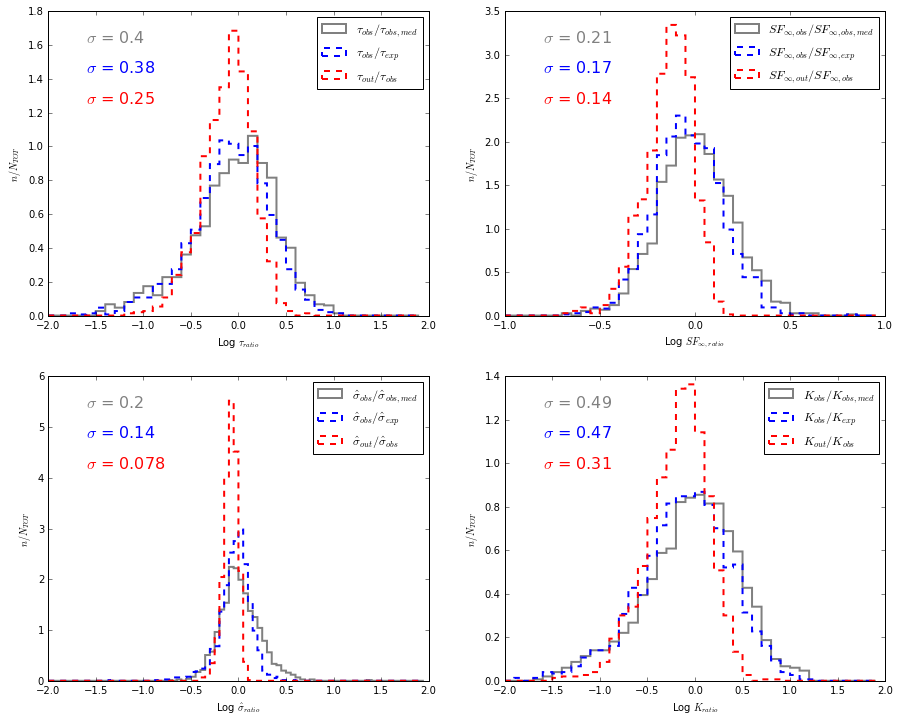

In [3]:
#plot the fugure between input tau sigma and them derived from new light curve, as well as observed tau,sigma from car1
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('my')
#mpl.rc('lines', linewidth=2)
#import seaborn as sns

#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_err.txt') 
#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_40_9_1.2.txt')#3_40_9_1.2.txt 

#ghx_mcmc_un.txt,ghx_un2copy.txt,ghx_noerr.txt,ghx_log_nomcmc.txt,ghx_un_nomcmc_5d.txt,ghx_un_nomcmc_1d.txt
#name,redshift,sigobs_m,tauobs_m,psig,ptau,sigobs_l,sigobs_u,tauobs_l,tauobs_u,Lbest,L0,Linf

'''
mac=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_r.dat')

mac_tau=mac[:,7]
mac_z=mac[:,3]
mac_tau_r=np.log10(np.power(10,mac[:,7])/(1+mac[:,3]))
mac_SF=np.power(10,mac[:,8])
#print np.median(mac_tau),np.median(mac[:,8])
'''
'''  
plt.figure(10)
bin10=np.arange(-0.1,1,0.01)
plt.hist(data[:,6]-data[:,8],bin10,histtype='step',color='black',normed=True)
plt.plot([0.05,0.05],[0.,45.],ls='dashed',color='black')
plt.xlabel(r'$\Delta L = ln (L_{Best}/L_{\infty})$')
plt.ylabel(r'$n/N_{TOT}$')
plt.savefig('paper_figure/select.eps')
#print data[:,6]-data[:,8]

plt.figure(10)
bin10=np.arange(-1.,11,0.3)
plt.hist(data[:,6]-data[:,7],bin10,histtype='step',color='black',normed=True)
plt.plot([2.,2.],[0.,0.45],ls='dashed',color='black')
plt.xlabel(r'$\Delta L = ln (L_{Best}/L_{Noise})$')
plt.ylabel(r'$n/N_{TOT}$')
plt.xlim(-1,10)
plt.savefig('paper_figure/select2.eps')
'''

data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_40_9_1.2.txt')#ghx_un_nomcmc_1d_40_9_1.2.txt') 
#ghx_un_nomcmc_1d_debug_300_0.18_drw.txt')
ind=np.where((data[:,3] <99990)& (data[:,3]<99990)& (data[:,5] < 99990.))# & ((data[:,6]-data[:,7]) > 2.)\
             #&(data[:,4] > 0.0)  &((data[:,6]-data[:,8]) >0.05))
ind=np.where((data[:,3] <99990)& (data[:,3]<99990)& (data[:,5] < 99990.) &(data[:,4] > 0.0) )


z=data[ind,1]
tau_out=np.log10(data[ind,5])
#print 'median_out',np.median(tau_out)
SF_out=data[ind,4]*1.414
#print np.min(SF_out)
sig_out=SF_out/np.sqrt(data[ind,5])

K_out=data[ind,5]*np.sqrt(SF_out)


tau_in=np.log10(data[ind,3])
SF_in=data[ind,2]*1.414
sig_in=SF_in/np.sqrt(data[ind,3])
K_in=data[ind,3]*np.sqrt(SF_in)
#print 'obs:'
print 'median tauout',np.median(tau_out)
print 'median sfout',np.median(SF_in)




#-------------------exp-------------------------------------------------------
def corr(wave_rf, M_i, M_bh,z):
    #relation for subsample
    log_SF=-0.5-0.48*np.log10(wave_rf/4000.)+0.13*(M_i+23)+0.18*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    log_tau=2.1+0.66*np.log10(wave_rf/4000.)-0.19*(M_i+23)+0.14*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    log_sig=-1.72-0.86*np.log10(wave_rf/4000.)+0.22*(M_i+23)+0.11*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    '''
    #relation for lowM in subsample
    log_SF=-0.54-0.49*np.log10(wave_rf/4000.)+0.09*(M_i+23)+0.15*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    log_tau=2.28-0.1*np.log10(wave_rf/4000.)-0.2*(M_i+23)+0.07*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    log_sig=-1.8-0.47*np.log10(wave_rf/4000.)+0.22*(M_i+23)+0.1*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    '''
    return log_SF,log_tau,log_sig


#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un3.txt')
#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_40__5.txt')
#name,redshift,sigobs_m,tauobs_m,psig,ptau,sigobs_l,sigobs_u,tauobs_l,tauobs_u,Lbest,L0,Linf
ind=np.array(np.where((data[:,3] <99990.)& (data[:,5] < 99990.))).reshape(-1,)
# & ((data[:,6]-data[:,7]) > 2.)
tau_inn=(data[ind,3])

SF_inn=data[ind,2]*1.414


infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
index1=np.array(np.where(((infor[:,7]) !=0.0) & (infor[:,5] < -5 ) )).reshape(-1,)

a=infor[index1,:]
b=data[ind,:]
idx_infor=np.in1d(infor[index1,0],data[ind,0])
idx_data=np.in1d(data[ind,0],infor[index1,0])




M_i=a[idx_infor,5]
M_bh=a[idx_infor,7]#+np.random.normal(0,0.3,len(M_bh))
#plt.hist(M_bh)
z=a[idx_infor,6]
wave_rf=6231./(1+z)   # u:3543 g:4770，r:6231,i:7625,z:9134



SF_exp,tau_exp,sig_exp1=np.array(corr(wave_rf,M_i,M_bh,z))
tau_exp=np.power(10,tau_exp)*(1.+z)
SF_exp=np.power(10,SF_exp)

sig_exp1=np.power(10,sig_exp1)
#print np.median(sig_exp1)

sig_exp=SF_exp/np.sqrt(tau_exp)
K_exp=tau_exp*np.sqrt(SF_exp)


tau_mean=np.zeros(len(K_exp))
SF_mean=np.zeros_like(tau_mean)
sig_mean=np.zeros_like(tau_mean)
K_mean=np.zeros_like(tau_mean)

tau_mean=tau_inn[idx_data]
SF_mean=SF_inn[idx_data]
sig_mean=SF_mean/np.sqrt(tau_mean)
K_mean=tau_mean*np.sqrt(SF_mean)

#print len(tau_mean)
#---------------------------------------------------------------------------

'''
# PLOT FIGURES

fig=plt.figure(figsize=(15,12))

ax01=plt.subplot(211)
bin1=np.arange(0,5,0.1)
plt.hist(list(tau_out),bin1,normed='True',histtype='step',color='black',ls='dashed',label='out',lw=2)
plt.hist(list(tau_in),bin1,normed='True',histtype='step',color='black',ls='dotted',label='in',lw=2)

plt.ylabel(r'$n/N_{TOT}$')
plt.xlabel(r'Log $\tau$ (days) ')
plt.legend()

print (np.percentile(tau_out,(16,84))[1]-np.percentile(tau_out,(16,84))[0])*0.5



ax02=plt.subplot(212)
bin2=np.arange(0,1.,0.04)
plt.hist(list(SF_out),bin2,normed=True,histtype='step',color='k',ls='dashed',label='out',lw=2)
plt.hist(list(SF_in),bin2,normed=True,histtype='step',color='k',ls='dotted',label='in',lw=2)
plt.ylabel(r'$n/N_{TOT}$')
plt.xlabel(r'$SF_{\infty}$ (mag)')
plt.legend()

print (np.percentile(SF_out,(16,84))[1]-np.percentile(SF_out,(16,84))[0])*0.5
'''

fig=plt.figure(figsize=(15,12))

ax=plt.subplot(221)
bin1=np.arange(-2,2,0.1)
#plt.hist(list(tau_out),bin1,normed='True',histtype='step',color='red',label='out')
#plt.hist(list(mac_tau),bin1,normed='True',histtype='step',label='mac')
#plt.hist(list(tau_in),bin1,normed='True',histtype='step',color='black',label='in')
plt.hist(list(tau_in-np.median(tau_in)),bin1,normed=True,histtype='step',color='grey',label=r'$\tau_{obs}/\tau_{obs,med}$',lw=2)
plt.hist(list(np.log10(tau_mean/tau_exp)),bin1,normed=True,histtype='step',ls='dashed',color='blue',label=r'$\tau_{obs}/\tau_{exp}$',lw=2)
plt.hist(list((tau_out-tau_in)),bin1,normed=True,histtype='step',color='red',ls='dashed',label=r'$\tau_{out}/\tau_{obs}$',lw=2)

a1=(np.percentile(tau_out-tau_in,(16,84))[1]-np.percentile(tau_out-tau_in,(16,84))[0])*0.5
b1=(np.percentile(tau_in-np.median(tau_in),(16,84))[1]-np.percentile(tau_out-np.median(tau_out),(16,84))[0])*0.5
plt.text(0.1,0.9,'$\sigma$ = '+str(round(b1,2)),color='grey',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.7,'$\sigma$ = '+str(round(a1,2)),color='red',transform = ax.transAxes,fontsize=16)
c1=(np.percentile(np.log10(tau_mean/tau_exp),(16,84))[1]-np.percentile(np.log10(tau_mean/tau_exp),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(c1,2)),color='blue',transform = ax.transAxes,fontsize=16)

plt.ylabel(r'$n/N_{TOT}$')
#plt.xlabel(r'Log $\tau_{ratio}$ ')
plt.xlabel(r'Log $\tau_{ratio}$ ')
plt.legend()


ax=plt.subplot(222)
bin2=np.arange(-1,1.,0.05)
#plt.hist(list(SF_out),bin2,normed=True,histtype='step',color='red',label='out')
#plt.hist(list(mac_SF),bin2,normed=True,histtype='step',label='mac')
#plt.hist(list(SF_in),bin2,normed=True,histtype='step',color='black',label='in')
plt.hist(list(np.log10(SF_in/np.median(SF_in))),bin2,normed=True,histtype='step',color='grey',label=r'$SF_{\infty,obs}/SF_{\infty,obs,med}$',lw=2)
plt.hist(list(np.log10(SF_mean/SF_exp)),bin2,normed=True,color='blue',ls='dashed',histtype='step',label=r'$SF_{\infty,obs}/SF_{\infty,exp}$',lw=2)
plt.hist(list(np.log10(SF_out/SF_in)),bin2,normed=True,histtype='step',color='red',ls='dashed',label=r'$SF_{\infty,out}/SF_{\infty,obs}$',lw=2)

a2=np.percentile(np.log10(SF_out/SF_in),(16,50))[1]-np.percentile(np.log10(SF_out/SF_in),(16,50))[0]
b2=np.percentile(np.log10(SF_in/np.median(SF_in)),(16,50))[1]-np.percentile(np.log10(SF_out/np.median(SF_out)),(16,50))[0]
plt.text(0.1,0.9,'$\sigma$ = '+str(round(b2,2)),color='grey',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.7,'$\sigma$ = '+str(round(a2,2)),color='red',transform = ax.transAxes,fontsize=16)

c2=(np.percentile(np.log10(SF_mean/SF_exp),(16,84))[1]-np.percentile(np.log10(SF_mean/SF_exp),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(c2,2)),color='blue',transform = ax.transAxes,fontsize=16)


plt.xlabel(r'Log $SF_{\infty,ratio} $')
#plt.xlabel(r'Log $SF_{\infty}$ (mag)')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend()


ax=plt.subplot(223)
bin3=np.arange(-2,2,0.05)
#plt.hist(list(sig_out),bin3,histtype='step',label=r'$\sigma_{out}$')
#plt.hist(list(sig_in),bin3,histtype='step',label=r'$\sigma_{in}$')

#print np.median(sig_exp1), np.median(sig_mean)
plt.hist(list(np.log10(sig_in/np.median(sig_in))),bin3,normed='True',histtype='step',color='grey',label=r'$\hat\sigma_{obs}/\hat\sigma_{obs,med}$',lw=2)
plt.hist(list(np.log10(sig_exp1/sig_mean)),bin3,normed=True,histtype='step',color='blue',ls='dashed',label=r'$\hat\sigma_{obs}/\hat\sigma_{exp}$',lw=2)
plt.hist(list(np.log10(sig_out/sig_in)),bin3,normed=True,histtype='step',color='red',ls='dashed', label=r'$\hat\sigma_{out}/\hat\sigma_{obs}$',lw=2)

plt.xlabel(r'Log $\hat\sigma_{ratio}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend()#,frameon=False)

sig_oi_sgm=(np.percentile(np.log10(sig_out/sig_in),(16,50))[1]-np.percentile(np.log10(sig_out/sig_in),(16,50))[0])*0.5*2
sig_in_sgm=(np.percentile(np.log10(sig_in/np.median(sig_in)),(16,84))[1]-np.percentile(np.log10(sig_in/np.median(sig_in)),(16,84))[0])*0.5

plt.text(0.1,0.9,'$\sigma$ = '+str(round(sig_in_sgm,2)),color='grey',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sig_oi_sgm,3)),color='red',transform = ax.transAxes,fontsize=16)
sig_oi_sgm=(np.percentile(np.log10(sig_mean/sig_exp1),(16,84))[1]-np.percentile(np.log10(sig_mean/sig_exp1),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sig_oi_sgm,2)),color='blue',transform = ax.transAxes,fontsize=16)

ax=plt.subplot(224)
bin4=np.arange(-2,2,0.1)


#plt.hist(list(K_out),bin4,histtype='step',label='$K_{out}$')
#plt.hist(list(K_in),bin4,histtype='step',label='$K_{in}$')
#plt.hist(list(np.log10(K/np.median(K))),bin4,normed=True,histtype='step',label=r'$K_{obs/median} $')

#plt.hist(list(np.log10(K/K_in)),bin4,normed=True,histtype='step',label=r'$K_{obs}/K_{in}$')
plt.hist(list(np.log10(K_in/np.median(K_in))),bin4,normed=True,histtype='step',color='grey',label=r'$K_{obs}/K_{obs,med}$',lw=2)
plt.hist(list(np.log10(K_mean/K_exp)),bin4,normed=True,histtype='step',color='blue',ls='dashed', label=r'$K_{obs}/K_{exp}$',lw=2)
plt.hist(list(np.log10(K_out/K_in)),bin4,normed=True,histtype='step',color='red',ls='dashed', label=r'$K_{out}/K_{obs}$',lw=2)

plt.xlabel(r'Log $K_{ratio}$')
plt.ylabel('$n/N_{TOT}$')
plt.legend()#,frameon=False)

K_oi_sgm=(np.percentile(np.log10(K_out/K_in),(16,84))[1]-np.percentile(np.log10(K_out/K_in),(16,84))[0])*0.5
K_in_sgm=(np.percentile(np.log10(K_in/np.median(K_in)),(16,84))[1]-\
           np.percentile(np.log10(K_in/np.median(K_in)),(16,84))[0])*0.5 
plt.text(0.1,0.9,'$\sigma$ = '+str(round(K_in_sgm,2)),color='grey',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.7,'$\sigma$ = '+str(round(K_oi_sgm,2)),color='red',transform = ax.transAxes,fontsize=16)
K_me_sgm=(np.percentile(np.log10(K_mean/K_exp),(16,49))[1]-np.percentile(np.log10(K_mean/K_exp),(16,49))[0])*0.5*2
plt.text(0.1,0.8,'$\sigma$ = '+str(round(K_me_sgm,2)),color='blue',transform = ax.transAxes,fontsize=16)

plt.savefig('paper_figure/four_select_subsample.eps')



-2.0


6333
0.0854010101643
568.064 603.664 0.19796 0.164024
0.00824890317095 0.00657166482461 0.818769431265


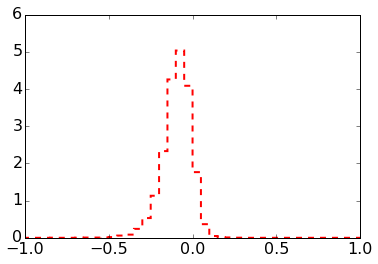

In [5]:
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d.txt')
ind=np.where((data[:,3] <99990)& (data[:,3]<99990)& (data[:,5] < 99990.) )
ind=np.where((data[:,3] <99990)& (data[:,3]<99990)& (data[:,5] < 99990.) &(data[:,4] > 0.0) )
print len(np.array(data[ind,1]).reshape(-1,))


tau_out=np.log10(data[ind,5])
SF_out=data[ind,4]*1.414
sig_out=SF_out/np.sqrt(data[ind,5])



tau_in=np.log10(data[ind,3])
SF_in=data[ind,2]*1.414
sig_in=SF_in/np.sqrt(data[ind,3])

plt.figure()
plt.hist(list(np.log10(sig_out/sig_in)),bin3,normed=True,histtype='step',color='red',ls='dashed', label=r'$\hat\sigma_{out}/\hat\sigma_{obs}$',lw=2)
plt.xlim(-1,1)
#plt.ylim(0.,0.03)

#a=plt.hist(list(np.log10(sig_out/sig_in)),bin3,normed=True,histtype='step',color='red',ls='dashed')
print (np.percentile(list(np.log10(sig_out/sig_in)),(16,50))[1]-np.percentile(list(np.log10(sig_out/sig_in)),(16,50))[0])*0.5*2

print np.median(10**tau_in),np.median(10**tau_out),np.median(SF_in),np.median(SF_out)
print np.median(sig_in),np.median(sig_out),np.median(sig_out/sig_in)
#0.005-0.03

[  3.03000000e+02   2.33000000e+02   1.64000000e-01   1.20000000e-01
   9.60000000e-03   7.90000000e-03   8.40000000e-01   7.80000000e-02]


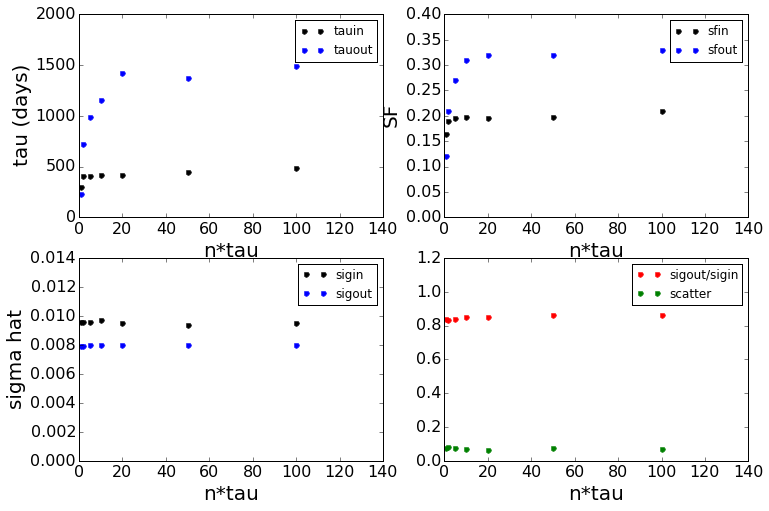

In [48]:


tauin=[303,407,406,414,417,443,488]
tauout=[233,719,986,1159,1419,1378,1489]
sfin=[0.164,0.19,0.195,0.197,0.195,0.198,0.21]
sfout=[0.12,0.21,0.27,0.31,0.32,0.32,0.33]
sigin=[0.0096,0.0096,0.0096,0.0097,0.0095,0.0094,0.0095]
sigout=[0.0079,0.0079,0.008,0.008,0.008,0.008,0.008]
ratio=[0.84,0.83,0.84,0.85,0.85,0.86,0.86]
scatter=[0.078,0.081,0.076,0.067,0.065,0.074,0.071]

a=np.array([tauin,tauout,sfin,sfout,sigin,sigout,ratio,scatter])
print a[:,0]
x=[1,2,5,10,20,50,100]

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(x,a[0,:],'k.',markersize=10,label='tauin')
plt.plot(x,a[1,:],'b.',markersize=10,label='tauout')
plt.ylim(0,2000)
plt.xlim(0,140)
plt.xlabel('n*tau')
plt.ylabel('tau (days)')
plt.legend()
plt.subplot(222)
plt.plot(x,a[2,:],'k.',markersize=10,label='sfin')
plt.plot(x,a[3,:],'b.',markersize=10,label='sfout')
plt.ylim(0,0.4)
plt.xlim(0,140)
plt.ylabel('SF')
plt.xlabel('n*tau')
plt.legend()
plt.subplot(223)
plt.plot(x,a[4,:],'k.',markersize=10,label='sigin')
plt.plot(x,a[5,:],'b.',markersize=10,label='sigout')
plt.ylim(0,0.014)
plt.xlim(0,140)
plt.xlabel('n*tau')
plt.ylabel('sigma hat')
plt.legend()

plt.subplot(224)
plt.plot(x,a[6,:],'r.',markersize=10,label='sigout/sigin')
plt.plot(x,a[7,:],'g.',markersize=10,label='scatter')
plt.ylim(0,1.2)
plt.xlim(0,140)
plt.xlabel('n*tau')
plt.legend()
plt.savefig('debug.eps')

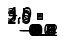

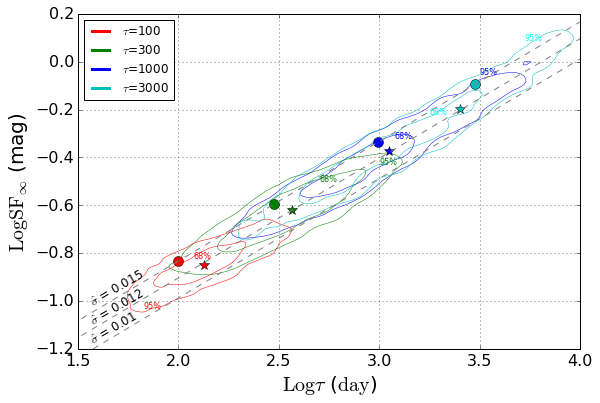

In [20]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import matplotlib.mlab as mlab
import matplotlib.tri as tri
from matplotlib.colors import LogNorm
plt.style.use('my')
#print(plt.style.available)
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate

data100=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_debug_100_samesig.txt')
data300=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_debug_300_samesig.txt')
data1000=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_debug_1000_samesig.txt')
data3000=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_debug_3000_samesig.txt')
#name,redshift,sigobs_m,tauobs_m,psig,ptau

sf100=data100[:,4]*1.414
tau100=data100[:,5]
sf300=data300[:,4]*1.414
tau300=data300[:,5]
sf1000=data1000[:,4]*1.414
tau1000=data1000[:,5]

sf3000=data3000[:,4]*1.414
tau3000=data3000[:,5]


ind300=np.where(tau300 < 20000,True,False)
ind1000=np.where(tau1000 < 20000,True,False)
ind3000=np.where(tau3000 < 20000,True,False)


plt.figure(figsize=(0.1,0.1))
counts,ybins,xbins,image = plt.hist2d(np.log10(sf100),np.log10(tau100),norm=LogNorm(),bins=100)
counts2,ybins2,xbins2,image2 = plt.hist2d(np.log10(sf300[ind300]),np.log10(tau300[ind300]),norm=LogNorm(),bins=100)
counts3,ybins3,xbins3,image3 = plt.hist2d(np.log10(sf1000[ind1000]),np.log10(tau1000[ind1000]),norm=LogNorm(),bins=100)
counts4,ybins4,xbins4,image4 = plt.hist2d(np.log10(sf3000[ind3000]),np.log10(tau3000[ind3000]),norm=LogNorm(),bins=100)

counts3=counts3/counts3.sum()
n = 1000
t = np.linspace(0, counts3.max(), n)
integral = ((counts3 >=t[:, None, None]) * counts3).sum(axis=(1,2))
f = interpolate.interp1d(integral, t)
t_contours3 = f(np.array([0.95,0.68]))

counts2=counts2/counts2.sum()
n = 1000
t = np.linspace(0, counts2.max(), n)
integral2 = ((counts2 >=t[:, None, None]) * counts2).sum(axis=(1,2))
f = interpolate.interp1d(integral2, t)
t_contours2 = f(np.array([0.95,0.68]))

counts=counts/counts.sum()
n = 1000
t = np.linspace(0, counts.max(), n)
integral0 = ((counts >=t[:, None, None]) * counts).sum(axis=(1,2))
f = interpolate.interp1d(integral0, t)
t_contours1 = f(np.array([0.95,0.68]))

counts4=counts4/counts4.sum()
n = 1000
t = np.linspace(0, counts4.max(), n)
integral4 = ((counts >=t[:, None, None]) * counts).sum(axis=(1,2))
f = interpolate.interp1d(integral4, t)
t_contours4 = f(np.array([0.95,0.68]))



fig=plt.figure(figsize=(9,6))
ax=plt.subplot(111)
C1=plt.contour(gaussian_filter(counts3, 2),t_contours3,extent=[xbins3.min(),xbins3.max(),ybins3.min(),ybins3.max()],linewidths=0.5,colors=('b'))
C2=plt.contour(gaussian_filter(counts2, 2),t_contours2,extent=[xbins2.min(),xbins2.max(),ybins2.min(),ybins2.max()],linewidths=0.5,colors=('g'))
C3=plt.contour(gaussian_filter(counts, 2),t_contours1,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=0.5,colors=('r'))
C4=plt.contour(gaussian_filter(counts4, 2),t_contours4,extent=[xbins4.min(),xbins4.max(),ybins4.min(),ybins4.max()],linewidths=0.5,colors=('c'))

plt.plot([np.log10(300.)],[np.log10(0.18*1.414)],'go')
plt.plot([np.log10(300/3.)],[np.log10(0.18*1.414/np.sqrt(3))],'ro')
plt.plot([np.log10(300*3.3)],[np.log10(0.18*1.414*np.sqrt(3.3))],'bo')
plt.plot([np.log10(300*10)],[np.log10(0.18*1.414*np.sqrt(10))],'co')

plt.plot([np.median(np.log10(tau100))],[np.median(np.log10(sf100))],'r*')
plt.plot([np.median(np.log10(tau300))],[np.median(np.log10(sf300))],'g*')
plt.plot([np.median(np.log10(tau1000))],[np.median(np.log10(sf1000))],'b*')
plt.plot([np.median(np.log10(tau3000))],[np.median(np.log10(sf3000))],'c*')

#plt.clabel(C1, inline=1,fmt='%1.1f',fontsize=10)
#plt.clabel(C2, inline=1,fmt='%1.1f',fontsize=10)
#plt.clabel(C3, inline=1,fmt='%1.1f',fontsize=10)

plt.plot([0],[0],'r-',label=r'$\tau$=100')
plt.plot([0],[0],'g-',label=r'$\tau$=300')
plt.plot([0],[0],'b-',label=r'$\tau$=1000')
plt.plot([0],[0],'c-',label=r'$\tau$=3000')
plt.ylabel(r'$\rm Log SF_{\infty}$ (mag)')
plt.xlabel(r'$\rm Log {\tau}$ ($\rm day$)')
plt.xlim(1.5,4)
plt.ylim(-1.2,0.2)
plt.legend(loc=2)
plt.grid()


n=100
m=100
plt.plot([np.log10(300/3/m),np.log10(300*m)],[np.log10(0.18*1.414/np.sqrt(3*n)),np.log10(0.18*1.414*np.sqrt(n))],color='gray',ls='--',lw=1)
f=[0.7,0.85]

plt.plot([np.log10(300/3/m),np.log10(300*m)],[np.log10(0.18*1.414/np.sqrt(3*n)*f[0]),np.log10(0.18*1.414*np.sqrt(n)*f[0])],lw=1,color='gray',ls='--')
plt.plot([np.log10(300/3/m),np.log10(300*m)],[np.log10(0.18*1.414/np.sqrt(3*n)*f[1]),np.log10(0.18*1.414*np.sqrt(n)*f[1])],lw=1,color='gray',ls='--')
plt.text(0.02,0.215,'$\hat\sigma$ = 0.015',transform = ax.transAxes,fontsize=12,rotation=30)
plt.text(0.02,0.157,'$\hat\sigma$ = 0.012',transform = ax.transAxes,fontsize=12,rotation=30)
plt.text(0.02,0.09,'$\hat\sigma$ = 0.01',transform = ax.transAxes,fontsize=12,rotation=30)
#-----68% and 95%------
plt.text(0.8,0.82,'95%',transform = ax.transAxes,fontsize=8,color='blue')
plt.text(0.63,0.63,'68%',transform = ax.transAxes,fontsize=8,color='blue')
plt.text(0.13,0.12,'95%',transform = ax.transAxes,fontsize=8,color='red')
plt.text(0.23,0.27,'68%',transform = ax.transAxes,fontsize=8,color='red')

plt.text(0.6,0.55,'95%',transform = ax.transAxes,fontsize=8,color='green')
plt.text(0.48,0.5,'68%',transform = ax.transAxes,fontsize=8,color='green')

plt.text(0.89,0.92,'95%',transform = ax.transAxes,fontsize=8,color='cyan')
plt.text(0.7,0.7,'68%',transform = ax.transAxes,fontsize=8,color='cyan')



plt.savefig('paper_figure/samesig.eps')

1760 5601
---- 3352


(1, 10000)

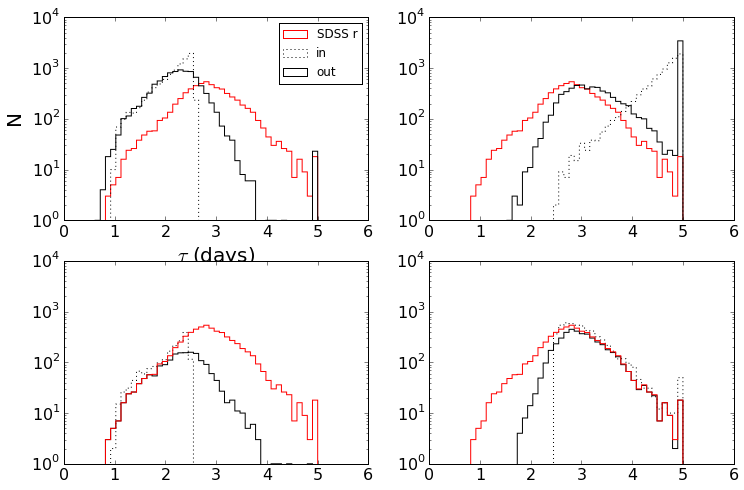

In [40]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('my')

data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_err.txt') 
over=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/overlong_normal_10_300.txt') 
over2=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/overlong_normal_300_100000.txt')

#runaway=np.where(data[:,3])
data[data[:,3]==np.inf]=10000000
data[data[:,3]>100000]=10000000
ind1=np.where(data[:,3] < 300,True,False)
ind2=np.where((data[:,3] > 300.) &(data[:,3] <100000), True,False)
print np.sum(ind1),np.sum(ind2)



tau_in_sim=np.log10(over[:,0])
#print (tau_in_sim)
tau_out_sim=np.log10(over[:,2])
tau_out_sim[tau_out_sim==np.inf]=5
tau_out_sim[tau_out_sim>5]=5

#print '----', np.sum(np.where(tau_out_sim == 5,True, False))

tau_in_sim2=np.log10(over2[:,0])
tau_out_sim2=np.log10(over2[:,2])
tau_out_sim2[tau_out_sim2>5]=5
print '----',np.sum(np.where(tau_out_sim2 == 5,True,False))


tau_out0=np.log10(data[:,5])
tau_in0=np.log10(data[:,3])
tau_out=np.log10(data[ind1,5])
tau_in=np.log10(data[ind1,3])
tau_out2=np.log10(data[ind2,5])
tau_in2=np.log10(data[ind2,3])

fig=plt.figure(figsize=(12,8))
ax=plt.subplot(221)
bin1=np.linspace(0, 5, 50)
#plt.hist(list(tau_out),bin1,histtype='step',color='red',label='out')
#plt.hist(list(tau_in),bin1,histtype='step',color='black',label='in')
plt.hist(list(tau_out0),bin1,histtype='step',color='red',label='SDSS r',log='True')
plt.hist(list(tau_in_sim),bin1,histtype='step',color='black',label='in',linestyle='dotted',log='True')
plt.hist(list(tau_out_sim),bin1,histtype='step',color='black',label='out',log='True')
#plt.gca().set_xscale("log")
plt.xlim(0,6)
plt.ylim(1,10000)
plt.legend()#frameon=False)
plt.xlabel(r'$\tau$ (days)')
plt.ylabel('N')


ax=plt.subplot(222)
plt.hist(list(tau_out0),bin1,histtype='step',color='red',label='SDSS r',log='True')
plt.hist(list(tau_in_sim2),bin1,histtype='step',color='black',label='in',linestyle='dotted',log='True')
plt.hist(list(tau_out_sim2),bin1,histtype='step',color='black',label='out',log='True')
#plt.gca().set_xscale("log")
plt.xlim(0,6)
plt.ylim(1,10000)


ax=plt.subplot(223)
plt.hist(list(tau_out),bin1,histtype='step',color='black',label='out')
plt.hist(list(tau_in),bin1,histtype='step',color='black',label='in',linestyle='dotted')
plt.hist(list(tau_out0),bin1,histtype='step',color='red',label='SDSS r',log='True')
#plt.gca().set_xscale("log")
plt.xlim(0,6)
plt.ylim(1,10000)

ax=plt.subplot(224)
plt.hist(list(tau_out2),bin1,histtype='step',color='black',label='out')
plt.hist(list(tau_in2),bin1,histtype='step',color='black',label='in',linestyle='dotted')
plt.hist(list(tau_out0),bin1,histtype='step',color='red',label='SDSS r',log='True')
#plt.gca().set_xscale("log")
plt.xlim(0,6)
plt.ylim(1,10000)




4798
tau slope 0.269274407596
popttau [ 2.47192312  1.         -0.03471387  0.13879279  1.        ]
SF slope -0.486280411674
poptSF [-0.53457675  1.          0.1013107   0.11949482  1.        ]
Log sig slope -0.629606624096
poptsig [-1.87044877  1.          0.1619736   0.05496661  1.        ]
1449
tau slope 0.0116357344211
popttau [ 2.35372057  1.         -0.16153844  0.13536819  1.        ]
SF slope -0.506525005847
poptSF [-0.51206634  1.          0.1005766   0.18302122  1.        ]
Log sig slope -0.539923830289
poptsig [-1.7976628   1.          0.20810767  0.10983156  1.        ]
665
tau slope -0.103879588231
popttau [ 2.28108778  1.         -0.19350261  0.07002814  1.        ]
SF slope -0.485076850646
poptSF [-0.54386994  1.          0.08734222  0.15141652  1.        ]
Log sig slope -0.474903473139
poptsig [-1.79680935  1.          0.21558431  0.1049005   1.        ]


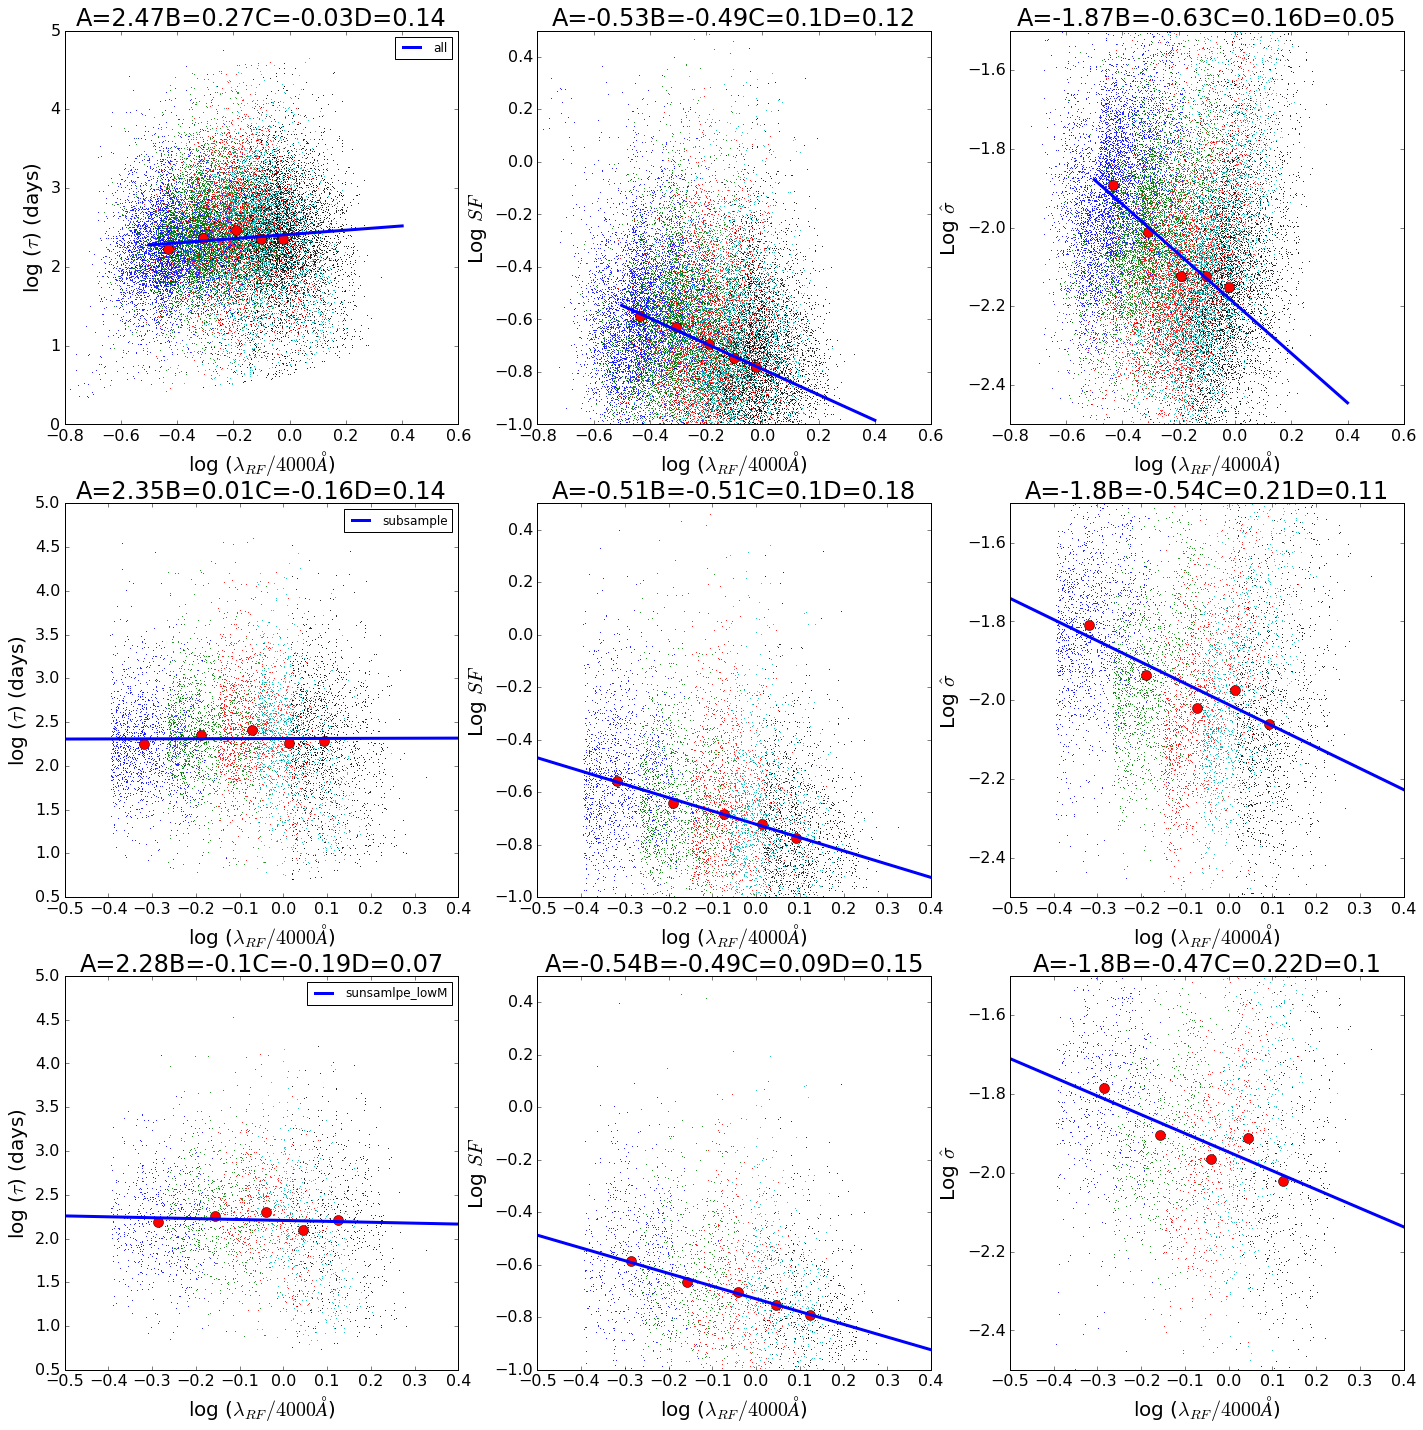

In [2]:
#correlation.py to explore a new correlation between tau and physical parameters.
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
plt.style.use('my')



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_r.dat')
infor_u=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_u.dat')
infor_g=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_g.dat')
infor_i=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_i.dat')
infor_z=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_z.dat')

mass=8.5
ind=np.where((infor[:,5] >0)&(infor[:,7] >1)& (infor[:,7] < 5) ,True,False )
ind2=np.where((infor[:,5] >0)&(infor[:,7] >1)& (infor[:,7] < 5)&(infor[:,3]<1.2)&(infor[:,5]>0)&(infor[:,5]<9.) ,True,False )
ind3=np.where((infor[:,5] >0)&(infor[:,7] >1)& (infor[:,7] < 5)&(infor[:,3]<1.2)&(infor[:,5]>0)&(infor[:,5]<mass) ,True,False )
ind_u=np.where((infor_u[:,5] >0)&(infor_u[:,7] >1)& (infor_u[:,7] < 5) ,True,False )
ind2_u=np.where((infor_u[:,5] >0)&(infor_u[:,7] >1)& (infor_u[:,7] < 5)&(infor_u[:,3]<1.2)\
                &(infor_u[:,5]>0)&(infor_u[:,5]<9.) ,True,False )
ind3_u=np.where((infor_u[:,5] >0)&(infor_u[:,7] >1)& (infor_u[:,7] < 5)&(infor_u[:,3]<1.2)\
                &(infor_u[:,5]>0)&(infor_u[:,5]<mass) ,True,False )
ind_g=np.where((infor_g[:,5] >0)&(infor_g[:,7] >1)& (infor_g[:,7] < 5) ,True,False )
ind2_g=np.where((infor_g[:,5] >0)&(infor_g[:,7] >1)& (infor_g[:,7] <5)&(infor_g[:,3]<1.2)\
                &(infor_g[:,5]>0)&(infor_g[:,5]<9.) ,True,False )
ind3_g=np.where((infor_g[:,5] >0)&(infor_g[:,7] >1)& (infor_g[:,7] <5)&(infor_g[:,3]<1.2)\
                &(infor_g[:,5]>0)&(infor_g[:,5]<mass) ,True,False )
ind_i=np.where((infor_i[:,5] >0)&(infor_i[:,7] >1)& (infor_i[:,7] < 5) ,True,False )
ind2_i=np.where((infor_i[:,5] >0)&(infor_i[:,7] >1)& (infor_i[:,7] <5)&(infor_i[:,3]<1.2)\
                &(infor_i[:,5]>0)&(infor_i[:,5]<9.) ,True,False )
ind3_i=np.where((infor_i[:,5] >0)&(infor_i[:,7] >1)& (infor_i[:,7] <5)&(infor_i[:,3]<1.2)\
                &(infor_i[:,5]>0)&(infor_i[:,5]<mass) ,True,False )
ind_z=np.where((infor_z[:,5] >0)&(infor_z[:,7] >1)& (infor_z[:,7] < 5) ,True,False )
ind2_z=np.where((infor_z[:,5] >0)&(infor_z[:,7] >1)& (infor_z[:,7] <5)&(infor_z[:,3]<1.2)\
                &(infor_z[:,5]>0)&(infor_z[:,5]<9.),True,False )
ind3_z=np.where((infor_z[:,5] >0)&(infor_z[:,7] >1)& (infor_z[:,7] <5)&(infor_z[:,3]<1.2)\
                &(infor_z[:,5]>0)&(infor_z[:,5]<mass),True,False )


fig=plt.figure(figsize=(24,24))
for n in enumerate([1,2,3]):
    if n[1] ==1:
        ind=ind
        ind_u=ind_u
        ind_g=ind_g
        ind_i=ind_i
        ind_z=ind_z
        label='all'
        def fntau(x, a,b,c,d,e):
            b=0.27
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

        def fnSF(x, a,b,c,d,e):
            b=-0.48
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

        def fnsig(x, a,b,c,d,e):
            b=-0.63
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

    if n[1] ==2:
        ind=ind2
        ind_u=ind2_u
        ind_g=ind2_g
        ind_i=ind2_i
        ind_z=ind2_z
        label='subsample'
        def fntau(x, a,b,c,d,e):
            b=0.01
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

        def fnSF(x, a,b,c,d,e):
            b=-0.51
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

        def fnsig(x, a,b,c,d,e):
            b=-0.54
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]
        

    if n[1] ==3:
        ind=ind3
        ind_u=ind3_u
        ind_g=ind3_g
        ind_i=ind3_i
        ind_z=ind3_z
        label='sunsamlpe_lowM'
        def fntau(x, a,b,c,d,e):
            b=-0.1
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

        def fnSF(x, a,b,c,d,e):
            b=-0.49
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]

        def fnsig(x, a,b,c,d,e):
            b=-0.47
            e=0
            return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]
    print np.sum(ind)


    Mi=infor[ind,4]+23
    Mbh=infor[ind,5]-9


    z=infor[ind,3]
    z_u=infor_u[ind_u,3]
    z_g=infor_g[ind_g,3]
    z_i=infor_i[ind_i,3]
    z_z=infor_z[ind_z,3]

    tau=infor[ind,7]-np.log10(1+z)
    tau_u=infor_u[ind_u,7]-np.log10(1+z_u)
    tau_g=infor_g[ind_g,7]-np.log10(1+z_g)
    tau_i=infor_i[ind_i,7]-np.log10(1+z_i)
    tau_z=infor_z[ind_z,7]-np.log10(1+z_z)


    SF=np.log10(np.power(10,infor[ind,8])*np.sqrt(10**infor[ind,7]/365.))
    SF_u=np.log10(np.power(10,infor_u[ind_u,8])*np.sqrt(10**infor_u[ind_u,7]/365.))
    SF_g=np.log10(np.power(10,infor_g[ind_g,8])*np.sqrt(10**infor_g[ind_g,7]/365.))
    SF_i=np.log10(np.power(10,infor_i[ind_i,8])*np.sqrt(10**infor_i[ind_i,7]/365.))
    SF_z=np.log10(np.power(10,infor_z[ind_z,8])*np.sqrt(10**infor_z[ind_z,7]/365.))


    sig=infor[ind,8]-np.log10(np.sqrt(365))
    sig_u=infor_u[ind_u,8]-np.log10(np.sqrt(365))
    sig_g=infor_g[ind_g,8]-np.log10(np.sqrt(365))
    sig_i=infor_i[ind_i,8]-np.log10(np.sqrt(365))
    sig_z=infor_z[ind_z,8]-np.log10(np.sqrt(365))



    #print np.mean(sig)

    wave_rf=np.log10((6231./(1+z))/4000)   # u:3543 g:4770，r:6231,i:7625,z:9134
    wave_rf_u=np.log10((3543./(1+z_u))/4000)
    wave_rf_g=np.log10((4770/(1+z_g))/4000)
    wave_rf_i=np.log10((7625./(1+z_i))/4000)
    wave_rf_z=np.log10((9134./(1+z_z))/4000)

    xx=np.array([wave_rf,Mi,Mbh,1+z])

    
    plt.subplot(3,3,1+3*(n[1]-1))
    plt.plot(wave_rf,tau,'.r',markersize=1)
    plt.plot(wave_rf_u,tau_u,'.b',markersize=1)
    plt.plot(wave_rf_g,tau_g,'.g',markersize=1)
    plt.plot(wave_rf_i,tau_i,'.c',markersize=1)
    plt.plot(wave_rf_z,tau_z,'.k',markersize=1)


    tau_all=np.concatenate((tau_u,tau_g,tau,tau_i,tau_z), axis=0)
    SF_all=np.concatenate((SF_u,SF_g,SF,SF_i,SF_z), axis=0)
    sig_all=np.concatenate((sig_u,sig_g,sig,sig_i,sig_z), axis=0)


    wave_all=np.concatenate((wave_rf_u,wave_rf_g,wave_rf,wave_rf_i,wave_rf_z),axis=0)
    tau_m=np.array([np.median(tau_u),np.median(tau_g),np.median(tau),np.median(tau_i),np.median(tau_z)])
    wave_rf_m=np.array([np.median(wave_rf_u),np.median(wave_rf_g),np.median(wave_rf),np.median(wave_rf_i),np.median(wave_rf_z)])

    x = np.linspace(-0.5,0.4,100)
    slope, intercept, r_value, p_value, std_err = stats.linregress(wave_all,tau_all)
    line = slope*x+intercept

    slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(wave_rf_m,tau_m)
    line3 = slope3*x+intercept3
    print "tau slope",slope3
    plt.plot(wave_rf_m,tau_m,'ro')
    #plt.plot(x,line,'g',label='subsample')
    plt.plot(x,line3,'b',label=label)
    #plt.xlim(-0.4,0.3)
    plt.xlabel(r'log ($\lambda_{RF}/4000{\AA}$)')
    plt.ylabel(r'log ($\tau$) (days)')
    plt.legend()
    popttau, pcovtau = curve_fit(fntau, xx, tau)
    print 'popttau',popttau
    plt.title('A='+np.round(popttau[0],2).astype(str)+'B='+np.round(slope3,2).astype(str)+\
              'C='+np.round(popttau[2],2).astype(str)+'D='+np.round(popttau[3],2).astype(str))

    #----------------------------------SF------------------
    #fig=plt.figure(figsize=(8,6))
    plt.subplot(3,3,2+3*(n[1]-1))
    plt.plot(wave_rf,SF,'.r',markersize=1)
    plt.plot(wave_rf_u,SF_u,'.b',markersize=1)
    plt.plot(wave_rf_g,SF_g,'.g',markersize=1)
    plt.plot(wave_rf_i,SF_i,'.c',markersize=1)
    plt.plot(wave_rf_z,SF_z,'.k',markersize=1)
    plt.ylim(-1,0.5)
    plt.xlabel(r'log ($\lambda_{RF}/4000{\AA}$)')
    plt.ylabel(r'Log $SF$ ')

    SF_m=np.array([np.median(SF_u),np.median(SF_g),np.median(SF),np.median(SF_i),np.median(SF_z)])

    slope, intercept, r_value, p_value, std_err = stats.linregress(wave_all,SF_all)
    line = slope*x+intercept
    #print slope,std_err
    slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(wave_rf_m,SF_m)
    line3 = slope3*x+intercept3
    print "SF slope", slope3
    plt.plot(wave_rf_m,SF_m,'ro')
    #plt.plot(x,line,'g',label='subsample')
    plt.plot(x,line3,'b',label='subsample_median')
    poptsf, pcovsig = curve_fit(fnSF, xx, SF)
    print 'poptSF',poptsf
    plt.title('A='+np.round(poptsf[0],2).astype(str)+'B='+np.round(slope3,2).astype(str)+\
              'C='+np.round(poptsf[2],2).astype(str)+'D='+np.round(poptsf[3],2).astype(str))

    #----------------------------------sighat------------------
    #fig=plt.figure(figsize=(8,6))
    plt.subplot(3,3,3+3*(n[1]-1))
    plt.plot(wave_rf,sig,'.r',markersize=1)
    plt.plot(wave_rf_u,sig_u,'.b',markersize=1)
    plt.plot(wave_rf_g,sig_g,'.g',markersize=1)
    plt.plot(wave_rf_i,sig_i,'.c',markersize=1)
    plt.plot(wave_rf_z,sig_z,'.k',markersize=1)
    plt.ylim(-2.5,-1.5)
    plt.xlabel(r'log ($\lambda_{RF}/4000{\AA}$)')
    plt.ylabel(r'Log $\hat\sigma$ ')


    sig_m=np.array([np.median(sig_u),np.median(sig_g),np.median(sig),np.median(sig_i),np.median(sig_z)])
    slope, intercept, r_value, p_value, std_err = stats.linregress(wave_all,sig_all)
    line = slope*x+intercept
    slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(wave_rf_m,sig_m)
    line3 = slope3*x+intercept3
    print "Log sig slope",slope3
    plt.plot(wave_rf_m,sig_m,'ro')
    plt.plot(x,line3,'b',label='subsample_median')
    poptsig, pcovsig = curve_fit(fnsig, xx, sig)
    print 'poptsig',poptsig

    plt.title('A='+np.round(poptsig[0],2).astype(str)+'B='+np.round(slope3,2).astype(str)+\
              'C='+np.round(poptsig[2],2).astype(str)+'D='+np.round(poptsig[3],2).astype(str))

plt.savefig('paper_figure/empirical_relation.eps')

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


0.0802
ind 4861
ind2 4865
tauin median 2.83617
popt [ 1.35789335  1.         -0.07007157  0.14349136  1.        ]


/Applications/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


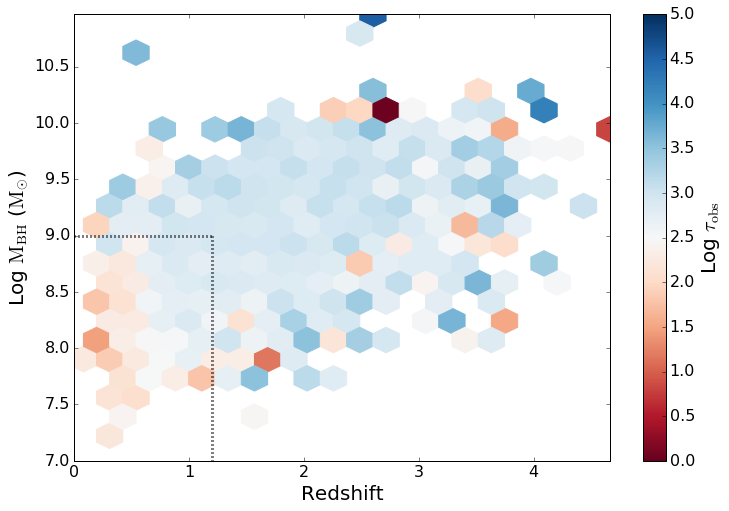

In [1]:
#mac'results
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy import stats, linalg
plt.style.use('my')
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
 
 
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
 
 
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
     
    C = np.asarray(C)
    #print C.shape
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
 
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
             
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
         
    return P_corr

from scipy.optimize import curve_fit

def fn(x, a,b , c,d,e):
    b=-0.25
    e=0
    return a + b*x[0] + c*x[1]+d*x[2] + e*x[3]



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_r.dat')
print np.min(infor[:,3])
ind=np.where((infor[:,5] >0)&(infor[:,7] >0.1)& (infor[:,7] < 5) ,True,False )
ind2=np.where((infor[:,5] >0)&(infor[:,7] >0)&(infor[:,7] <5)& (infor[:,5] < 11 )&(infor[:,3]<5) ,True,False )
print 'ind',np.sum(ind)
print 'ind2', np.sum(ind2)
ind=ind2

Mi=infor[ind,4]+23
Mbh=infor[ind,5]
z=infor[ind,3]
tau=infor[ind,7]#-np.log10(1+z)
print 'tauin median',np.median(tau)
wave_rf=np.log10((6231./(1+z))/4000.)
#print 'z=1.2',np.log10(6231/2.2/4000.)
x=np.array([wave_rf,Mi,Mbh,1+z])
popt, pcov = curve_fit(fn, x, tau)
print 'popt',popt

np.savetxt('data.txt',np.array([tau,wave_rf,Mbh]))

fig=plt.figure(figsize=(12,8))
plt.subplot(111)
plt.hexbin(z, Mbh, C=tau, gridsize=20, marginals=False, cmap=plt.cm.RdBu,
           vmax=5, vmin=0)
#plt.plot([-0.07,0.2],[0,0],'k:')
#plt.plot([-0.07,-0.07],[-2,0],'k:')
plt.plot([0,1.2],[9.,9.],'k:')
plt.plot([1.2,1.2],[7,9.],'k:')
cb = plt.colorbar()
cb.set_label(r'Log $\tau_{\rm obs}$')
plt.xlabel(r'Redshift')
plt.ylabel(r'Log $\rm M_{BH}$ ($\rm M_{\odot}$)')


C=np.zeros([np.sum(ind),5])
a=np.ones_like(tau)
C[:,0]=tau
C[:,1]=wave_rf
C[:,2]=Mi
C[:,3]=Mbh
C[:,4]=z

#print partial_corr(C)




ind 5585
2.98562403986


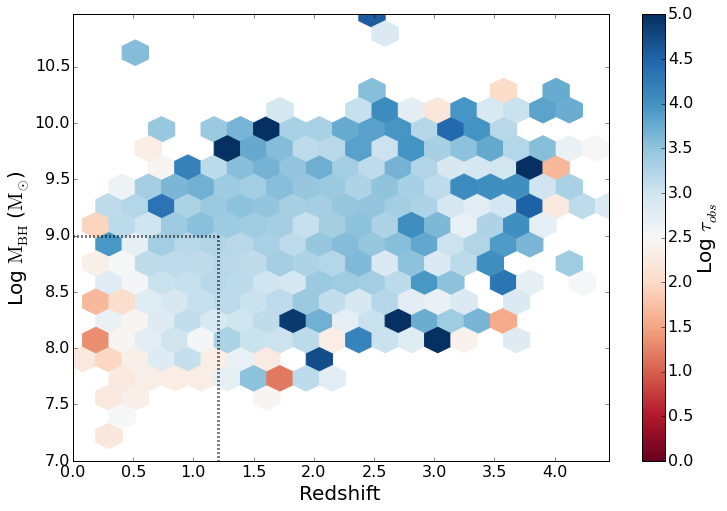

In [17]:
#my results
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy import stats, linalg

infor=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_40_11_5.txt')

ind=np.where((infor[:,2] >0)&(infor[:,3] >0)& (infor[:,3] < 1000000) ,True,False )
#ind2=np.where((infor[:,5] >0)&(infor[:,7] >0)&(infor[:,7] <5)& (infor[:,5] < 9 )&(infor[:,3]<1.2) ,True,False )
print 'ind',np.sum(ind)

ind=ind


Mbh=infor[ind,9]
z=infor[ind,1]
tau=np.log10(infor[ind,3])#-np.log10(1+z)
print np.median(tau)

fig=plt.figure(figsize=(12,8))
plt.hexbin(z, Mbh, C=tau, gridsize=20, marginals=False, cmap=plt.cm.RdBu,vmax=5, vmin=0)
cb = plt.colorbar()
cb.set_label(r'Log $\tau_{obs}$')

plt.plot([0,1.2],[9.,9.],'k:')
plt.plot([1.2,1.2],[7,9.],'k:')

plt.xlabel(r'Redshift')
plt.ylabel(r'Log $\rm M_{BH}$ ($\rm M_{\odot}$)')
plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/selection_all.eps')

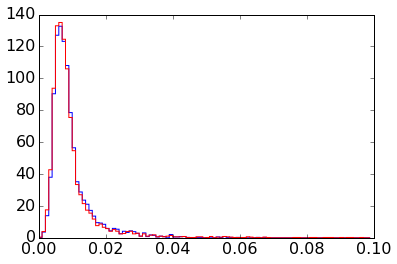

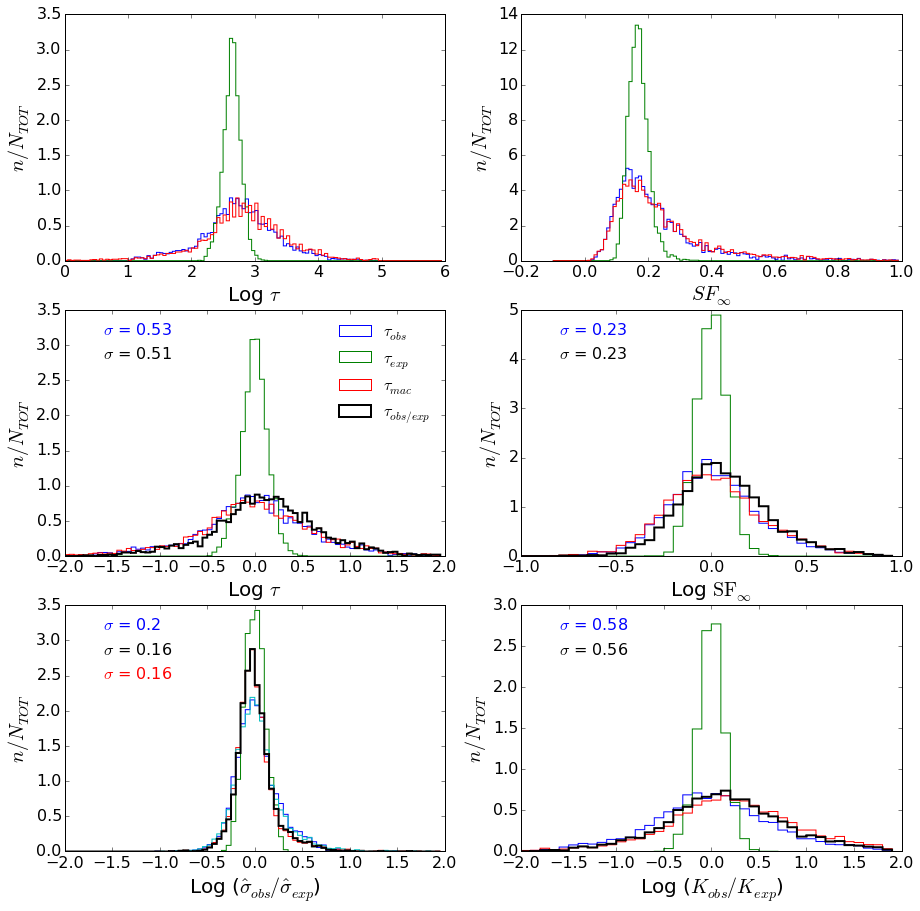

In [306]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

def corr(wave_rf, M_i, M_bh,z):
    log_SF=-0.51-0.479*np.log10(wave_rf/4000.)+0.131*(M_i+23)+0.18*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    log_tau=2.4+0.17*np.log10(wave_rf/4000.)+0.03*(M_i+23)+0.21*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    return log_SF,log_tau


mac=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/s82drw/s82drw_r.dat')
im=np.where((mac[:,7] < 5.) & (np.power(10,mac[:,8]) > 0.01 ),True,False)


mac_z=mac[im,3]
mac_tau=np.power(10,mac[im,7])
mac_SF=np.power(10,mac[im,8])*np.sqrt(mac_tau/365.)





#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un3.txt') 
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_1d_err.txt')
#name,redshift,sigobs_m,tauobs_m,psig,ptau,sigobs_l,sigobs_u,tauobs_l,tauobs_u,Lbest,L0,Linf
ind=np.array(np.where((data[:,3] < 99990.)& (data[:,5] < 99990.) & ((data[:,6]-data[:,7]) > 2.))).reshape(-1,)
#ind=np.where((data[:,3] < 99990.)& (data[:,5] < 99990.) & ((data[:,6]-data[:,7]) > 2.)\
#             &(data[:,4] > 0.0)  &((data[:,6]-data[:,8]) >0.05) &((data[:,6]-data[:,7]) >2))
tau_in=(data[ind,3])
SF_in=data[ind,2]*1.414


infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
index1=np.array(np.where(((infor[:,7]) !=0.0) & (infor[:,5] < -5 ) )).reshape(-1,)

a=infor[index1,:]
b=data[ind,:]
#print infor[index1,0],data[ind,0]

idx_infor=np.in1d(infor[index1,0],data[ind,0])
idx_data=np.in1d(data[ind,0],infor[index1,0])
#print np.sum(idx_infor),np.sum(idx_data)
idx_inf=np.in1d(infor[index1,3],mac[im,0])
idx_mac=np.in1d(mac[im,0],infor[index1,3])
#print np.sum(idx_mac),np.sum(idx_inf)

#print len(mac_tau)
mac_tau=mac_tau[idx_mac]
mac_SF=mac_SF[idx_mac]
mac_sig=mac_SF/np.sqrt(mac_tau)
mac_K=mac_tau*np.sqrt(mac_SF)
#print len(mac_tau)


M_i=a[idx_infor,5]
M_bh=a[idx_infor,7]#+np.random.normal(0,0.3,len(M_bh))
#plt.hist(M_bh)
z=a[idx_infor,6]
wave_rf=6231./(1+z)   # u:3543 g:4770，r:6231,i:7625,z:9134

M_i_mac=a[idx_inf,5]
M_bh_mac=a[idx_inf,7]#+np.random.normal(0,0.3,len(M_bh))
#plt.hist(M_bh)
z_mac=a[idx_inf,6]
wave_rf_mac=6231./(1+z_mac)   # u:3543 g:4770，r:6231,i:7625,z:9134


SF_exp,tau_exp=np.array(corr(wave_rf,M_i,M_bh,z))
tau_exp=np.power(10,tau_exp)*(1.+z)
SF_exp=np.power(10,SF_exp)

sig_exp=SF_exp/np.sqrt(tau_exp)
K_exp=tau_exp*np.sqrt(SF_exp)

SF_exp_mac,tau_exp_mac=np.array(corr(wave_rf_mac,M_i_mac,M_bh_mac,z_mac))
tau_exp_mac=np.power(10,tau_exp_mac)*(1.+z_mac)
SF_exp_mac=np.power(10,SF_exp_mac)

sig_exp_mac=SF_exp_mac/np.sqrt(tau_exp_mac)
K_exp_mac=tau_exp_mac*np.sqrt(SF_exp_mac)


tau_mean=np.zeros(len(K_exp))
SF_mean=np.zeros_like(tau_mean)
sig_mean=np.zeros_like(tau_mean)
K_mean=np.zeros_like(tau_mean)

tau_mean=tau_in[idx_data]
SF_mean=SF_in[idx_data]
#print SF_mean[0:10]
sig_mean=SF_mean/np.sqrt(tau_mean)
K_mean=tau_mean*np.sqrt(SF_mean)

plt.subplot(111)
bin3=np.arange(0,0.1,0.001)
plt.hist(sig_mean,bin3,histtype='step',normed=True,label=r'$\tau_{obs}$')
plt.hist(mac_sig,bin3,histtype='step',normed=True,color='red',label=r'$\tau_{obs}$')

#-----------------------figure--------------------------\
fig=plt.figure(figsize=(15,15))

plt.subplot(321)
bin3=np.arange(0,6,0.05)
plt.hist(list(np.log10(tau_mean)),bin3,histtype='step',normed=True,label=r'$\tau_{obs}$')
plt.hist(list(np.log10(tau_exp)),bin3,histtype='step',normed=True,label=r'$\tau_{exp}$')
plt.hist(list(np.log10(mac_tau)),bin3,histtype='step',normed=True,label=r'$\tau_{mac}$')
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')

plt.subplot(322)
bin3=np.arange(-0.1,1,0.01)
plt.hist(list((SF_mean)),bin3,histtype='step',normed=True,label=r'$SF_{obs}$')
plt.hist(list((SF_exp)),bin3,histtype='step',normed=True,label=r'$SF_{exp}$')
plt.hist(list(mac_SF),bin3,histtype='step',normed=True,label=r'$SF_{mac}$')
plt.xlabel(r'$SF_{\infty}$')
plt.ylabel(r'$n/N_{TOT}$')

ax=plt.subplot(323)
bin3=np.arange(-2,2,0.05)
plt.hist(list(np.log10(tau_mean/np.median(tau_mean))),bin3,histtype='step',normed=True,label=r'$\tau_{obs}$')
plt.hist(list(np.log10(tau_exp/np.median(tau_exp))),bin3,histtype='step',normed=True,label=r'$\tau_{exp}$')
plt.hist(list(np.log10(mac_tau/np.median(mac_tau))),bin3,histtype='step',normed=True,label=r'$\tau_{mac}$')

plt.hist(list(np.log10(tau_mean/tau_exp)),bin3,histtype='step',normed=True,color='black',label=r'$\tau_{obs/exp}$',lw=2)
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':16},frameon=False)

sig_oi_sgm=(np.percentile(np.log10(tau_mean/tau_exp),(16,84))[1]-np.percentile(np.log10(tau_mean/tau_exp),(16,84))[0])*0.5
b=(np.percentile(np.log10(tau_mean/np.median(tau_mean)),(16,84))[1]-np.percentile(np.log10(tau_mean/np.median(tau_mean)),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sig_oi_sgm,2)),color='black',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.9,'$\sigma$ = '+str(round(b,2)),color='blue',transform = ax.transAxes,fontsize=16)


ax=plt.subplot(324)
bin3=np.arange(-1,1,0.05)
plt.hist(list(np.log10(SF_mean/np.median(SF_mean))),bin3,histtype='step',normed=True,label=r'$SF_{o}$')
plt.hist(list(np.log10(SF_exp/np.median(SF_exp))),bin3,histtype='step',normed=True,label=r'$SF_{e}$')
plt.hist(list(np.log10(mac_SF/np.median(mac_SF))),bin3,histtype='step',normed=True,label=r'$SF_{mac}$')
plt.hist(list(np.log10(SF_mean/SF_exp)),bin3,histtype='step',normed=True,color='black',label=r'$SF_{o/e}$',lw=2)
plt.xlabel(r'Log $ \rm SF_{\infty}$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)
sig_oi_sgm=(np.percentile(np.log10(SF_mean/SF_exp),(16,84))[1]-np.percentile(np.log10(SF_mean/SF_exp),(16,84))[0])*0.5
b=(np.percentile(np.log10(SF_mean/np.median(SF_mean)),(16,84))[1]-np.percentile(np.log10(SF_mean/np.median(SF_mean)),(16,84))[0])*0.5

plt.text(0.1,0.8,'$\sigma$ = '+str(round(sig_oi_sgm,2)),color='black',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.9,'$\sigma$ = '+str(round(b,2)),color='blue',transform = ax.transAxes,fontsize=16)


ax=plt.subplot(325)
bin3=np.arange(-2,2,0.05)
plt.hist(list(np.log10(sig_mean/np.median(sig_mean))),bin3,normed=True,histtype='step',label=r'obs')
plt.hist(list(np.log10(sig_exp/np.median(sig_exp))),bin3,normed=True,histtype='step',label=r'exp')
plt.hist(list(np.log10(mac_sig/sig_exp_mac)),bin3,normed=True,histtype='step',label=r'mac')
plt.hist(list(np.log10(mac_sig/np.median(mac_sig))),bin3,normed=True,histtype='step',label=r'mac')

plt.hist(list(np.log10(sig_mean/sig_exp)),bin3,normed=True,histtype='step',color='black',label=r'$\sigma_{obs}/\sigma_{exp}$',lw=2)
plt.xlabel(r'Log ($ \hat\sigma_{obs}/ \hat\sigma_{exp}$)')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)
sig_oi_sgm=(np.percentile(np.log10(sig_mean/sig_exp),(16,84))[1]-np.percentile(np.log10(sig_mean/sig_exp),(16,84))[0])*0.5
b=(np.percentile(np.log10(sig_mean/np.median(sig_mean)),(16,84))[1]-np.percentile(np.log10(sig_mean/np.median(sig_mean)),(16,84))[0])*0.5
c=(np.percentile(np.log10(mac_sig/sig_exp_mac),(16,84))[1]-np.percentile(np.log10(mac_sig/sig_exp_mac),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sig_oi_sgm,2)),color='black',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.9,'$\sigma$ = '+str(round(b,2)),color='blue',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.7,'$\sigma$ = '+str(round(c,2)),color='red',transform = ax.transAxes,fontsize=16)


ax=plt.subplot(326)
bin3=np.arange(-2,2,0.1)
plt.hist(list(np.log10(K_mean/np.median(K_mean))),bin3,normed=True,histtype='step',label=r'o')
plt.hist(list(np.log10(K_exp/np.median(K_exp))),bin3,normed=True,histtype='step',label=r'exp')
plt.hist(list(np.log10(mac_K/(K_exp_mac))),bin3,normed=True,histtype='step',label=r'mac')

plt.hist(list(np.log10(K_mean/K_exp)),bin3,normed=True,histtype='step',color='black', label=r'$K_{obs}/K_{exp}$',lw=2)
plt.xlabel(r'Log ($K_{obs}/K_{exp}$)')
plt.ylabel('$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)


K_me_sgm=(np.percentile(np.log10(K_mean/K_exp),(16,50))[1]-np.percentile(np.log10(K_mean/K_exp),(16,50))[0])
#print K_me_sgm
b=(np.percentile(np.log10(K_mean/np.median(K_mean)),(16,50))[1]-np.percentile(np.log10(K_mean/np.median(K_mean)),(16,50))[0])
plt.text(0.1,0.8,'$\sigma$ = '+str(round(K_me_sgm,2)),color='black',transform = ax.transAxes,fontsize=16)
plt.text(0.1,0.9,'$\sigma$ = '+str(round(b,2)),color='blue',transform = ax.transAxes,fontsize=16)

#plt.savefig('test.eps')

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


tau 10.0050721452
Total number of photons: 1822597924.08
Total number of photons: 1829284160.46
SF_shift for -1: 4.2285331881
tau_shift for -1: 5.44651752808
Total number of photons: 1830053220.87
Total number of photons: 1840809520.44
s10,s20 0.933685216412 0.947203942445
SF_shift for -1.9: 1.00051470352
tau_shift for -1.9: 21.0194574915
0.0996345851433 0.102531537535 0.0971719947684
0.0979781165956 0.101988583568 0.0998678294892
Optimization terminated successfully.
         Current function value: -706.549008
         Iterations: 39
         Function evaluations: 74
Best-fit parameters are:
sigma    0.094 tau   10.864
with logp      706.55 
p0: [  0.094  10.864]
Optimization terminated successfully.
         Current function value: -876.519297
         Iterations: 39
         Function evaluations: 75
Best-fit parameters are:
sigma    0.123 tau   92.071
with logp      876.52 
p1: [  0.123  92.071]
correctted p1 0.0734499408978 4.38026690083
Optimization terminated successfully.
     

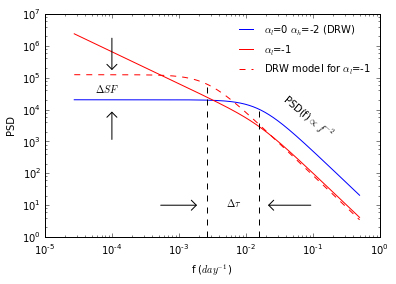

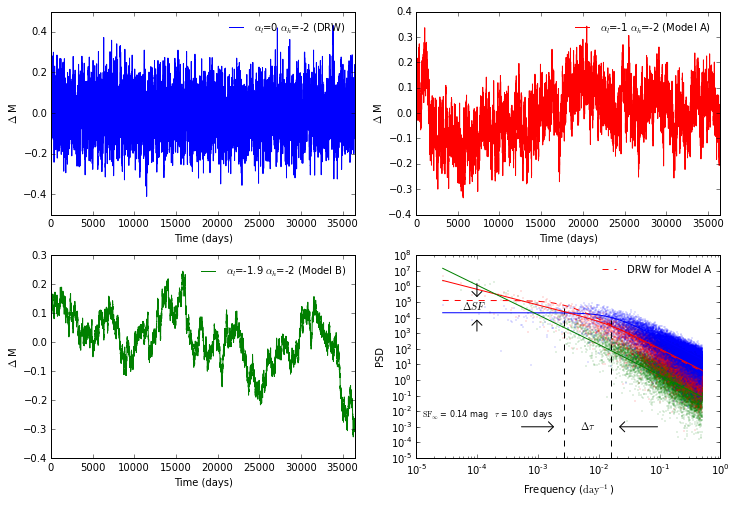

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyLCSIM
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
from scipy.integrate import simps
from matplotlib.pyplot import gca


rate_src = 50000.0
rate_bkg = 3000.0
t_exp = 36500.0
dt = 1.
frms=0.1


nbins = long(t_exp/dt)
fbreak=1./(2*np.pi*10.)
fb=np.log10(fbreak)
tau=1/(6.28*fbreak)
print 'tau',1/(6.28*fbreak)

# Instantiate a simulation object
sim = pyLCSIM.Simulation()
# Add two PSD models: a smooth broken power law and a Lorentzian representing a QPO.
# See the documentation for details.
sim.addModel('smoothbknpo', [1,0, 2, fbreak])

# Run the simulation
sim.run(dt, nbins, rate_src, rms=frms)
# Get lightcurve and power spectrum as 1-D arrays
time, rate = sim.getLightCurve()
f, psd = sim.getPowerSpectrum()
freq_m, model_tot, model_comp = sim.getPSDModel(dt, nbins, freq=100000)
model_tot = model_tot / simps(model_tot, freq_m) * simps(psd, f)
plt.ylabel('PSD')
plt.xlabel('f ($day^{-1}$)')

y4=np.log10(model_tot[0])
#print 'y4',y4


a=[]
b=[]
c=[]
#for i in range(100):
#---------------------------------------------------
sim1=pyLCSIM.Simulation()
sim1.addModel('smoothbknpo', [1,1, 2,fbreak])
sim1.run(dt, nbins, rate_src, rms=frms)
time1, rate1 = sim1.getLightCurve()
f1, psd1 = sim1.getPowerSpectrum()
freq_m1, model_tot1, model_comp1 = sim1.getPSDModel(dt, nbins, freq=100000)
model_tot1 = model_tot1 / simps(model_tot1, freq_m1) * simps(psd1, f1)
s10=np.sum(model_tot1)/np.sum(model_tot)
#plt.loglog(freq_m1, model_tot1/s10,color='red')

y2=np.log10(model_tot1[0]/s10)
y3=np.log10(model_tot1[np.searchsorted(freq_m1, fbreak)])
print 'SF_shift for -1:',10**(0.5*(y2+y3))/(10**y4)
print 'tau_shift for -1:',1./(10.**(fb-0.5*(0.5*(y2+y3)-y3)))/(1./fbreak)


sim22=pyLCSIM.Simulation()
sim22.addModel('smoothbknpo', [1,0., 2, fbreak/6.])
sim22.run(dt, nbins, rate_src, rms=0.10)
time22, rate22 = sim22.getLightCurve()
f22, psd22 = sim22.getPowerSpectrum()
freq_m22, model_tot22, model_comp22 = sim22.getPSDModel(dt, nbins, freq=100000)
model_tot22 = model_tot22 / simps(model_tot22, freq_m22) * simps(psd22, f22)

#plt.loglog(freq_m2, model_tot2/s20,color='green')
#plt.loglog(freq_m2, model_tot2,color='green',ls='-')
#print np.sum( model_tot), np.sum(model_tot1), np.sum(model_tot2)


##############------------deviation----------------

ax=plt.subplot(111)
plt.loglog(freq_m, model_tot,color='blue',label=r'$\alpha_{l}$=0 $\alpha_{h}$=-2 (DRW)')
plt.loglog(freq_m1, model_tot1,color='red',ls='-',label=r'$\alpha_{l}$=-1')
plt.plot([fbreak,fbreak],[1,1.e4],'k--')
plt.loglog(freq_m22, model_tot22,color='red',ls='--',label=r'DRW model for $\alpha_{l}$=-1')
plt.plot([fbreak/6.,fbreak/6.],[1,6.e4],'k--')
plt.text(0.15, 0.65, r'$\Delta SF$',transform=ax.transAxes )
plt.text(0.54, 0.14, r'$\Delta \tau$',transform=ax.transAxes )
plt.legend(prop={'size':10},frameon=False)
ax  = gca()
opt = dict(color='k',arrowstyle = '->,head_width=.25,head_length=.25')
a1  = gca().annotate('',xy=(1e-4,1e4),xycoords='data',xytext =(1e-4,1e3),textcoords = 'data',arrowprops=opt,size=20)
a2  = gca().annotate('',xy=(1e-4,1.5e5), xycoords='data',xytext =(1e-4,2e6),textcoords = 'data',arrowprops=opt,size=20)

a3  = gca().annotate('',xy=(2e-3,10),xycoords='data',xytext =(5e-4,10),textcoords = 'data',arrowprops=opt,size=20)
a4  = gca().annotate('',xy=(2e-2,10), xycoords='data',xytext =(1e-1,10),textcoords = 'data',arrowprops=opt,size=20)
plt.text(0.7, 0.6, r'PSD(f)$\propto$ $f^{-2}$',rotation=-40,transform=ax.transAxes )


#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/deviation.eps')
################################################
sim2=pyLCSIM.Simulation()
sim2.addModel('smoothbknpo', [1,1.9, 2, fbreak])
sim2.run(dt, nbins, rate_src, rms=0.14)
time2, rate2 = sim2.getLightCurve()
f2, psd2 = sim2.getPowerSpectrum()
freq_m2, model_tot2, model_comp2 = sim2.getPSDModel(dt, nbins, freq=100000)
model_tot2 = model_tot2 / simps(model_tot2, freq_m2) * simps(psd2, f2)
s20=np.sum(model_tot2)/np.sum(model_tot)
print 's10,s20',s10,s20
y2=np.log10(model_tot2[0]/s20)
y3=np.log10(model_tot2[np.searchsorted(freq_m2, fbreak)])
print 'SF_shift for -1.9:',10**(0.5*(y2+y3)/10**y4)
print 'tau_shift for -1.9:',1./(10.**(fb-0.5*(0.5*(y2+y3)-y3)))/(1./fbreak)


fig=plt.figure(figsize=(12,8))
fig0 = plt.subplot(221)
plt.plot(time, rate/rate_src-1.,label=r'$\alpha_{l}$=0 $\alpha_{h}$=-2 (DRW)',rasterized=False)
plt.xlabel("Time (days)")
plt.ylabel(r'$\Delta$ M')
plt.xlim(0,36500)
plt.legend(prop={'size':10},frameon=False)

fig1 = plt.subplot(222)
plt.plot(time1, rate1/rate_src-1.,'r',label=r'$\alpha_{l}$=-1 $\alpha_{h}$=-2 (Model A)' ,rasterized=False )
plt.xlabel("Time (days)")
plt.ylabel(r'$\Delta$ M')
plt.xlim(0,36500)
plt.legend(prop={'size':10},frameon=False)

fig2 = plt.subplot(223)
plt.plot(time2, rate2/rate_src-1.,'g',label=r'$\alpha_{l}$=-1.9 $\alpha_{h}$=-2 (Model B)',rasterized=False)
plt.xlabel("Time (days)")
plt.ylabel(r'$\Delta$ M')
plt.xlim(0,36500)
plt.legend(prop={'size':10},frameon=False)

 
print np.std(rate/rate_src-1.),np.std(rate1/rate_src-1.),np.std(rate2/rate_src-1.)
print np.std(rate[0:3650]/rate_src-1.), np.std(rate[3650:3650*2]/rate_src-1.),np.std(rate[3650*5:3650*6]/rate_src-1.)



#----------fit the light curve------------
ind0=np.arange(0,3650,10)
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',\
           np.c_[time[ind0], rate[ind0]/rate_src-1.,np.zeros(len(ind0))])
javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
cont = Cont_Model(javdata)
aa0=[np.log(0.16/1.414),np.log(470)]
p0=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
print 'p0:',p0



np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',\
           np.c_[time1[ind0], rate1[ind0]/rate_src-1.,np.zeros(len(ind0))])
javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
cont = Cont_Model(javdata)

p1=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
print 'p1:',p1
print 'correctted p1',p1[0]/(10**(0.5*(y2+y3))/(10**y4)),p1[1]/(1./(10.**(fb-0.5*(0.5*(y2+y3)-y3)))/(1./fbreak))


np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',\
           np.c_[time[ind0], rate2[ind0]/rate_src-1.,np.zeros(len(ind0))])
javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
cont = Cont_Model(javdata)

p2=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
print 'p2:',p2
print 'correctted p2',p2[0]/(10**(0.5*(y2+y3))/(10**y4)),p2[1]/(1./(10.**(fb-0.5*(0.5*(y2+y3)-y3)))/(1./fbreak))

#------------------------------------------

ax=plt.subplot(224)
#plt.loglog(f, psd/rate_src, drawstyle='steps-mid', color='black')


plt.plot(f2,psd2,'g.',markersize=0.5,rasterized=False)
plt.plot(f1,psd1,'r.',markersize=0.5,rasterized=False)
plt.plot(f,psd,'b.',markersize=0.5,rasterized=False)
plt.plot([fbreak,fbreak],[-1.e10,1.e4],'k--')
plt.plot([fbreak/6.,fbreak/6.],[-1.e10,1.e5],'k--')
plt.loglog(freq_m, model_tot,color='blue')
plt.loglog(freq_m1, model_tot1,color='red')
plt.loglog(freq_m2, model_tot2,color='green')
plt.text(0.02, 0.2, r'$\rm SF_{\infty}$ = 0.14'+\
         r' mag   $\rm \tau$ = '+np.str(round(tau,1))+r'  days',transform=ax.transAxes,size=8 )
plt.ylim(1.e-5,1.e8)
plt.loglog(freq_m22, model_tot22,color='red',ls='--',label=r'DRW for Model A')
ax  = gca()
opt = dict(color='k',arrowstyle = '->,head_width=.25,head_length=.25')
a1  = gca().annotate('',xy=(1e-4,1e4),xycoords='data',xytext =(1e-4,1e3),textcoords = 'data',arrowprops=opt,size=20)
a2  = gca().annotate('',xy=(1e-4,1.5e5), xycoords='data',xytext =(1e-4,2e6),textcoords = 'data',arrowprops=opt,size=20)

a3  = gca().annotate('',xy=(2e-3,0.001),xycoords='data',xytext =(5e-4,0.001),textcoords = 'data',arrowprops=opt,size=20)
a4  = gca().annotate('',xy=(2e-2,0.001), xycoords='data',xytext =(1e-1,0.001),textcoords = 'data',arrowprops=opt,size=20)
#plt.text(0.7, 0.6, r'PSD(f)$\propto$ $f^{-2}$',rotation=-40,transform=ax.transAxes )    

plt.text(0.15, 0.73, r'$\Delta SF$',transform=ax.transAxes )
plt.text(0.54, 0.14, r'$\Delta \tau$',transform=ax.transAxes )
plt.legend(prop={'size':10},frameon=False)

'''

x=np.arange(0.027,5,0.01)
y=x**(-2)*0.000729
plt.plot(x,y,'r')
plt.plot(x,y,'b--')
plt.plot([0.001,0.027],[1,1],'b--')
plt.plot(x,y,'g:')

x1=np.arange(0.001,0.027,0.001)
y=x1**(-2)*0.000729
plt.plot(x1,y,'g:')
y2=x1**(-1)*0.027
plt.plot(x1,y2,'r')
'''

plt.yscale('log')
plt.xscale('log')
plt.xlim(0.001*0.01,1.)

plt.xlabel(r'Frequency ($\rm day^{-1}$)')
plt.ylabel("PSD")
plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/nondrw012.eps')



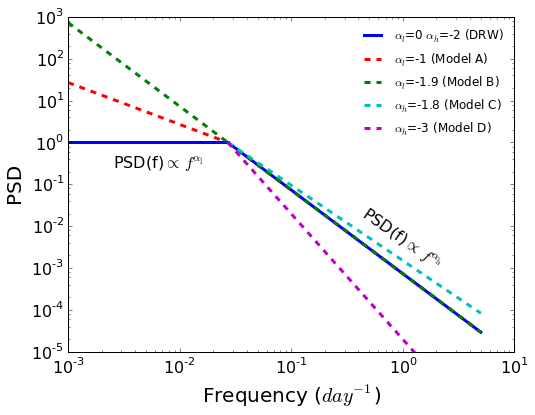

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('my')


fig=plt.figure(figsize=(8,6))
ax1=plt.subplot(111)
#------012----------------
x=np.arange(0.027,5,0.01)
y=x**(-2)*0.000729
plt.loglog(x,y,'r--')
plt.plot(x,y,'b')
plt.plot([0.001,0.027],[1,1],'b',label=r'$\alpha_{l}$=0 $\alpha_{h}$=-2 (DRW)')
plt.plot(x,y,'g--')
plt.ylim(1.e-5,1.e3)
plt.xlim(1.e-3,1.e1)

x1=np.arange(0.001,0.027,0.001)

y2=x1**(-1)*0.027
plt.plot(x1,y2,'r--',label=r'$\alpha_{l}$=-1 (Model A)')
y=x1**(-2)*0.000729
plt.plot(x1,y,'g--',label=r'$\alpha_{l}$=-1.9 (Model B)')

#--------1.8,2.2---------

x1=np.arange(0.027,5.,0.001)
y=x1**(-1.8)*0.0015
plt.plot(x1,y,'c--',label=r'$\alpha_{h}$=-1.8 (Model C)')
y2=x1**(-3.)*0.027**3
plt.plot(x1,y2,'m--',label=r'$\alpha_{h}$=-3 (Model D)')
plt.legend(frameon=False)
plt.text(0.1, 0.55, r'PSD(f)$\propto$ $f^{\rm\alpha_{l}}$',transform=ax1.transAxes,fontsize=16 )
plt.text(0.65, 0.4, r'PSD(f)$\propto$ $f^{\rm \alpha_{h}}$',rotation=-35,transform=ax1.transAxes,fontsize=16 )
plt.xlabel(r"Frequency ($day^{-1}$)")
plt.ylabel("PSD")
plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/demo.eps')

8845
Optimization terminated successfully.
         Current function value: -138.930586
         Iterations: 31
         Function evaluations: 62
Best-fit parameters are:
sigma    0.068 tau   79.203
with logp      138.93 
79.2026949539
Optimization terminated successfully.
         Current function value: -187.367797
         Iterations: 37
         Function evaluations: 68
Best-fit parameters are:
sigma    0.076 tau  178.570
with logp      187.37 
Optimization terminated successfully.
         Current function value: -212.687092
         Iterations: 35
         Function evaluations: 70
Best-fit parameters are:
sigma    0.045 tau  163.042
with logp      212.69 
Optimization terminated successfully.
         Current function value: -260.842235
         Iterations: 84
         Function evaluations: 162
Best-fit parameters are:
sigma    0.201 tau 99998.759
with logp      260.84 
Optimization terminated successfully.
         Current function value: -131.382808
         Iterations: 47
    

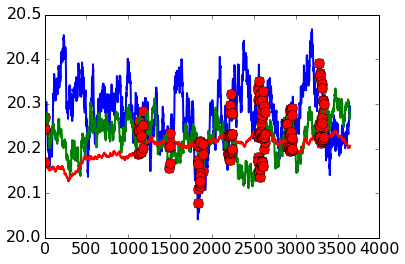

In [45]:
# 8807 logarithm proir distr.....obs input and sim output   no mcmc just one valu with UNiform prior
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
import pyLCSIM
stime=datetime.datetime.now()



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))
index1=np.array(np.where(((infor[:,7]) !=1.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))

#print len(all_file) #9258
ID=infor[index,0]
z=infor[index,6]

#M_i=infor[index,5]
#M_bh=infor[index,7]
#wave_rf=6231./(1.+z)

#plt.hist(M_bh)



sigobs_m=[]
tauobs_m=[]


psig=[]
ptau=[]
psig1=[]
ptau1=[]
psig2=[]
ptau2=[]

name=[]
redshift=[]
L0=[]
Lbest=[]
Linf=[]

time_new=np.arange(0,365*10,1)

error_new=np.abs(np.random.normal(0,0.01,3650))
a=len(all_file[index])
print a


for i in range(len(all_file[index])-a+1):
    data=np.genfromtxt(str(all_file[index][i]))

    #here i change to r band so i means r
    mag_i=data[:,7]
    index_i=np.where((mag_i>0) &(mag_i<30))
    mag_i=mag_i[index_i]
    mu=np.mean(mag_i)
    mag_i_err=data[:,8]
    mag_i_err=mag_i_err[index_i]
    mjd_i=data[index_i,6]
    time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
    idx=time.astype(int)


     # -----fit the observed light curve
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[np.array(time), mag_i,mag_i_err])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont = Cont_Model(javdata)
    aa0=[np.log(0.16/1.414),np.log(470)]
    p0=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
    
    #cont.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
                 #fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chainobs/chainobs_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likeliobs/likeli_"+str(all_file[index][i])+".txt")
    print p0[1]
    if p0[0] > 1.:
        
        continue
    name.append(all_file[index][i])
    redshift.append(z[i])

    sigobs_m.append((p0[0]))
    tauobs_m.append((p0[1]))
    
    #------------------use obs tau and sig to produce powerlaw (0,-1,2) lc. --------------------------------
   

    rate_src = 50000.0
    rate_bkg = 3000.0
    t_exp = 36500.0
    dt = 1.
    frms = p0[0]
    freq_br=1/(2*np.pi*p0[1])
    nbins = long(t_exp/dt)
    
    #--drw---
    sim = pyLCSIM.Simulation()
    sim.addModel('smoothbknpo', [1,0, 2, freq_br])
    sim.run(dt, nbins, rate_src, rms=frms)
    time_sim, rate = sim.getLightCurve()
    rate=rate/rate_src-1.+mu
    
    #--alpha =-1
    sim1 = pyLCSIM.Simulation()
    sim1.addModel('smoothbknpo', [1,1, 2, freq_br])
    sim1.run(dt, nbins, rate_src, rms=frms)
    time_sim1, rate1 = sim1.getLightCurve()
    rate1=rate1/rate_src-1.+mu
    
    #-- alpha =-2
    sim2 = pyLCSIM.Simulation()
    sim2.addModel('smoothbknpo', [1,1.9, 2, freq_br])
    sim2.run(dt, nbins, rate_src, rms=frms)
    time_sim2, rate2 = sim2.getLightCurve()
    rate2=rate2/rate_src-1.+mu
    
    
    

    #---------obs as the input and get a new obs_output with 5days spaced 10yrs light cuvre with 0.01mag error.
    #X1=TM.generate_damped_RW(time_new, tau=p0[1], z=0., xmean=mu, SFinf=p0[0], random_state=None) #0.113
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate[idx],error_new[idx]])
    plt.plot(time_sim[:3650],rate[:3650])
    plt.plot(time,rate[idx],'ro')
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont2 = Cont_Model(javdata)
    aa=[np.log(p0[0]),np.log(p0[1])]
    p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    psig.append(p[0])
    ptau.append(p[1])
    
    #------alpha=-1
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate1[idx],error_new[idx]])
    plt.plot(time_sim[:3650],rate1[:3650])
    plt.plot(time,rate1[idx],'ro')
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont21 = Cont_Model(javdata)
    p=np.exp(np.array(cont21.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    psig1.append(p[0])
    ptau1.append(p[1])
    
    #------alpha=-1.9
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate2[idx],error_new[idx]])
    plt.plot(time_sim[:3650],rate2[:3650])
    plt.plot(time,rate2[idx],'ro')
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont22 = Cont_Model(javdata)
    p=np.exp(np.array(cont22.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    psig2.append(p[0])
    ptau2.append(p[1])
    
    
    



    # find Linf L0 Lbest-----------------------------------
    tau0=[np.log(p[0]),0.0]
    l0=cont2.do_map(tau0,fixed=[1,0],set_prior=False)[1]
    L0.append(l0)
    tauinf=[np.log(p[0]),20.]
    linf=cont2.do_map(tauinf,fixed=[1,0],set_prior=False)[1]
    Linf.append(linf)
    lbest=cont2.do_map([np.log(p[0]),np.log(p[1])],fixed=[0,0],set_prior=False)[1]
    Lbest.append(lbest)

    #print sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2
    print i,  all_file[index][i]
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/un_nondrw.txt',\
           np.c_[name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,\
                 Lbest,L0,Linf],fmt='%4.3f')

print 'successed!'
etime=datetime.datetime.now()
print etime-stime


In [ ]:
# NonDRW with MCMC
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
import pyLCSIM
stime=datetime.datetime.now()



infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))
index1=np.array(np.where(((infor[:,7]) !=1.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))

#print len(all_file) #9258
ID=infor[index,0]
z=infor[index,6]

#M_i=infor[index,5]
#M_bh=infor[index,7]
#wave_rf=6231./(1.+z)

#plt.hist(M_bh)



sigobs_m=[]
tauobs_m=[]


psig=[]
ptau=[]
psig1=[]
ptau1=[]
psig2=[]
ptau2=[]

name=[]
redshift=[]
L0=[]
Lbest=[]
Linf=[]

time_new=np.arange(0,365*10,1)

error_new=np.abs(np.random.normal(0,0.01,3650))
a=len(all_file[index])
print a


for i in range(len(all_file[index])-a+1):
    data=np.genfromtxt(str(all_file[index][i]))

    #here i change to r band so i means r
    mag_i=data[:,7]
    index_i=np.where((mag_i>0) &(mag_i<30))
    mag_i=mag_i[index_i]
    mu=np.mean(mag_i)
    mag_i_err=data[:,8]
    mag_i_err=mag_i_err[index_i]
    mjd_i=data[index_i,6]
    time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
    idx=time.astype(int)


     # -----fit the observed light curve
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[np.array(time), mag_i,mag_i_err])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont = Cont_Model(javdata)
    #aa0=[np.log(0.16/1.414),np.log(470)]
    #p0=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))
    
    cont.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
                 #fchain="/home/hxguo/lightcurve/SF_test/para/javelin/chainobs/chainobs_"+str(all_file[index][i])+".txt",\
                 #flogp="/home/hxguo/lightcurve/SF_test/para/javelin/likeliobs/likeli_"+str(all_file[index][i])+".txt")
    if np.exp(cont.hpd[1,1]) > 1.:
        
        continue
    name.append(all_file[index][i])
    redshift.append(z[i])

    sigobs_m.append(np.exp(cont.hpd[1,0]))
    tauobs_m.append(np.exp(cont.hpd[1,1]))
    
    #------------------use obs tau and sig to produce powerlaw (0,-1,2) lc. --------------------------------
   

    rate_src = 50000.0
    rate_bkg = 500.0
    t_exp = 36500.0
    dt = 1.0
    frms = np.exp(cont.hpd[1,0])
    freq_br=1/(2*np.pi*np.exp(cont2.hpd[1,1]))
    nbins = long(t_exp/dt)
    
    #--drw---
    sim = pyLCSIM.Simulation()
    sim.addModel('smoothbknpo', [1,0, 2, freq_br])
    sim.run(dt, nbins, rate_src, rms=frms)
    #sim.poissonRandomize(dt, rate_bkg)
    time_sim, rate = sim.getLightCurve()
    rate=rate/rate_src-1.+mu
    
    #--alpha =-1
    sim1 = pyLCSIM.Simulation()
    sim1.addModel('smoothbknpo', [1,1, 2, freq_br])
    sim1.run(dt, nbins, rate_src, rms=frms)
    time_sim1, rate1 = sim1.getLightCurve()
    rate1=rate1/rate_src-1.+mu
    
    #-- alpha =-2
    sim2 = pyLCSIM.Simulation()
    sim2.addModel('smoothbknpo', [1,1.9, 2, freq_br])
    sim2.run(dt, nbins, rate_src, rms=frms)
    time_sim2, rate2 = sim2.getLightCurve()
    rate2=rate2/rate_src-1.+mu
    
    
    

    #---------obs as the input and get a new obs_output with 5days spaced 10yrs light cuvre with 0.01mag error.
    #X1=TM.generate_damped_RW(time_new, tau=p0[1], z=0., xmean=mu, SFinf=p0[0], random_state=None) #0.113
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate[idx],error_new[idx]])
    plt.plot(time_sim[:3650],rate[:3650])
    plt.plot(time,rate[idx],'ro')
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont2 = Cont_Model(javdata)
    #aa=[np.log(p0[0]),np.log(p0[1])]
    #p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    cont2.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
    psig.append(np.exp(cont2.hpd[1,0]))
    ptau.append(np.exp(cont2.hpd[1,1]))
    
    #------alpha=-1
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate1[idx],error_new[idx]])
    plt.plot(time_sim[:3650],rate1[:3650])
    plt.plot(time,rate1[idx],'ro')
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont21 = Cont_Model(javdata)
    #p=np.exp(np.array(cont21.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    cont21.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
    psig1.append(np.exp(cont21.hpd[1,0]))
    ptau1.append(np.exp(cont21.hpd[1,1]))
    
    #------alpha=-1.9
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate2[idx],error_new[idx]])
    plt.plot(time_sim[:3650],rate2[:3650])
    plt.plot(time,rate2[idx],'ro')
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
    cont22 = Cont_Model(javdata)
    #p=np.exp(np.array(cont22.do_map(aa,fixed=[1,1],set_prior=False)[0]))
    cont22.do_mcmc(taulimit='baseline',set_verbose=False,set_prior=False)
    psig2.append(np.exp(cont22.hpd[1,0]))
    ptau2.append(np.exp(cont22.hpd[1,1]))
    
    
    



    # find Linf L0 Lbest-----------------------------------
    tau0=[np.log(np.exp(cont2.hpd[1,0])),0.0]
    l0=cont2.do_map(tau0,fixed=[1,0],set_prior=False)[1]
    L0.append(l0)
    tauinf=[np.log(np.exp(cont2.hpd[1,0])),20.]
    linf=cont2.do_map(tauinf,fixed=[1,0],set_prior=False)[1]
    Linf.append(linf)
    lbest=cont2.do_map([np.log(np.exp(cont2.hpd[1,0])),np.log(np.exp(cont2.hpd[1,1]))],fixed=[0,0],set_prior=False)[1]
    Lbest.append(lbest)

    #print sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2
    print i,  all_file[index][i]
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nondrw012_mcmc.txt',\
           np.c_[name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,\
                 Lbest,L0,Linf],fmt='%4.3f')

print 'successed!'
etime=datetime.datetime.now()
print etime-stime


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:61: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labe

---- 624.627 547.167 810.045 1221.723
---- 0.20163 0.16356 0.12549 0.0705
7743


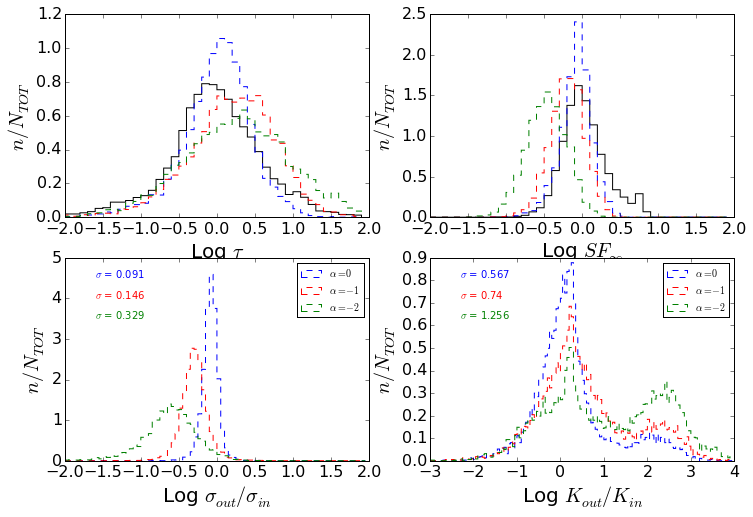

In [74]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm


data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw.txt') 
#ghx_nodrw2_c_drw_avdrw_poly_surface_all.txt
#ghx_nodrw_c_drw_avdrw.txt
#nodrw2 is [0,-1.8],[0,-2.2] 
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,Lbest,L0,Linf

'''
SF_f1=data[:,13]
tau_f1=data[:,14]
SF_f2=data[:,15]
tau_f2=data[:,16]
'''
#c0=data[:,17]
#c1=data[:,18]
#c2=data[:,19]
#rms=data[:,20]
#print c0,c1,c2
#print 'drw',np.median(c0),np.median(c1),np.median(c2)
#print '-1',np.median(SF_f1),np.median(tau_f1) 
#print '-2',np.median(SF_f2),np.median(tau_f2) 


sigobs_m=data[:,2]
tauobs_m=data[:,3]
psig=data[:,4]
ptau=data[:,5]

psig1=data[:,6]#/SF_f1#*c1#/1.5
ptau1=data[:,7]#/tau_f1#/np.median(tau_f1)#*1.8
psig2=data[:,8]#/SF_f2#*c2#*3.3#/1.5
ptau2=data[:,9]#/tau_f2#/np.median(tau_f2)#/3

'''


psig1=data[:,21]#-1.3
ptau1=data[:,22]
psig2=data[:,23]#-1.4
ptau2=data[:,24]


psig1=data[:,25]#-1.5
ptau1=data[:,26]

psig2=data[:,27]#-1.9
ptau2=data[:,28]
'''



tauobs_m[np.where((tauobs_m == 'inf') | (tauobs_m > 100000.), True, False)]=100000.
ptau[np.where((ptau == 'inf') | (ptau > 100000.), True, False)]=100000.
ptau1[np.where((ptau1 == 'inf') | (ptau1 > 100000.), True, False)]=100000.
tauobs_m[np.where( tauobs_m < 1., True, False)]=1.
ptau[np.where( ptau < 1., True, False)]=1.
ptau1[np.where( ptau1 < 1., True, False)]=1.
ptau2[np.where( ptau2 < 1., True, False)]=1.
ptau2[np.where((ptau2 == 'inf') | (ptau2 > 100000.), True, False)]=100000.
sigobs_m[np.where((sigobs_m == 0.0),True,False)]=0.01
psig[np.where((psig == 0.0),True,False)]=0.01
psig1[np.where((psig1 == 0.0),True,False)]=0.01
psig2[np.where((psig2 == 0.0),True,False)]=0.01



sigma_i=sigobs_m/np.sqrt(tauobs_m)
sigma=psig/np.sqrt(ptau)
sigma1=psig1/np.sqrt(ptau1)
sigma2=psig2/np.sqrt(ptau2)

K_i=tauobs_m*np.sqrt(sigobs_m)
K=ptau*np.sqrt(psig)
K1=ptau1*np.sqrt(psig1)
K2=ptau2*np.sqrt(psig2)

ii=np.where(tauobs_m < 10000)
i0=np.where(ptau < 10000.)
i=np.where((ptau1 < 10000.) &(psig2 >0.0001),True,False)
i2=np.where((ptau2 < 10000.) &(psig2 >0.0001),True,False)

print '----',np.median(tauobs_m[ii]),np.median(ptau[i0]),np.median(ptau1[i]),np.median(ptau2[i2])
print '----',np.median(sigobs_m[ii])*1.41,np.median(psig[i0])*1.41,np.median(psig1[i])*1.41,np.median(psig2[i2])*1.41
#print np.max(tauobs_m),np.min(sigobs_m)
#print np.min(ptau2),np.min(psig2)
#print np.median(ptau[i0]),np.median(ptau1[i]),np.median(ptau2[i2])
#print np.median(psig[i0]),np.median(psig1[i]),np.median(psig2[i2])
#print np.median(K_i),np.median(K),np.median(K1),np.median(K2)



fig=plt.figure(figsize=(12,8))

plt.subplot(221)
bin3=np.arange(-2.,2,0.1)
#plt.hist(list(np.log10(tauobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$')
#plt.hist(list(np.log10(ptau)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${\alpha=0}$')
#plt.hist(list(np.log10(ptau1)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${\alpha=-1}$')
#plt.hist(list(np.log10(ptau2)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${\alpha=-2}$')
plt.hist(np.log10(tauobs_m/np.median(tauobs_m)),bin3,histtype='step',normed=True,color='k')
plt.hist(list(np.log10(ptau[i0]/tauobs_m[i0])),bin3,histtype='step',normed=True,ls='dashed',color='blue')
plt.hist(list(np.log10(ptau1[i]/tauobs_m[i])),bin3,histtype='step',normed=True,ls='dashed',color='r')
plt.hist(list(np.log10(ptau2[i2]/tauobs_m[i2])),bin3,histtype='step',normed=True,ls='dashed',color='g')
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)

plt.subplot(222)
bin3=np.arange(-2,2,0.1)
#plt.hist(list(np.log10(sigobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$')
#plt.hist(list(np.log10(psig)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${\alpha=0}$')
#plt.hist(list(np.log10(psig1)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${\alpha=-1}$')
#plt.hist(list(np.log10(psig2)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${\alpha=-2}$')
plt.hist(np.log10(sigobs_m/np.median(sigobs_m)),bin3,histtype='step',normed=True,color='k')
plt.hist(list(np.log10(psig[i0]/sigobs_m[i0])),bin3,histtype='step',normed=True,ls='dashed',color='blue')
plt.hist(list(np.log10(psig1[i]/sigobs_m[i])),bin3,histtype='step',normed=True,ls='dashed',color='r')
plt.hist(list(np.log10(psig2[i2]/sigobs_m[i2])),bin3,histtype='step',normed=True,ls='dashed',color='g')
plt.xlabel(r'Log $SF_{\infty}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':10})#,frameon=False)

ax=plt.subplot(223)
bin3=np.arange(-2,2,0.05)
print len(sigma)
plt.hist(list(np.log10(sigma[i0]/sigma_i[i0])),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${\alpha=0}$')
plt.hist(list(np.log10(sigma1[i]/sigma_i[i])),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${\alpha=-1}$')
plt.hist(list(np.log10(sigma2[i2]/sigma_i[i2])),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${\alpha=-2}$')
#a=list(sigma[:3870]/sigma_i[:3870])
#b=list(sigma1[3870:7743]/sigma_i[3870:7743])
#c=a+b
#print len(c)
#plt.hist(list(np.log10(c)),bin3,histtype='step',normed=True,ls='dashed',color='yellow',label=r'${\alpha=0+-1}$')
plt.xlabel(r'Log $\sigma_{out}/\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':10})#,frameon=False)

#(fmu, fsigma) = norm.fit(np.log10(sigma[i0]/sigma_i[i0]))
#print 'fit sigma:',fsigma


sg0=(np.percentile(np.log10(sigma[i0]/sigma_i[i0]),(16,84))[1]-np.percentile(np.log10(sigma/sigma_i),(16,84))[0])*0.5
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax.transAxes)
sg1=(np.percentile(np.log10(sigma1[i]/sigma_i[i]),(16,84))[1]-np.percentile(np.log10(sigma1/sigma_i),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='red',transform = ax.transAxes)
sg2=(np.percentile(np.log10(sigma2[i2]/sigma_i[i2]),(16,84))[1]-np.percentile(np.log10(sigma2/sigma_i),(16,84))[0])*0.5
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='green',transform = ax.transAxes)


ax4=plt.subplot(224)
bin3=np.arange(-3,4,0.05)

plt.hist(list(np.log10(K/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${\alpha=0}$')
plt.hist(list(np.log10(K1/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${\alpha=-1}$')
plt.hist(list(np.log10(K2/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${\alpha=-2}$')


plt.xlabel(r'Log $K_{out}/K_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':10})#,frameon=False)
sg0=(np.percentile(np.log10(K/K_i),(16,50))[1]-np.percentile(np.log10(K/K_i),(16,50))[0])
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax4.transAxes)
sg1=(np.percentile(np.log10(K1/K_i),(16,50))[1]-np.percentile(np.log10(K1/K_i),(16,50))[0])
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='r',transform = ax4.transAxes)
sg2=(np.percentile(np.log10(K2/K_i),(16,50))[1]-np.percentile(np.log10(K2/K_i),(16,50))[0])
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='g',transform = ax4.transAxes)
#plt.figure()
#plt.hist(K_i[io],np.arange(0,1000.),histtype='step',normed=True,ls='dashed',color='blue',label=r'${\alpha=0}$')

#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/ghx_nodrw_10yr_noerr.eps')

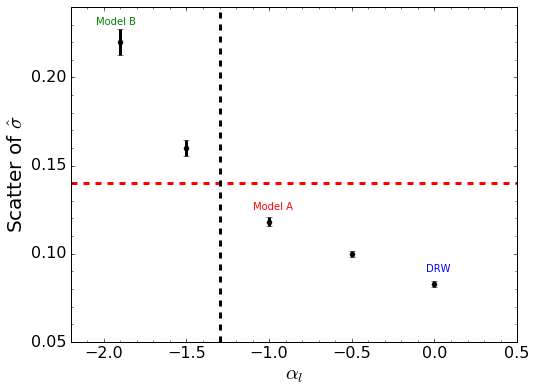

In [59]:
'''
x=[0,-0.5,-1,-1.2,-1.3,-1.4,-1.5,-1.9]
y1=[0.098,0.115,0.13,0.138,0.176,0.187,0.183,0.213]
y2=[0.094,0.113,0.135,0.132,0.185,0.184,0.178,0.23]
y3=[0.093,0.111,0.122,0.138,0.169,0.181,0.191,0.213]
y4=[0.093,0.119,0.131,0.134,0.183,0.18,0.181,0.24]
y5=[0.095,0.117,0.129,0.144,0.181,0.18,0.181,0.211]
#y6=[0.094,0.135,0.132,0.185,0.184,0.178,0.23]
#plt.plot(x,y1,'r--',x,y2,'b--',x,y3,'g--')
'''
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
plt.style.use('my')
#from pylab import * 
r=0.875
x=[0,-0.5,-1,-1.5,-1.9]
y1=[0.098,0.115,0.136,0.183,0.253]
y2=[0.094,0.113,0.135,0.178,0.25]
y3=[0.093,0.111,0.132,0.191,0.263]
y4=[0.093,0.114,0.133,0.181,0.24]
y5=[0.095,0.116,0.139,0.181,0.251]

fig=plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.plot([-2.2,0.6],[0.14,0.14],'r--')
plt.plot([-1.3,-1.3],[0.05,0.24],'k--')

for i in range(5):
    pn=np.mean([y1[i],y2[i],y3[i],y4[i],y5[i]])*0.875
    stdn=np.std([y1[i],y2[i],y3[i],y4[i],y5[i]])
    #plt.plot(x[i], pn, 'ko',markersize=1)
    plt.errorbar(x[i], pn, yerr=stdn,fmt='ko', ecolor='k',markersize=5)
plt.xlabel(r'$\alpha_{l}$')
plt.ylabel(r'Scatter of $\hat\sigma$')
plt.xlim(-2.2,0.5)
plt.ylim(0.05,0.24)


y=[0.0946,0.115,0.1294,0.1828,0.2214]
e=[0.0018,0.0028,0.0042,0.0044,0.0115]
x=[-1.9,-1.5,-1.,-0.5,0]
y=[0.2214,0.1828,0.1294,0.115,0.0946]

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 

plt.text(-0.05,0.09,'DRW',color='blue')
plt.text(-1.1,0.125,'Model A',color='red')
plt.text(-2.05,0.23,'Model B',color='green')

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/trend.eps')


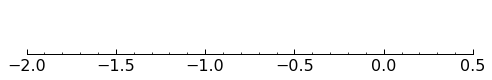

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(-2, 0.5)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)


plt.figure(figsize=(8, 8))
n = 8


# Multiple Locator
ax = plt.subplot(n, 1, 2)
setup(ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


NameError: name 'ii' is not defined

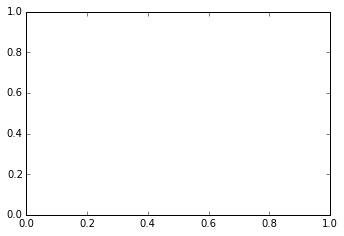

In [4]:
#import seaborn as sns
#from scipy.stats import kendalltau
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from scipy import stats
from scipy.optimize import curve_fit


fig=plt.figure(figsize=(12,8))
plt.subplot(221)
x = np.linspace(1, 100000, 10000)
plt.loglog(tauobs_m[ii],c0[ii],'b.',markersize=0.5)
poly1 = np.poly1d(np.polyfit(tauobs_m[ii], c0[ii], 3))
plt.plot(x,poly1(x),'b--')
plt.loglog(tauobs_m[ii],c1[ii]*c0[ii],'r.',markersize=0.5)
poly2 = np.poly1d(np.polyfit(tauobs_m[ii], c1[ii]*c0[ii], 3))
plt.plot(x,poly2(x),'r--')
plt.loglog(tauobs_m[ii],c2[ii]*c0[ii],'g.',markersize=0.5)
poly3 = np.poly1d(np.polyfit(tauobs_m[ii], c2[ii]*c0[ii], 3))
plt.plot(x,poly3(x),'g--')
plt.xlabel(r'$\tau_{in}$')
plt.ylabel(r'$RMS_{100yr}/RMS_{10yr}$')
print poly1,poly2,poly3
plt.ylim(0.8,10)
plt.xlim(0,10000.)
'''
plt.subplot(222)
plt.loglog(psig,c0,'b.',markersize=0.5)


plt.loglog(psig1,c1,'r.',markersize=0.5)
plt.loglog(psig2,c2,'g.',markersize=0.5)
plt.xlabel(r'$\sigma_{in}$')
plt.ylabel(r'$RMS_{100yr}/RMS_{10yr}$')

plt.subplot(223)
plt.loglog(tauobs_m,tau_f1,'r.',markersize=0.5)
plt.loglog(tauobs_m,tau_f2,'g.',markersize=0.5)
plt.xlabel(r'$\tau_{in}$')
plt.ylabel(r'$\rm F_{\tau}$')


plt.subplot(224)
plt.loglog(sigobs_m,SF_f1,'r.',markersize=0.5)
plt.loglog(sigobs_m,SF_f2,'g.',markersize=0.5)
plt.xlabel(r'$\sigma_{in}$')
plt.ylabel(r'$\rm F_{SF}$')

plt.xlim(0.01,0.7)

print np.median(ptau[i0]/tauobs_m[i0]), np.median(ptau1[i]/tauobs_m[i]), np.median(ptau2[i2]/tauobs_m[i2])
'''
#plt.savefig('/Users/legolason/Desktop/zzz.eps')
#######################################################################################
def func1(x, a, b, c):
    return a /(1+b*x**c)
def func2(x,a,b,c):
    return a*x**b+c
def func3(x,a,b,c,d):
    return a/(1+b*x**c)+d*x

fig=plt.figure(figsize=(12,8))
plt.subplot(221)
x = np.linspace(1, 100000, 10000)

#--------------3-----------------
plt.loglog(tauobs_m,ptau2/tauobs_m,'g.',markersize=0.5)
bin_medians, bin_edges, binnumber = stats.binned_statistic(tauobs_m[i2],ptau2[i2]/tauobs_m[i2],\
        statistic='median',bins=[10**0.5,10,10**1.5,100,10**2.5,1000,10**3.5,10**4,10**4.5,10**5])
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
#plt.plot(bin_centers,bin_medians,'go')
coeffs, pcov = curve_fit(func3, bin_centers, bin_medians, bounds=(-10, [100000., 5., 5.,100]))
y = func3(x, coeffs[0], coeffs[1], coeffs[2],coeffs[3])
plt.plot(x,y,'g--')
#print '--', coeffs[0], coeffs[1], coeffs[2],coeffs[3]
plt.xlabel(r'$\tau_{in}$')
plt.ylabel(r'$\tau_{out}/\tau_{in}$')

#-------------2-----------------
plt.loglog(tauobs_m,ptau1/tauobs_m,'r.',markersize=0.5)
bin_medians, bin_edges, binnumber = stats.binned_statistic(tauobs_m[i],ptau1[i]/tauobs_m[i],\
        statistic='median',bins=[2,10**0.5,10,10**1.5,100,10**2.5,1000,10**3.5,10**4,10**4.5,10**4.9])
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
#plt.plot(bin_centers,bin_medians,'ro')
coeffs, pcov = curve_fit(func2, bin_centers, bin_medians, bounds=(-50, [50., 50., 50.]))
y = func2(x, coeffs[0], coeffs[1], coeffs[2])
plt.plot(x,y,'r--')
#print coeffs[0], coeffs[1], coeffs[2]

#---------------1--------------
plt.loglog(tauobs_m,ptau/tauobs_m,'b.',markersize=0.5)
bin_medians, bin_edges, binnumber = stats.binned_statistic(tauobs_m[i0],ptau[i0]/tauobs_m[i0],\
        statistic='median',bins=[2,10**0.5,10,10**1.5,100,10**2.5,1000,10**3.5,10**4,10**4.5,10**4.9])
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
#plt.plot(bin_centers,bin_medians,'bo')
coeffs, pcov = curve_fit(func1, bin_centers, bin_medians, bounds=(-50, [50., 50., 50.]))
y = func1(x, coeffs[0], coeffs[1], coeffs[2])
plt.plot(x,y,'b--')
#print coeffs[0], coeffs[1], coeffs[2]
plt.xlim(0,80000.)
plt.ylim(0.01,100000)
#print np.median(tau_f1),np.median(tau_f2)
#print tau_f1,tau_f2


a=[10,100,200,400,500,800,1000]
b=[10,7,5,4,3.1,2.5,2]
c=[9,4.2,3.3,2.6,2.4,2.25,1.9]
plt.plot(a,b,'ro',a,c,'bo')


plt.subplot(222)
plt.loglog(tauobs_m,ptau2/tauobs_m/tau_f2,'g.',markersize=0.5)
plt.loglog(tauobs_m,ptau1/tauobs_m/tau_f1,'r.',markersize=0.5)
plt.loglog(tauobs_m,ptau/tauobs_m,'b.',markersize=0.5)
plt.xlabel(r'$\tau_{in}$')
plt.ylabel(r'$\tau_{out}/\tau_{in}$')

'''


plt.subplot(223)

#plt.loglog(sigobs_m[i2],psig2[i2]/sigobs_m[i2],'r.',markersize=0.5)
#plt.loglog(sigobs_m[i],psig1[i]/sigobs_m[i],'r.',markersize=0.5)
plt.loglog(tauobs_m[i0],sigobs_m[i0],'b.',markersize=0.5)

plt.subplot(224)
#plt.loglog(rms[ii],sigobs_m[ii],'k.',markersize=0.5)
plt.loglog(rms[i0],psig[i0],'r.',markersize=0.5)
x=np.linspace(0.01,10,1000)
y=x
plt.plot(x,y,'r--')
plt.xlabel(r'$RMS_{real}$')
plt.ylabel(r'$\sigma_{in}$')


plt.subplot(222)
plt.loglog(sigobs_m,psig,'k.',markersize=0.5)
#plt.xlim(0,0.3)
#plt.ylim(0,0.3)
plt.xlabel(r'SF_in')
plt.ylabel('SF_out')

plt.subplot(223)
plt.loglog(sigma,sigma1,'k.',markersize=0.5)
#plt.xlim(0,0.03)
#plt.ylim(0,0.03)
plt.xlabel(r'hat sigma_in')
plt.ylabel('hat sigma_out')
'''

(-1.0, 2)

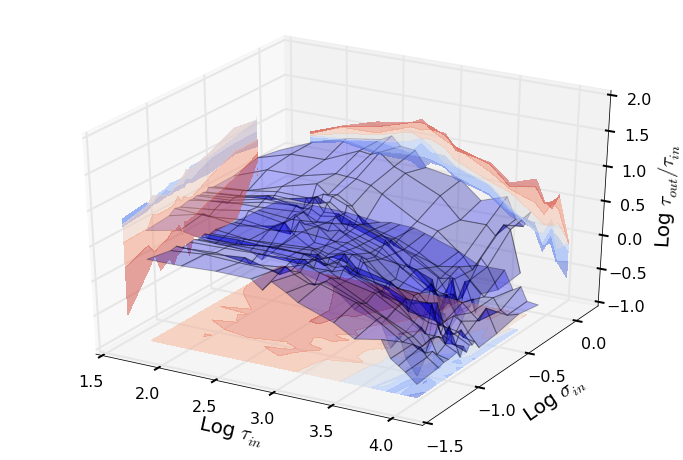

In [75]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import interpolate
import numpy as np 

data=np.load('/Users/legolason/study/lightcurve/SF_test/para/javelin/grid_nodrw2_all.npy')#grid_nodrw2_all.npy
#data1=np.load('/Users/legolason/study/lightcurve/SF_test/para/javelin/grid_1.5.npy')
#data2=np.load('/Users/legolason/study/lightcurve/SF_test/para/javelin/grid_1.2.npy')
tau_in=(data[2,:,:,1])
sig_in=(data[2,:,:,0])
tau_out=(data[2,:,:,3])
sig_out=(data[2,:,:,2])
ratio0=(data[0,:,:,3]/data[0,:,:,1])
ratio1=(data[1,:,:,3]/data[1,:,:,1])
ratio2=(data[2,:,:,3]/data[2,:,:,1])
scatter0=data[0,:,:,4]
scatter1=data[1,:,:,4]
scatter2=data[2,:,:,4]
sig_in_r0=data[0,:,:,5]
sig_in_r1=data[1,:,:,5]
sig_in_r2=data[2,:,:,5]

ratio3=(data[3,:,:,3]/data[3,:,:,1])
ratio4=(data[4,:,:,3]/data[4,:,:,1])
#print np.std(ratio1),np.std(ratio11)
#print np.median(ratio0),np.median(ratio1),np.median(ratio2)

#-------------------------------tau_out/tau_in--------------
fig=plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
X=np.log10(tau_in)
Y=np.log10(sig_in)
Z1=np.log10(ratio1)
Z0=np.log10(ratio0)
Z2=np.log10(ratio2)
#Z11=np.log10(ratio22)

zmin=-1
xmin=1.5
ymax=0.2
#ax.plot_surface(X,Y,np.log10(ratio0), rstride=1, cstride=1, alpha=0.3)
ax.plot_surface(X,Y,Z0, rstride=1, cstride=1, alpha=0.3)
ax.plot_surface(X,Y,Z2, rstride=1, cstride=1, alpha=0.3)
cset = ax.contourf(X, Y, Z2, zdir='z',offset=zmin, cmap=cm.coolwarm,alpha=0.5)
cset = ax.contourf(X, Y, Z2, zdir='x',offset=xmin, cmap=cm.coolwarm,alpha=0.5)
cset = ax.contourf(X, Y, Z2, zdir='y',offset=ymax, cmap=cm.coolwarm,alpha=0.5)
#cset = ax.contourf(X, Y, Z1 zdir='y',offset=ymax, cmap=cm.coolwarm,alpha=0.5)
ax.set_xlabel(r'Log $\tau_{in}$',fontsize=20)
ax.set_xlim(1.5, 4.2)
ax.set_ylabel(r'Log $\sigma_{in}$',fontsize=20)
ax.set_ylim(-1.5, 0.2)
ax.set_zlabel(r'Log $\tau_{out}/\tau_{in}$',fontsize=20)
ax.set_zlim(-1., 2)
#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/3d.eps')
#print np.median(scatter0),np.median(scatter1),np.median(scatter2)




Total number of photons: 181369501.39
Total number of photons: 182599522.313
Total number of photons: 182332939.266
0.12625309792 0.101213715093 0.123062970118


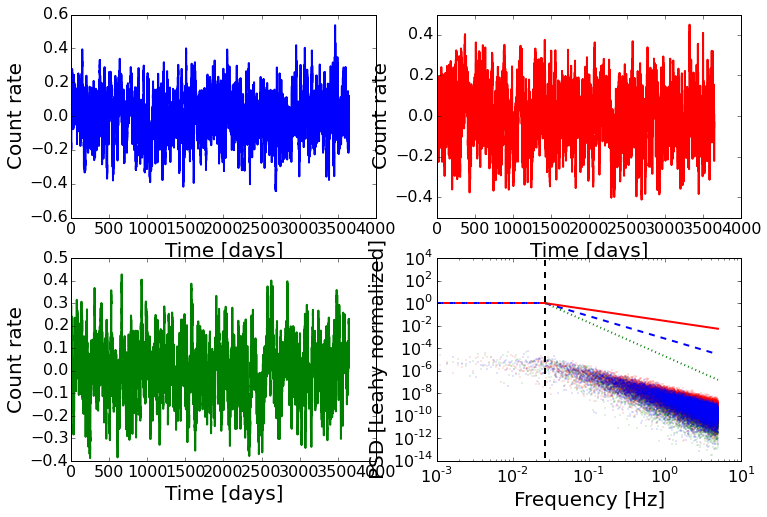

In [71]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyLCSIM

rate_src = 50000.0
rate_bkg = 3000.0
t_exp = 3650.0
dt = 0.1
frms = 0.124

nbins = long(t_exp/dt)

# Instantiate a simulation object
sim = pyLCSIM.Simulation()
# Add two PSD models: a smooth broken power law and a Lorentzian representing a QPO.
# See the documentation for details.
sim.addModel('smoothbknpo', [1,0, 2, 0.027])

# Run the simulation
sim.run(dt, nbins, rate_src, rms=frms)
# Add Poisson noise to the light curve

#sim.poissonRandomize(dt, rate_bkg)

# Get lightcurve and power spectrum as 1-D arrays
time, rate = sim.getLightCurve()
f, psd = sim.getPowerSpectrum()

a=[]
b=[]
c=[]
#for i in range(100):
#---------------------------------------------------
sim1=pyLCSIM.Simulation()
sim1.addModel('smoothbknpo', [1,0, 1.8, 0.027])
sim1.run(dt, nbins, rate_src, rms=frms)
time1, rate1 = sim1.getLightCurve()
f1, psd1 = sim1.getPowerSpectrum()
sim2=pyLCSIM.Simulation()
sim2.addModel('smoothbknpo', [1,0, 2.2, 0.027])
sim2.run(dt, nbins, rate_src, rms=frms)
time2, rate2 = sim2.getLightCurve()
f2, psd2 = sim2.getPowerSpectrum()
print np.std(rate2/50000),np.std(rate2[365:365*2]/50000),np.std(rate2[365*6:365*7]/50000)


fig=plt.figure(figsize=(12,8))
fig0 = plt.subplot(221)
plt.plot(time, rate/rate_src-1.)
plt.xlabel("Time [days]")
plt.ylabel("Count rate")
#plt.title("Lightcurve")
fig1 = plt.subplot(222)
plt.plot(time1, rate1/rate_src-1.,'r')
plt.xlabel("Time [days]")
plt.ylabel("Count rate")
#plt.title("Lightcurve")
fig2 = plt.subplot(223)
plt.plot(time2, rate2/rate_src-1.,'g')
plt.xlabel("Time [days]")
plt.ylabel("Count rate")
    #plt.title("Lightcurve")
'''
    a.append((rate/rate_src-1.).std())
    b.append((rate1/rate_src-1.).std())
    c.append((rate2/rate_src-1.).std())
print np.mean(a),np.median(a),np.std(a)
print np.mean(b),np.median(b),np.std(b)
print np.mean(c),np.median(c),np.std(c)


'''
fig3 = plt.subplot(224)
#plt.loglog(f, psd/rate_src, drawstyle='steps-mid', color='black')


plt.plot(f2,psd2/rate_src**2,'g.',markersize=0.5)
plt.plot(f1,psd1/rate_src**2,'r.',markersize=0.5)
plt.plot(f,psd/rate_src**2,'b.',markersize=0.5)
plt.plot([0.027,0.027],[-1.e10,1.e10],'k--')


    

x=np.arange(0.027,5,0.01)
y=x**(-2)*0.000729
#plt.plot(x,y,'r')
plt.plot(x,y,'b--')
plt.plot([0.001,0.027],[1,1],'r')
plt.plot([0.001,0.027],[1,1],'b--')
plt.plot([0.001,0.027],[1,1],'g:')
#plt.plot(x,y,'g:')

x1=np.arange(0.027,5.,0.001)
y=x1**(-1)*0.027
plt.plot(x1,y,'r')
y2=x1**(-3)*0.0000197
plt.plot(x1,y2,'g:')


plt.yscale('log')
plt.xscale('log')
plt.xlim(0.001,10.)
plt.ylim(1.e-14,1.e4)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Leahy normalized]")

-1.8 0.682 1.434
-3 6.5935 1.841
397.0625 5368.3455
run away ratio-------------------
drw 0.143452877398
-1.8 0.0699193772588
-3 0.372671670837
input 0.228667098725


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


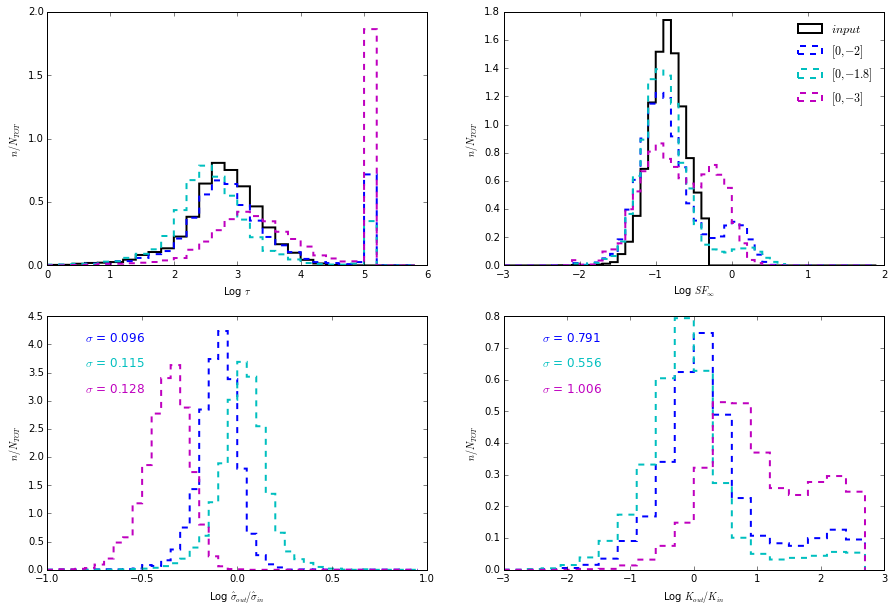

In [3]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
 
#import seaborn as sns

data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw2_c.txt') #ghx_nodrw2_c_avdrw.txt
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,Lbest,L0,Linf
#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_drw_nodrw.txt')
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,psig3,ptau3,psig4,ptau4
# 0 for [0,-2],1 for [-1,-2], 2 for [-1.9,-2],3 for [0,-1.8],4 for [0,-2.2]





SF_f1=data[:,13]
tau_f1=data[:,14]
SF_f2=data[:,15]
tau_f2=data[:,16]
c1=data[:,17]
c2=data[:,18]

print '-1.8',np.median(tau_f1), np.median(c1) 
print '-3',np.median(tau_f2),np.median(c2) 


sigobs_m=data[:,2]
tauobs_m=data[:,3]
psig=data[:,4]
ptau=data[:,5]
psig1=data[:,6]#*1.4#/SF_f1*1.9#*np.median(f1)#/1.5
ptau1=data[:,7]#/tau_f1#/np.median(tau_f1)#*1.8
psig2=data[:,8]#*f2#/SF_f2*3.3#*np.median(f2)/1.5
ptau2=data[:,9]#/tau_f2#/np.median(tau_f2)#/3


ptau[np.where((ptau == 'inf') | (ptau > 100000.), True, False)]=100000.
ptau1[np.where((ptau1 == 'inf') | (ptau1 > 100000.), True, False)]=100000.
ptau1[np.where( ptau1 < 1., True, False)]=1.
ptau2[np.where((ptau2 == 'inf') | (ptau2 > 100000.), True, False)]=100000.
tauobs_m[np.where((tauobs_m == 'inf') | (tauobs_m > 100000.), True, False)]=10000000000.
sigobs_m[np.where((sigobs_m == 0.0),True,False)]=0.01
psig[np.where((psig == 0.0),True,False)]=0.01
psig1[np.where((psig1 == 0.0),True,False)]=0.01
psig2[np.where((psig2 == 0.0),True,False)]=0.01

print np.median(ptau1),np.median(ptau2)

sigma_i=sigobs_m/np.sqrt(tauobs_m)
sigma=psig/np.sqrt(ptau)
sigma1=psig1/np.sqrt(ptau1)
sigma2=psig2/np.sqrt(ptau2)

K_i=tauobs_m*np.sqrt(sigobs_m)
K=ptau*np.sqrt(psig)
K1=ptau1*np.sqrt(psig1)
K2=ptau2*np.sqrt(psig2)

'''
#-------corrected----------
sigma1=psig1/0.98/np.sqrt(ptau1/0.52)
sigma2=psig2/1.02/np.sqrt(ptau2/3.5)
K1=ptau1/0.98*np.sqrt(psig1/0.52)
K2=ptau2/2.*np.sqrt(psig2/1.)
'''
i0=np.where(ptau < 100000.)
i=np.where(ptau1 < 100000.)
i2=np.where((ptau2 < 100000.) &(psig2 >0.0001),True,False)

print 'run away ratio-------------------'
print 'drw', np.sum(np.where(ptau>= 100000.,True,False))/float(np.sum(np.where(ptau>0.,True,False)))
print '-1.8', np.sum(np.where(ptau1>= 100000.,True,False))/float(np.sum(np.where(ptau1>0.,True,False)))
print '-3', np.sum(np.where(ptau2>= 100000.,True,False))/float(np.sum(np.where(ptau2>0.,True,False)))
print 'input', 1-np.sum(np.where(tauobs_m < 100000.,True,False))/9258.



fig=plt.figure(figsize=(15,10))

plt.subplot(221)
bin3=np.arange(0,6,0.2)
plt.hist(list(np.log10(tauobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$',lw=2)
plt.hist(list(np.log10(ptau)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${\alpha=-2}$',lw=2)
plt.hist(list(np.log10(ptau1)),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'${\alpha=-1.8}$',lw=2)
plt.hist(list(np.log10(ptau2)),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'${\alpha=-3}$',lw=2)
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)

plt.subplot(222)
bin3=np.arange(-3,2,0.1)
plt.hist(list(np.log10(sigobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$',lw=2)
plt.hist(list(np.log10(psig)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(psig1)),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'${[0,-1.8]}$',lw=2)
plt.hist(list(np.log10(psig2)),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'${[0,-3]}$',lw=2)

plt.xlabel(r'Log $SF_{\infty}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False)

ax3=plt.subplot(223)
#ax3=plt.subplot(111)
bin3=np.arange(-1,1,0.05)
plt.hist(list(np.log10(sigma[i0]/sigma_i[i0])),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(sigma1[i]/sigma_i[i])),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'${[0,-1.8]}$',lw=2)
plt.hist(list(np.log10(sigma2[i2]/sigma_i[i2])),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'${[0,-3]}$',lw=2)

plt.xlabel(r'Log $\hat\sigma_{out}/\hat\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)

b=np.log10(sigma[i0]/sigma_i[i0])
c=np.log10(sigma1[i]/sigma_i[i])
m=np.log10(sigma2[i2]/sigma_i[i2])
           
sg0=(np.percentile(np.log10(sigma[i0]/sigma_i[i0]),(16,84))[1]-np.percentile(np.log10(sigma/sigma_i),(16,84))[0])*0.5
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax3.transAxes,fontsize=12)
sg1=(np.percentile(np.log10(sigma1[i]/sigma_i[i]),(16,84))[1]-np.percentile(np.log10(sigma1/sigma_i),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='c',transform = ax3.transAxes,fontsize=12)
sg2=(np.percentile(np.log10(sigma2[i2]/sigma_i[i2]),(16,84))[1]-np.percentile(np.log10(sigma2/sigma_i),(16,84))[0])*0.5
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='m',transform = ax3.transAxes,fontsize=12)
#sg3=(np.percentile(np.log10(c),(16,50))[1]-np.percentile(np.log10(c),(16,84))[0])*0.5
#plt.text(0.1,0.6,'$\sigma$ = '+str(round(sg3,2)),color='yellow',transform = ax.transAxes)

ax4=plt.subplot(224)
bin3=np.arange(-3,3,0.3)

plt.hist(list(np.log10(K/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(K1/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'${[0,-1.8]}$',lw=2)
plt.hist(list(np.log10(K2/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'${[0,-3]}$',lw=2)

plt.xlabel(r'Log $K_{out}/K_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10})#,frameon=False)

sg0=(np.percentile(np.log10(K/K_i),(16,84))[1]-np.percentile(np.log10(K/K_i),(16,84))[0])*0.5
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax4.transAxes,fontsize=12)
sg1=(np.percentile(np.log10(K1/K_i),(16,84))[1]-np.percentile(np.log10(K1/K_i),(16,84))[0])*0.5
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='c',transform = ax4.transAxes,fontsize=12)
sg2=(np.percentile(np.log10(K2/K_i),(16,84))[1]-np.percentile(np.log10(K2/K_i),(16,84))[0])*0.5
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='m',transform = ax4.transAxes,fontsize=12)


#plt.text(0.6, 0.85, 'Corrected',transform=ax3.transAxes )
#plt.text(0.7, 0.8, 'Corrected',transform=ax4.transAxes )

plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/nondrw2_distr.eps')

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.subplot(221)
#plt.loglog(ptau,c0,'k.')
plt.loglog(tauobs_m,c1,'c.',markersize=0.5)
plt.loglog(tauobs_m,c2,'m.',markersize=0.5)
plt.xlabel(r'$\tau$')
plt.ylabel('factor')
plt.xlim(0,100000)


plt.subplot(222)
plt.loglog(tauobs_m,tau_f1,'c.',markersize=0.5)
plt.loglog(tauobs_m,tau_f2,'m.',markersize=0.5)
plt.xlabel(r'$\tau_{in}$')
plt.ylabel(r'$\rm F_{\tau}$')
plt.xlim(0,100000)
plt.ylim(0.1,100)



In [ ]:
## for  all drw and nondrw models  
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
import pyLCSIM
from scipy.stats import chi2
from scipy.integrate import simps
import matplotlib as mpl
#mpl.rcParams['axes.linewidth'] = 2
#mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 12
def corr(wave_rf, M_i, M_bh,z):
    log_SF=-0.51-0.479*np.log10(wave_rf/4000.)+0.131*(M_i+23)+0.18*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    log_tau=2.4+0.17*np.log10(wave_rf/4000.)+0.03*(M_i+23)+0.21*np.log10(np.power(10,M_bh)/10**9)+0*np.log10(1+z)
    return log_SF,log_tau

infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))
index1=np.array(np.where(((infor[:,7]) !=0.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))

#print len(all_file) #9258
ID=infor[index,0]
z=infor[index,6]
M_i=infor[index,5]
M_bh=infor[index,7]
wave_rf=6231./(1.+z)

#for similar parameters 
ind=np.where((M_bh >8.8) & ( M_bh < 9.1)&(M_i > -26.) & (M_i < -25.2)&(wave_rf <2700. )&( wave_rf >2300.), True, False)

print sum(ind)
log_SF,log_tau=corr(wave_rf[ind],M_i[ind],M_bh[ind],z[ind])
#log_SFa,log_taua=corr(wave_rf,M_i,M_bh,z)

#bin1=np.arange(2.0,2.6,0.05)
#plt.hist(log_taua,bin1,histtype='step',normed=True,ls='dashed',color='blue')
#plt.hist(log_tau,bin1,histtype='step',normed=True,ls='dashed',color='red')



name=[]
redshift=[]
s=[]
t=[]
psig=[]
ptau=[]
psig1=[]
ptau1=[]
psig2=[]
ptau2=[]
psig3=[]
ptau3=[]
psig4=[]
ptau4=[]
psigm=[]
ptaum=[]
psig1m=[]
ptau1m=[]
psig2m=[]
ptau2m=[]
psig3m=[]
ptau3m=[]
psig4m=[]
ptau4m=[]
psigs=[]
ptaus=[]
psig1s=[]
ptau1s=[]
psig2s=[]
ptau2s=[]
psig3s=[]
ptau3s=[]
psig4s=[]
ptau4s=[]

time_new=np.arange(0,365*10,1)
error_new=np.abs(np.random.normal(0,0.01,3650))

a=len(all_file[index][ind])
print a

 



for tau in [1000]:
    sigma=0.1
    t.append(tau)
    s.append(sigma)
    x=0
    while (x < 1):
        for i in range(1):
            data=np.genfromtxt(str(int(ID[ind][i])))
            mag_i=data[:,7]
            mag_i_err=data[:,8]
            index_i=np.where((mag_i>0) &(mag_i<30) & (mag_i_err <1.)& (mag_i_err > 0.) )
            mag_i=mag_i[index_i]
            mu=np.mean(mag_i)

            mag_i_err=mag_i_err[index_i]
            mjd_i=data[index_i,6]
            time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
            idx=time.astype(int)
            '''
             # -----fit the observed light curve
            aa0=[np.log(0.16/1.414),np.log(470)]
            np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[np.array(time), mag_i,mag_i_err])
            javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
            cont = Cont_Model(javdata)
            #fig=cont.do_pred(aa0)
            #fig.plot(set_pred=True,obs=javdata)
            #plt.plot(time,mag_i)

            p0=np.exp(np.array(cont.do_map(aa0,fixed=[1,1],set_prior=False)[0]))


            #print p0
            if p0[1] < 1.:   
                continue
            if p0[0] <= 0.0:
                continue
            if p0[0] >1.:
                continue
            name.append(ID[ind][i])
            redshift.append(z[ind][i])
            sigobs_m.append((p0[0]))
            tauobs_m.append((p0[1]))
            print 'p0',p0
            '''

            p0=[sigma,tau]
            #---------------for different model
            rate_src = 50000.0
            rate_bkg = 3000.0
            t_exp = 3650.0
            dt = 1.0
            frms = p0[0]
            freq_br=1/(2*np.pi*p0[1])
            nbins = long(t_exp/dt)


            #plt.figure()
            for j,k in [[0,2.],[1.,2.],[1.9,2.],[0,1.8],[0,2.2]]:
                sim = pyLCSIM.Simulation()
                sim.addModel('smoothbknpo', [1,j, k, freq_br])
                sim.run(dt, nbins, rate_src, rms=frms)
                time_sim, rate = sim.getLightCurve()
                f, psd = sim.getPowerSpectrum()
                rate=rate/rate_src-1.+mu
                freq_m, model_tot, model_comp = sim.getPSDModel(dt, nbins, freq=10000)
                #model_tot=model_tot/np.sum(model_tot)*np.sum(psd)
                model_tot = model_tot / simps(model_tot, freq_m) * simps(psd, f)
                '''
                for mod in model_comp:
                # Plot the various additive component as dashed lines
                    #plt.loglog(freq_m, mod, ls='dashed', color='red') # Plot the total model
                    if [j,k]==[0,2.]:
                        plt.loglog(freq_m, model_tot)
                        print 'rms' , np.sum(model_tot),np.sum(psd)
                        plt.plot(f, psd, 'b.')

                    if [j,k]==[1,2.]:
                        plt.loglog(freq_m, model_tot,color='red')
                        plt.plot(f, psd, 'r.')
                        print 'rms' , np.sum(model_tot),np.sum(psd)
                    if [j,k]==[1.9,2.]:
                        plt.loglog(freq_m, model_tot,color='green')
                        print 'rms' , np.sum(model_tot),np.sum(psd)
                        plt.plot(f, psd, 'g.')

                '''

                #---------obs as the input and get a new obs_output with 5days spaced 10yrs light cuvre with 0.01mag error.
                X1=TM.generate_damped_RW(time_new, tau=p0[1], z=0., xmean=mu, SFinf=p0[0], random_state=None) #0.113
                np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_sim[idx], rate[idx],error_new[idx]])
                #plt.plot(time_new,X1)
                #plt.plot(time,X1[idx],'ro')

                javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
                cont2 = Cont_Model(javdata)
                aa=[np.log(p0[0]),np.log(p0[1])]
                p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
                if [j,k]==[0,2.]:
                    if p[1] > 1.e5:   
                        continue
                    psig.append(p[0])
                    ptau.append(p[1])
                if [j,k]==[1.,2]:
                    if p[1] > 1.e5:   
                        continue
                    psig1.append(p[0])
                    ptau1.append(p[1])
                if [j,k]==[1.9,2.]:
                    if p[1] > 1.e5:   
                        continue
                    psig2.append(p[0])
                    ptau2.append(p[1])
                if [j,k]==[0,1.8]:
                    if p[1] > 1.e5:   
                        continue
                    psig3.append(p[0])
                    ptau3.append(p[1])
                if [j,k]==[0,2.2]:
                    if p[1] > 1.e5:   
                        continue
                    psig4.append(p[0])
                    ptau4.append(p[1])
            #print     sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2
            print i
            x=x+1

    psigm.append(np.median(psig))
    ptaum.append(np.median(ptau))
    psig1m.append(np.median(psig1))
    ptau1m.append(np.median(ptau1))
    psig2m.append(np.median(psig2))
    ptau2m.append(np.median(ptau2))
    psig3m.append(np.median(psig3))
    ptau3m.append(np.median(ptau3))
    psig4m.append(np.median(psig4))
    ptau4m.append(np.median(ptau4))
    psigs.append(np.std(psig))
    ptaus.append(np.std(ptau))
    psig1s.append(np.std(psig1))
    ptau1s.append(np.std(ptau1))
    psig2s.append(np.std(psig2))
    ptau2s.append(np.std(ptau2))
    psig3s.append(np.std(psig3))
    ptau3s.append(np.std(ptau3))
    psig4s.append(np.std(psig4))
    ptau4s.append(np.std(ptau4))
print sigma,tau,psigm,ptaum,psig1m,ptau1m,psig2m,ptau2m,psig3m,ptau3m,psig4m,ptau4m
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/deviation.txt',\
           np.c_[s,t,psigm,ptaum,psig1m,ptau1m,psig2m,ptau2m,psig3m,ptau3m,psig4m,ptau4m,\
                psigs,ptaus,psig1s,ptau1s,psig2s,ptau2s,psig3s,ptau3s,psig4s,ptau4s],fmt='%4.3f')

print 'successed!'



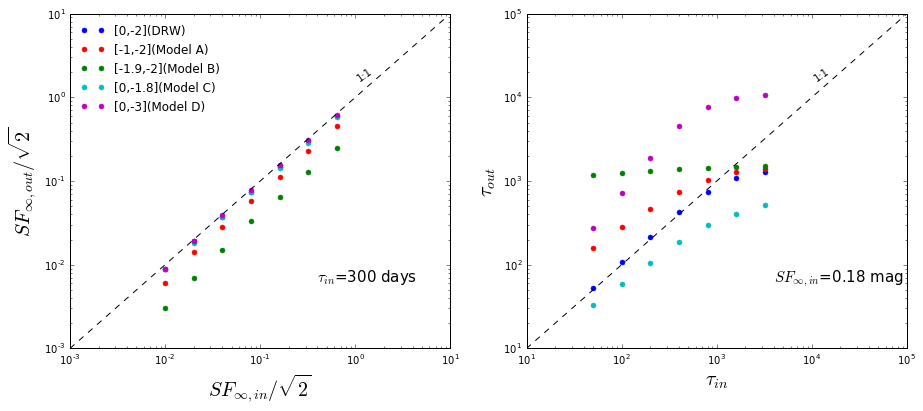

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#plt.style.use('my')
#mpl.rcParams['font.size'] =30
data1=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/deviation_0.18mag.txt')
data2=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/deviation_500days.txt')
#s,t,psigm,ptaum,psig1m,ptau1m,psig2m,ptau2m,psig3m,ptau3m,psig4m,ptau4m,\
#psigs,ptaus,psig1s,ptau1s,psig2s,ptau2s,psig3s,ptau3s,psig4s,ptau4s
x=np.arange(0.001,10)
y=x
n=10
plt.figure(figsize=(15,6))
ax1=plt.subplot(121)
plt.loglog(data2[:,0],data2[:,2],'b.',label='[0,-2](DRW)',markersize=n)
plt.loglog(data2[:,0],data2[:,4],'r.',label='[-1,-2](Model A)',markersize=n)
plt.loglog(data2[:,0],data2[:,6],'g.',label='[-1.9,-2](Model B)',markersize=n)
plt.loglog(data2[:,0],data2[:,8],'c.',label='[0,-1.8](Model C)',markersize=n)
plt.loglog(data2[:,0],data2[:,10],'m.',label='[0,-3](Model D)',markersize=n)
plt.loglog(x,y,'k--')
plt.text(0.75, 0.82, '1:1',rotation=35,transform=ax1.transAxes )
#plt.ylim(0.01,0.2)
#plt.xlim(0.008,1)
plt.xlabel(r'$SF_{\infty,in}/\sqrt{2}$',fontsize=20)
plt.ylabel(r'$SF_{\infty,out}/\sqrt{2}$',fontsize=20)
plt.legend(frameon=False,loc='best')
plt.text(0.65, 0.2, r'$\tau_{in}$=300 days',transform=ax1.transAxes,fontsize=15 )

#print data2[:,0],data2[:,2],data2[:,4]
ax2=plt.subplot(122)
x=np.arange(1,100000)
y=x
plt.loglog(data1[:,1],data1[:,3],'b.',label='[0,-2](DRW)',markersize=n)
plt.loglog(data1[:,1],data1[:,5],'r.',label='[-1,-2](Model A)',markersize=n)
plt.loglog(data1[:,1],data1[:,7],'g.',label='[-1.9,-2](Model B)',markersize=n)
plt.loglog(data1[:,1],data1[:,9],'c.',label='[0,-1.8](Model C)',markersize=n)
plt.loglog(data1[:,1],data1[:,11],'m.',label='[0,-2.2](Model D)',markersize=n)
#plt.errorbar(data1[:,1], data1[:,3],yerr=data1[:,13],ecolor='r', marker='.',mfc='r', mec='r',ms=4, ls='None', lw=1)
plt.loglog(x,y,'k--')
plt.text(0.75, 0.82, '1:1',rotation=35,transform=ax2.transAxes )
plt.text(0.65, 0.2, r'$SF_{\infty,in}$=0.18 mag',transform=ax2.transAxes,fontsize=15 )

plt.xlabel(r'$\tau_{in}$',fontsize=20)
plt.ylabel(r'$\tau_{out}$',fontsize=20)
plt.xlim(10,100000)
plt.ylim(10,100000)
'''
ax5=plt.subplot(323)
plt.loglog(data2[:,0],data2[:,2]/data2[:,2],'b.')
plt.loglog(data2[:,0],data2[:,4]/data2[:,2],'r.')
plt.loglog(data2[:,0],data2[:,6]/data2[:,2],'g.')
plt.loglog(data2[:,0],data2[:,8]/data2[:,2],'c.')
plt.loglog(data2[:,0],data2[:,10]/data2[:,2],'m.')
#plt.ylim(0.8,1.2)
plt.xlim(0.008,1)
plt.xlabel(r'$\sigma_{in}$')
plt.ylabel(r'$\sigma_{out}/\sigma_{drw}$')

ax6=plt.subplot(324)
plt.loglog(data1[:,1],data1[:,3]/data1[:,3],'b.')
plt.loglog(data1[:,1],data1[:,5]/data1[:,3],'r.')
plt.loglog(data1[:,1],data1[:,7]/data1[:,3],'g.')
plt.loglog(data1[:,1],data1[:,9]/data1[:,3],'c.')
plt.loglog(data1[:,1],data1[:,11]/data1[:,3],'m.')
plt.xlim(30,10000)
plt.xlabel(r'$\tau_{in}$')
plt.ylabel(r'$\tau_{out}/\tau_{drw}$')


ax5=plt.subplot(325)
plt.loglog(data2[:,3],data2[:,3]/data2[:,3],'b.')
plt.loglog(data2[:,5],data2[:,5]/data2[:,3],'r.')
plt.loglog(data2[:,7],data2[:,7]/data2[:,3],'g.')
plt.loglog(data2[:,9],data2[:,9]/data2[:,3],'c.')
plt.loglog(data2[:,11],data2[:,11]/data2[:,3],'m.')
plt.xlim(100,2000)
plt.xlabel(r'$\tau_{out}$')
plt.ylabel(r'$\tau_{out}/\tau_{drw}$')


ax6=plt.subplot(326)
plt.loglog(data1[:,2],data1[:,2]/data1[:,2],'b.')
plt.loglog(data1[:,4],data1[:,4]/data1[:,2],'r.')
plt.loglog(data1[:,6],data1[:,6]/data1[:,2],'g.')
plt.loglog(data1[:,8],data1[:,8]/data1[:,2],'c.')
plt.loglog(data1[:,10],data1[:,10]/data1[:,2],'m.')
plt.xlim(0.03,0.3)


print 'sig1', np.mean(data1[:,4]/data1[:,2]),np.mean(data1[:,6]/data1[:,2]),\
np.mean(data1[:,8]/data1[:,2]),np.mean(data1[:,10]/data1[:,2])
print 'tau1', np.mean(data1[:,5]/data1[:,1]), np.mean(data1[:,7]/data1[:,1]),\
np.mean(data1[:,9]/data1[:,1]), np.mean(data1[:,11]/data1[:,1])

print '---------------------------------------------'
print 'sig2', np.mean(data2[:,4]/data2[:,2]),np.mean(data2[:,6]/data2[:,2]),\
np.mean(data2[:,8]/data2[:,2]),np.mean(data2[:,10]/data2[:,2])
print 'tau2', np.mean(data2[:,5]/data2[:,1]), np.mean(data2[:,7]/data2[:,1]),\
np.mean(data2[:,9]/data2[:,1]), np.mean(data2[:,11]/data2[:,1])
plt.xlabel(r'$\sigma_{out}$')
plt.ylabel(r'$\sigma_{out}/\sigma_{drw}$')
'''

plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/offdrw.eps')

1373
885
obs 422.028 0.138
571.096 298.682 5117.206
0.133 0.131 0.204
run away ratio-------------------
drw 0.114348142753
-1 0.0626365622724
-1.9 0.35542607429
input 0.194874851013
488 1373.0


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


------- 0.417512005962


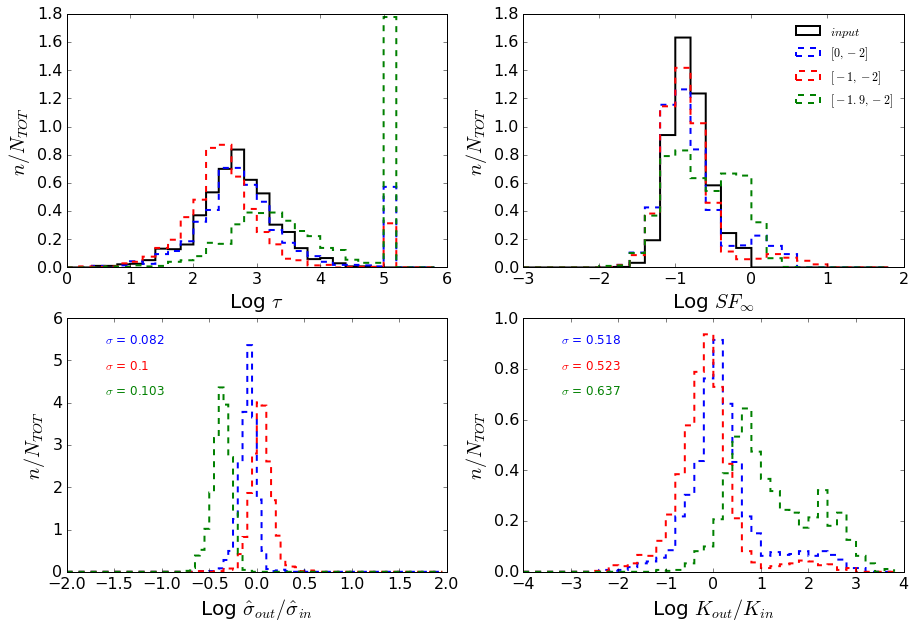

In [5]:
#DRW  012  !!!!!!!!!!!!!!!!!!!!!!!!!!
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1
plt.style.use('my')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw2_select.txt')
#ghx_nodrw_c_drw_avdrw_poly_surface_all5.txt')  
#ghx_nodrw2_c2.txt
#samepar.txt,ghx_un_nomcmc_012_sametausig.txt,ghx_un_nomcmc_012_scattertausig.txt
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,psig3,ptau3,psig4,ptau4

#SF_f1=data[:,13]
#tau_f1=data[:,14]
#SF_f2=data[:,15]
#tau_f2=data[:,16]

#print '-1',np.median(SF_f1),np.median(tau_f1) 
#print '-2',np.median(SF_f2),np.median(tau_f2)


sigobs_m=data[:,2]
tauobs_m=data[:,3]
psig=data[:,4]
ptau=data[:,5]
psig1=data[:,6]#/SF_f1*1.9#*np.median(f1)#/1.5
ptau1=data[:,7]#/tau_f1#/np.median(tau_f1)#*1.8
psig2=data[:,8]#/SF_f2*3.3#*f2#*np.median(f2)/1.5
ptau2=data[:,9]#/tau_f2#/np.median(tau_f2)#/3

print len(sigobs_m)


'''

psig1=data[:,10]
ptau1=data[:,11]
psig2=data[:,12]
ptau2=data[:,13]
'''


ptau[np.where((ptau == 'inf') | (ptau > 100000.), True, False)]=100000.
ptau1[np.where((ptau1 == 'inf') | (ptau1 > 100000.), True, False)]=100000.
ptau1[np.where( ptau1 < 1., True, False)]=1.
ptau2[np.where( ptau2 < 1., True, False)]=1.
ptau2[np.where((ptau2 == 'inf') | (ptau2 > 100000.), True, False)]=100000.
tauobs_m[np.where((tauobs_m == 'inf')|(tauobs_m > 100000.),True,False)]=10000000000
sigobs_m[np.where((sigobs_m == 0.0),True,False)]=0.0001
psig[np.where((psig == 0.0),True,False)]=0.0001
psig1[np.where((psig1 == 0.0),True,False)]=0.0001
psig2[np.where((psig2 == 0.0),True,False)]=0.0001

io=np.where(ptau<100000.)
i=np.where(ptau1 < 100000.)
i2=np.where((ptau2 < 100000.) &(psig2 >0.0001),True,False)
print np.sum(i2)
print 'obs', np.median(tauobs_m[io]),np.median(sigobs_m[io])
print np.median(ptau),np.median(ptau1),np.median(ptau2)
print np.median(psig),np.median(psig1),np.median(psig2)

print 'run away ratio-------------------'
print 'drw', np.sum(np.where(ptau>= 100000.,True,False))/float(np.sum(np.where(ptau>0.,True,False)))
print '-1', np.sum(np.where(ptau1>= 100000.,True,False))/float(np.sum(np.where(ptau1>0.,True,False)))
print '-1.9', np.sum(np.where(ptau2>= 100000.,True,False))/float(np.sum(np.where(ptau2>0.,True,False)))
print 'input', 1-np.sum(np.where(tauobs_m < 100000.,True,False))/1678.

print np.sum(np.where(ptau2>= 100000.,True,False)) , float(np.sum(np.where(ptau2>0.,True,False)))

sigma_i=sigobs_m/np.sqrt(tauobs_m)
sigma=psig/np.sqrt(ptau)

sigma1=psig1/np.sqrt(ptau1)
sigma2=psig2/np.sqrt(ptau2)

K_i=tauobs_m*np.sqrt(sigobs_m)
K=ptau*np.sqrt(psig)
K1=ptau1*np.sqrt(psig1)
K2=ptau2*np.sqrt(psig2)



fig=plt.figure(figsize=(15,10))

plt.subplot(221)
bin3=np.arange(0.,6,0.2)
plt.hist(list(np.log10(tauobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$',lw=2)
plt.hist(list(np.log10(ptau)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(ptau1)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$',lw=2)
plt.hist(list(np.log10(ptau2)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$',lw=2)
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10},frameon=False)




ax2=plt.subplot(222)
bin3=np.arange(-3.,2,0.2)
plt.hist(list(np.log10(sigobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$',lw=2)
plt.hist(list(np.log10(psig)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(psig1)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$',lw=2)
plt.hist(list(np.log10(psig2)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$',lw=2)

plt.xlabel(r'Log $SF_{\infty}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False)


ax3=plt.subplot(223)

bin3=np.arange(-2.,2,0.05)

plt.hist(list(np.log10(sigma[io]/sigma_i[io])),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(sigma1[i]/sigma_i[i])),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$',lw=2)
plt.hist(list(np.log10(sigma2[i2]/sigma_i[i2])),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$',lw=2)

plt.xlabel(r'Log $\hat\sigma_{out}/\hat\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10},frameon=True)

#plot another figure nodrw next fig
blue=np.log10(sigma[io]/sigma_i[io])
red=np.log10(sigma1[i]/sigma_i[i])
green=np.log10(sigma2[i2]/sigma_i[i2])

#plot nodrw2 next next fig
b=np.log10(sigma[io]/sigma_i[io])
c=np.log10(sigma1[i]/sigma_i[i])
m=np.log10(sigma2[i2]/sigma_i[i2])


sg0=(np.percentile(np.log10(sigma[io]/sigma_i[io]),(16,84))[1]-np.percentile(np.log10(sigma[io]/sigma_i[io]),(16,84))[0])*0.5
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax3.transAxes,fontsize=12)
sg1=(np.percentile(np.log10(sigma1[i]/sigma_i[i]),(16,50))[1]-np.percentile(np.log10(sigma1[i]/sigma_i[i]),(16,50))[0])*1
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='red',transform = ax3.transAxes,fontsize=12)
sg2=(np.percentile(np.log10(sigma2[i2]/sigma_i[i2]),(16,50))[1]-np.percentile(np.log10(sigma2[i2]/sigma_i[i2]),(16,50))[0])*1
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='green',transform = ax3.transAxes,fontsize=12)
print '-------',np.percentile(np.log10(sigma/sigma_i),(16,50))[1]-np.percentile(np.log10(sigma2/sigma_i),(16,50))[0]
#plt.text(0.6, 0.85, 'Corrected',transform=ax3.transAxes )
#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/nondrw_distr_crt.eps')





ax4=plt.subplot(224)
bin3=np.arange(-4,4,0.2)

plt.hist(list(np.log10(K/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(K1/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$',lw=2)
plt.hist(list(np.log10(K2/K_i)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'$[-1.9,-2]$',lw=2)

plt.xlabel(r'Log $K_{out}/K_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10},frameon=False)

sg0=(np.percentile(np.log10(K/K_i),(16,50))[1]-np.percentile(np.log10(K/K_i),(16,50))[0])
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax4.transAxes,fontsize=12)
sg1=(np.percentile(np.log10(K1/K_i),(16,50))[1]-np.percentile(np.log10(K1/K_i),(16,50))[0])
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='red',transform = ax4.transAxes,fontsize=12)
sg2=(np.percentile(np.log10(K2/K_i),(16,50))[1]-np.percentile(np.log10(K2/K_i),(16,50))[0])
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='green',transform = ax4.transAxes,fontsize=12)
#plt.text(0.7, 0.8, 'Corrected',transform=ax4.transAxes )

#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/nondrw_distr.eps')


In [16]:
print np.log10(0.00003),np.log10(0.25)

-4.52287874528 -0.602059991328


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


run away ratio-------------------
drw 0.181970812347
-1 0.223169314219
-1.9 0.41560118817
input 0.202527543746


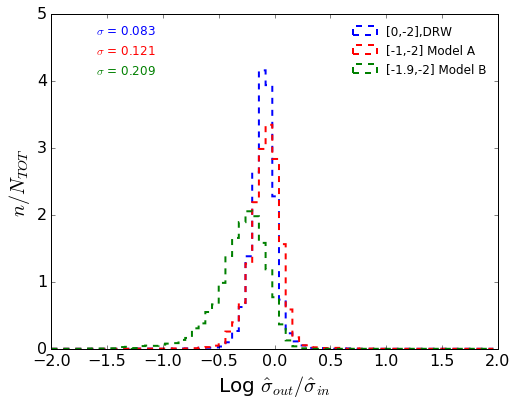

In [15]:
#DRW  012  !!!!!!!!!!!!!!!!!!!!!!!!!!
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 1
plt.style.use('my')

data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw_c_drw_avdrw_poly_surface_all5.txt')
#ghx_nodrw_c_drw_avdrw_poly_surface_all5.txt')  
#ghx_nodrw2_c2.txt
#samepar.txt,ghx_un_nomcmc_012_sametausig.txt,ghx_un_nomcmc_012_scattertausig.txt
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,psig3,ptau3,psig4,ptau4

SF_f1=data[:,13]
tau_f1=data[:,14]
SF_f2=data[:,15]
tau_f2=data[:,16]

#print '-1',np.median(SF_f1),np.median(tau_f1) 
#print '-2',np.median(SF_f2),np.median(tau_f2)


sigobs_m=data[:,2]
tauobs_m=data[:,3]
psig=data[:,4]
ptau=data[:,5]
psig1=data[:,6]#/SF_f1*1.9#*np.median(f1)#/1.5
ptau1=data[:,7]#/tau_f1#/np.median(tau_f1)#*1.8
psig2=data[:,27]#/SF_f2*3.3#*f2#*np.median(f2)/1.5
ptau2=data[:,28]#/tau_f2#/np.median(tau_f2)#/3




'''

psig1=data[:,10]
ptau1=data[:,11]
psig2=data[:,12]
ptau2=data[:,13]
'''


ptau[np.where((ptau == 'inf') | (ptau > 100000.), True, False)]=100000.
ptau1[np.where((ptau1 == 'inf') | (ptau1 > 100000.), True, False)]=100000.
ptau1[np.where( ptau1 < 1., True, False)]=1.
ptau2[np.where( ptau2 < 1., True, False)]=1.
ptau2[np.where((ptau2 == 'inf') | (ptau2 > 100000.), True, False)]=100000.
sigobs_m[np.where((sigobs_m == 0.0),True,False)]=0.0001
psig[np.where((psig == 0.0),True,False)]=0.0001
psig1[np.where((psig1 == 0.0),True,False)]=0.0001
psig2[np.where((psig2 == 0.0),True,False)]=0.0001

io=np.where(ptau<100000.)
i=np.where(ptau1 < 100000.)
i2=np.where((ptau2 < 100000.) &(psig2 >0.0001),True,False)
#print np.sum(i2)
#print 'obs', np.median(tauobs_m[io]),np.median(sigobs_m[io])
#print np.median(ptau),np.median(ptau1),np.median(ptau2)
#print np.median(psig),np.median(psig1),np.median(psig2)

print 'run away ratio-------------------'
print 'drw', np.sum(np.where(ptau>= 100000.,True,False))/float(np.sum(np.where(ptau>0.,True,False)))
print '-1', np.sum(np.where(ptau1>= 100000.,True,False))/float(np.sum(np.where(ptau1>0.,True,False)))
print '-1.9', np.sum(np.where(ptau2>= 100000.,True,False))/float(np.sum(np.where(ptau2>0.,True,False)))
print 'input', 1-np.sum(np.where(tauobs_m < 100000.,True,False))/9258.



sigma_i=sigobs_m/np.sqrt(tauobs_m)
sigma=psig/np.sqrt(ptau)

sigma1=psig1/np.sqrt(ptau1)
sigma2=psig2/np.sqrt(ptau2)

K_i=tauobs_m*np.sqrt(sigobs_m)
K=ptau*np.sqrt(psig)
K1=ptau1*np.sqrt(psig1)
K2=ptau2*np.sqrt(psig2)


obsr=np.log10(tauobs_m[tauobs_m<10000.])

br=np.log10(ptau)
rr=np.log10(ptau1)
gr=np.log10(ptau2)

'''
#-------corrected----------
sigma1=psig1/np.sqrt(ptau1/0.6)
sigma2=psig2/np.sqrt(ptau2/3)
#K1=ptau1/0.75*np.sqrt(psig1/1.59)
#K2=ptau2/0.45*np.sqrt(psig2/2.4)
'''
'''
fig=plt.figure(figsize=(12,8))

plt.subplot(221)
bin3=np.arange(0.,6,0.2)
plt.hist(list(np.log10(tauobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$')
plt.hist(list(np.log10(ptau)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$')
plt.hist(list(np.log10(ptau1)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$')
plt.hist(list(np.log10(ptau2)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$')
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
#plt.legend(prop={'size':10},frameon=False)

ax2=plt.subplot(222)
bin3=np.arange(-3.,2,0.2)
plt.hist(list(np.log10(sigobs_m)),bin3,histtype='step',normed=True,color='black',label=r'${input}$')
plt.hist(list(np.log10(psig)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$')
plt.hist(list(np.log10(psig1)),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$')
plt.hist(list(np.log10(psig2)),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$')

plt.xlabel(r'Log $SF_{\infty}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':10},frameon=False)
'''

#ax3=plt.subplot(223)
#for low frequency
fig=plt.figure(figsize=(8,6))
'''
ax3=plt.subplot(121)
bin3=np.arange(-2.,2,0.05)

plt.hist(list(blue),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(red),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$',lw=2)
plt.hist(list(green),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$',lw=2)

plt.xlabel(r'Log $\hat\sigma_{out}/\hat\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False)
plt.ylim()
'''
bluec=np.log10(sigma[io]/sigma_i[io])
redc=np.log10(sigma1[i]/sigma_i[i])
greenc=np.log10(sigma2[i2]/sigma_i[i2])

'''
sg0=(np.percentile(blue,(16,84))[1]-np.percentile(blue,(16,84))[0])*0.5
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax3.transAxes,fontsize=12)
sg1=(np.percentile(red,(16,50))[1]-np.percentile(red,(16,50))[0])*1
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='red',transform = ax3.transAxes,fontsize=12)
sg2=(np.percentile(green,(16,50))[1]-np.percentile(green,(16,50))[0])*1
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='green',transform = ax3.transAxes,fontsize=12)
#print '-------',np.percentile(np.log10(sigma/sigma_i),(16,50))[1]-np.percentile(np.log10(sigma2/sigma_i),(16,50))[0]
#plt.text(0.6, 0.85, 'Corrected',transform=ax3.transAxes,fontsize=12 )

#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/nondrw_distr_crt.eps')
'''
ax4=plt.subplot(111)
bin3=np.arange(-2.,2,0.06)
plt.hist(list(bluec),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'[0,-2],DRW',lw=2)
plt.hist(list(redc),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'[-1,-2] Model A',lw=2)
plt.hist(list(greenc),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'[-1.9,-2] Model B',lw=2)

plt.xlabel(r'Log $\hat\sigma_{out}/\hat\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.ylim(0,5)
plt.legend(prop={'size':12},frameon=False)

sgc=0.083#(np.percentile(bluec,(16,84))[1]-np.percentile(bluec,(16,84))[0])*0.5
plt.text(0.1,0.94,'$\sigma$ = '+str(round(sgc,3)),color='blue',transform = ax4.transAxes,fontsize=12)
sgc=0.121#(np.percentile(redc,(16,50))[1]-np.percentile(redc,(16,50))[0])*1
plt.text(0.1,0.88,'$\sigma$ = '+str(round(sgc,3)),color='red',transform = ax4.transAxes,fontsize=12)
sgc=0.209#(np.percentile(greenc,(16,50))[1]-np.percentile(greenc,(16,50))[0])*1
plt.text(0.1,0.82,'$\sigma$ = '+str(round(sgc,3)),color='green',transform = ax4.transAxes,fontsize=12)
#print '-------',np.percentile(np.log10(sigma/sigma_i),(16,50))[1]-np.percentile(np.log10(sigma2/sigma_i),(16,50))[0]
#plt.text(0.65, 0.85, 'Corrected',transform=ax4.transAxes,fontsize=12 )
plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/ab.eps')


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import datetime
import astroML.time_series as TM
import pyLCSIM
from scipy.stats import chisquare




/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


run away ratio-------------------
drw 0.141367806505
-1.8 0.0679733110926
-3 0.0286349735891
input 0.228667098725


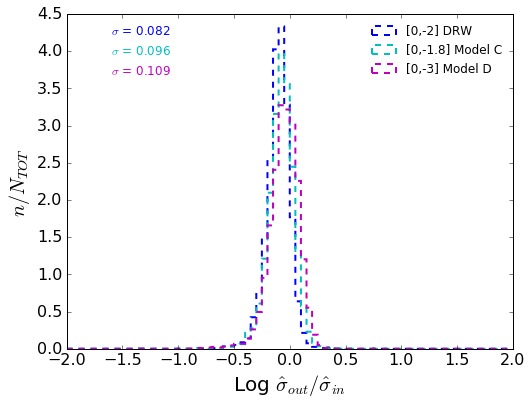

In [16]:
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw2_c2.txt')
#data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw2_c_drw_avdrw_poly_surface_all.txt')
#ghx_nodrw_c_drw_avdrw_poly_surface_all5.txt')  
#ghx_nodrw2_c2.txt
#samepar.txt,ghx_un_nomcmc_012_sametausig.txt,ghx_un_nomcmc_012_scattertausig.txt
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,psig3,ptau3,psig4,ptau4
plt.style.use('my')
SF_f1=data[:,13]
tau_f1=data[:,14]
SF_f2=data[:,15]
tau_f2=data[:,16]

#print '-1',np.median(SF_f1),np.median(tau_f1) 
#print '-2',np.median(SF_f2),np.median(tau_f2)


sigobs_m=data[:,2]
tauobs_m=data[:,3]
psig=data[:,4]
ptau=data[:,5]
psig1=data[:,6]#/SF_f1*1.9#*np.median(f1)#/1.5
ptau1=data[:,7]/tau_f1*1.1#/np.median(tau_f1)#*1.8
psig2=data[:,8]#/SF_f2*3.3#*f2#*np.median(f2)/1.5
ptau2=data[:,9]/tau_f2*1.3#/np.median(tau_f2)#/3





'''

psig1=data[:,10]
ptau1=data[:,11]
psig2=data[:,12]
ptau2=data[:,13]
'''


ptau[np.where((ptau == 'inf') | (ptau > 100000.), True, False)]=100000.
ptau1[np.where((ptau1 == 'inf') | (ptau1 > 100000.), True, False)]=100000.
ptau1[np.where( ptau1 < 1., True, False)]=1.
ptau2[np.where( ptau2 < 1., True, False)]=1.
ptau2[np.where((ptau2 == 'inf') | (ptau2 > 100000.), True, False)]=100000.
sigobs_m[np.where((sigobs_m == 0.0),True,False)]=0.0001
psig[np.where((psig == 0.0),True,False)]=0.0001
psig1[np.where((psig1 == 0.0),True,False)]=0.0001
psig2[np.where((psig2 == 0.0),True,False)]=0.0001

io=np.where(ptau<100000.)
i=np.where(ptau1 < 100000.)
i2=np.where((ptau2 < 100000.) &(psig2 >0.0001),True,False)
#print np.sum(i2)
#print 'obs', np.median(tauobs_m[io]),np.median(sigobs_m[io])
#print np.median(ptau),np.median(ptau1),np.median(ptau2)
#print np.median(psig),np.median(psig1),np.median(psig2)

print 'run away ratio-------------------'
print 'drw', np.sum(np.where(ptau>= 100000.,True,False))/float(np.sum(np.where(ptau>0.,True,False)))
print '-1.8', np.sum(np.where(ptau1>= 100000.,True,False))/float(np.sum(np.where(ptau1>0.,True,False)))
print '-3', np.sum(np.where(ptau2>= 100000.,True,False))/float(np.sum(np.where(ptau2>0.,True,False)))
print 'input', 1-np.sum(np.where(tauobs_m < 100000.,True,False))/9258.


sigma_i=sigobs_m/np.sqrt(tauobs_m)
sigma=psig/np.sqrt(ptau)

sigma1=psig1/np.sqrt(ptau1)
sigma2=psig2/np.sqrt(ptau2)

K_i=tauobs_m*np.sqrt(sigobs_m)
K=ptau*np.sqrt(psig)
K1=ptau1*np.sqrt(psig1)
K2=ptau2*np.sqrt(psig2)
#for high frequency

r=0.875

fig=plt.figure(figsize=(8,6))
'''
ax=plt.subplot(121)
bin3=np.arange(-2.,2,0.05)

plt.hist(list(b),bin3,histtype='step',normed=True,ls='dashed',color='b',label=r'${[0,-2]}$',lw=2)
plt.hist(list(c),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'${[0,-1.8]}$',lw=2)
plt.hist(list(m),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'${[0,-3]}$',lw=2)

plt.xlabel(r'Log $\hat\sigma_{out}/\hat\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False)


sg0=(np.percentile(b,(16,84))[1]-np.percentile(b,(16,84))[0])*0.5*r
plt.text(0.1,0.9,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax.transAxes,fontsize=12)
sg1=(np.percentile(c,(16,50))[1]-np.percentile(c,(16,50))[0])*r
plt.text(0.1,0.8,'$\sigma$ = '+str(round(sg1,3)),color='c',transform = ax.transAxes,fontsize=12)
sg2=(np.percentile(m,(16,84))[1]-np.percentile(m,(16,84))[0])*0.5*r
plt.text(0.1,0.7,'$\sigma$ = '+str(round(sg2,3)),color='m',transform = ax.transAxes,fontsize=12)
'''


ax3=plt.subplot(111)
bin3=np.arange(-2.,2,0.05)

plt.hist(list(np.log10(sigma[io]/sigma_i[io])),bin3,histtype='step',normed=True,ls='dashed',color='b',label=r'[0,-2] DRW',lw=2)
plt.hist(list(np.log10(sigma1[i]/sigma_i[i])),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'[0,-1.8] Model C',lw=2)
plt.hist(list(np.log10(sigma2[i2]/sigma_i[i2])),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'[0,-3] Model D',lw=2)

plt.xlabel(r'Log $\hat\sigma_{out}/\hat\sigma_{in}$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False)


sg0=(np.percentile(np.log10(sigma[io]/sigma_i[io]),(16,84))[1]-np.percentile(np.log10(sigma[io]/sigma_i[io]),(16,84))[0])*0.5*r
plt.text(0.1,0.94,'$\sigma$ = '+str(round(sg0,3)),color='blue',transform = ax3.transAxes,fontsize=12)
sg1=(np.percentile(np.log10(sigma1[i]/sigma_i[i]),(16,50))[1]-np.percentile(np.log10(sigma1[i]/sigma_i[i]),(16,50))[0])*r
plt.text(0.1,0.88,'$\sigma$ = '+str(round(sg1,3)),color='c',transform = ax3.transAxes,fontsize=12)
sg2=(np.percentile(np.log10(sigma2[i2]/sigma_i[i2]),(16,50))[1]-np.percentile(np.log10(sigma2[i2]/sigma_i[i2]),(16,50))[0])*r
plt.text(0.1,0.82,'$\sigma$ = '+str(round(sg2,3)),color='m',transform = ax3.transAxes,fontsize=12)
#print '-------',np.percentile(np.log10(sigma/sigma_i),(16,50))[1]-np.percentile(np.log10(sigma2/sigma_i),(16,50))[0]
#plt.text(0.65, 0.85, 'Corrected',transform=ax3.transAxes,fontsize=12 )


plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/cd.eps')

drw 0.177579749451
-1.8 0.139351672478
-3 0.274183133153
input 0.202527543746


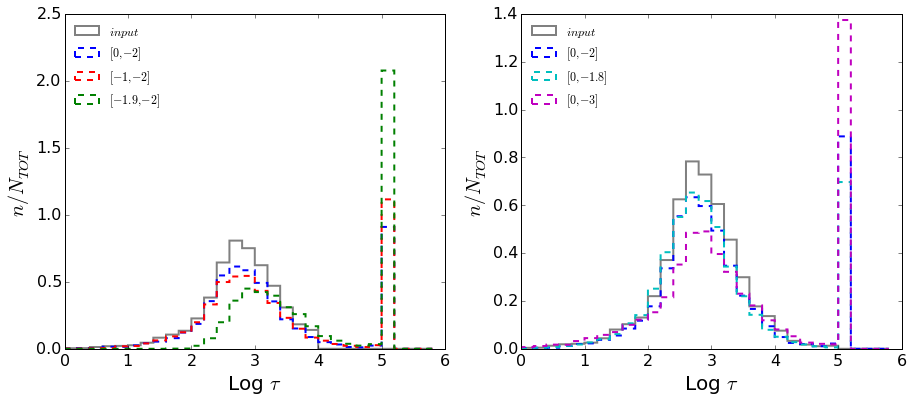

In [8]:
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_nodrw2_c_drw_avdrw_poly_surface_all1.txt')
#ghx_nodrw_c_drw_avdrw_poly_surface_all5.txt')  
#ghx_nodrw2_c2.txt
#samepar.txt,ghx_un_nomcmc_012_sametausig.txt,ghx_un_nomcmc_012_scattertausig.txt
#name,redshift,sigobs_m,tauobs_m,psig,ptau,psig1,ptau1,psig2,ptau2,psig3,ptau3,psig4,ptau4

SF_f1=data[:,13]
tau_f1=data[:,14]
SF_f2=data[:,15]
tau_f2=data[:,16]

#print '-1',np.median(SF_f1),np.median(tau_f1) 
#print '-2',np.median(SF_f2),np.median(tau_f2)


sigobs_m=data[:,2]
tauobs_m=data[:,3]
psig=data[:,4]
ptau=data[:,5]
psig1=data[:,6]#/SF_f1*1.9#*np.median(f1)#/1.5

ptau1=data[:,7]*1.5#/tau_f1*1.1#/np.median(tau_f1)#*1.8
psig2=data[:,8]#/SF_f2*3.3#*f2#*np.median(f2)/1.5
ptau2=data[:,9]#/tau_f2*2#/np.median(tau_f2)#/3

tauobs_m[tauobs_m>100000.]=1000000
ptau[np.isinf(ptau)]=100000.
ptau1[np.isinf(ptau1)]=100000.
ptau2[np.isinf(ptau2)]=100000.
ptau2[ptau2>100000.]=100000.
ptau1[ptau1>100000.]=100000.
ptau[ptau>100000.]=100000.


print 'drw', np.sum(np.where(ptau>= 100000.,True,False))/float(np.sum(np.where(ptau>0.,True,False)))
print '-1.8', np.sum(np.where(ptau1>= 100000.,True,False))/float(np.sum(np.where(ptau1>0.,True,False)))
print '-3', np.sum(np.where(ptau2>= 100000.,True,False))/float(np.sum(np.where(ptau2>0.,True,False)))
print 'input', 1-np.sum(np.where(tauobs_m < 100000.,True,False))/9258.

fig=plt.figure(figsize=(15,6))
plt.subplot(121)
bin3=np.arange(0.,6,0.2)
plt.hist(list(obsr),bin3,histtype='step',normed=True,color='grey',label=r'${input}$',lw=2)
plt.hist(list(br),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(rr),bin3,histtype='step',normed=True,ls='dashed',color='red',label=r'${[-1,-2]}$',lw=2)
plt.hist(list(gr),bin3,histtype='step',normed=True,ls='dashed',color='green',label=r'${[-1.9,-2]}$',lw=2)
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False,loc=2)

plt.subplot(122)
bin3=np.arange(0.,6,0.2)
plt.hist(list(np.log10(tauobs_m)),bin3,histtype='step',normed=True,color='grey',label=r'${input}$',lw=2)
plt.hist(list(np.log10(ptau)),bin3,histtype='step',normed=True,ls='dashed',color='blue',label=r'${[0,-2]}$',lw=2)
plt.hist(list(np.log10(ptau1)),bin3,histtype='step',normed=True,ls='dashed',color='c',label=r'${[0,-1.8]}$',lw=2)
plt.hist(list(np.log10(ptau2)),bin3,histtype='step',normed=True,ls='dashed',color='m',label=r'${[0,-3]}$',lw=2)
plt.xlabel(r'Log $\tau$')
plt.ylabel(r'$n/N_{TOT}$')
plt.legend(prop={'size':12},frameon=False,loc=2)

plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/runaway.eps')

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import astroML.time_series as TM
from scipy import interpolate
import pyLCSIM


sigobs_m=[]
tauobs_m=[]
redshift=[]
name=[]
psig=[]
ptau=[]
psig1=[]
ptau1=[]
psig2=[]
ptau2=[]
psig3=[]
ptau3=[]
psig4=[]
ptau4=[]


infor=np.genfromtxt('/Users/legolason/study/lightcurve/stripe82/DB_QSO_S82.dat')
os.chdir("/Users/legolason/study/lightcurve/stripe82/QSO_S82")
all_file=np.sort(map(int,np.asarray(glob.glob("*"))))

index1=np.array(np.where(((infor[:,7]) !=1.0) & (infor[:,5] < -5 ) )).reshape(-1,) # select from DB_QSO_S82
index2=np.array(np.where(np.array([len(open(str(all_file[i])).readlines()) for i in range(len(all_file))]) > 10)).reshape(-1,)
index=list(set(index1)&set(index2))



time_new=np.arange(0,365*10,1)
error_new=np.abs(np.random.normal(0,0.01,3650))


rand=int(np.random.randint(0,len(index),1))

data=np.genfromtxt(str(all_file[index][rand]))
mag_i=data[:,7]
index_i=np.where((mag_i>0) &(mag_i<30))
mag_i=mag_i[index_i]
mu=np.mean(mag_i)
mag_i_err=data[:,8]
mag_i_err=mag_i_err[index_i]
mjd_i=data[index_i,6]
time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
idx=time.astype(int)

print 'start'

for i in range(1):
    
    X=TM.generate_damped_RW(time_new, tau=500.0, z=0., xmean=mu, SFinf=0.16/1.414, random_state=None) #0.113
    f = interpolate.interp1d(time_new,X)
    X_obs=f(time)
    np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp.txt',np.c_[time, X_obs,mag_i_err])
    javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp.txt')
    cont1 = Cont_Model(javdata)
    #plt.plot(time,X_obs,'ro')
    plist=[np.log(0.16/1.414),np.log(500)] #lnsig lntau 
    p0=np.exp(np.array(cont1.do_map(plist,fixed=[1,1],set_prior=False,set_verbose=False)[0]))
    if p0[1] < 1.:   
        continue
    if p0[0] <= 0.0:
        continue
    if p0[0] >1.:
        continue
    tauobs_m.append(p0[1])
    sigobs_m.append(p0[0])
    
    
    
    
    #---------------for different model
    
    
    name0=0
    redshift0=0
    #sigobs_m.append(p0[0])
    #tauobs_m.append(p0[1])
    name.append(name0)
    redshift.append(redshift0)
    rate_src = 50000.0
    rate_bkg = 3000.0
    t_exp = 36500.0
    dt = 1
    frms = p0[0]
    freq_br=1/(2*np.pi*p0[1])
    nbins = long(t_exp/dt)
    
    for j,k in [[0,2.],[1.,2.],[1.9,2.],[0,1.8],[0,2.2]]:
        sim = pyLCSIM.Simulation()
        sim.addModel('smoothbknpo', [1,j, k, freq_br])
        sim.run(dt, nbins, rate_src, rms=frms)
        time_sim, rate = sim.getLightCurve()
        rate=rate/rate_src-1.+mu
    
    
        #---------obs as the input and get a new obs_output with 1days spaced 10yrs light cuvre with 0.01mag error.
        #X1=TM.generate_damped_RW(time_new, tau=p0[1], z=0., xmean=mu, SFinf=p0[0], random_state=None) #0.113
        np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt',np.c_[time_new[idx], rate[idx],error_new[idx]])
        #plt.plot(time_new,X1)
        #plt.plot(time,X1[idx],'ro')

        javdata = get_data('/Users/legolason/study/lightcurve/SF_test/para/javelin/tmp/tmp_un.txt')
        cont2 = Cont_Model(javdata)
        aa=[np.log(p0[0]),np.log(p0[1])]
        p=np.exp(np.array(cont2.do_map(aa,fixed=[1,1],set_prior=False)[0]))
        if [j,k]==[0,2.]:
            psig.append(p[0])
            ptau.append(p[1])
        if [j,k]==[1.,2]:
            psig1.append(p[0])
            ptau1.append(p[1])
        if [j,k]==[1.9,2.]:
            psig2.append(p[0])
            ptau2.append(p[1])
        if [j,k]==[0,1.8]:
            psig3.append(p[0])
            ptau3.append(p[1])
        if [j,k]==[0,2.2]:
            psig4.append(p[0])
            ptau4.append(p[1]) 
    print i
    
np.savetxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/ghx_un_nomcmc_012_scattertausig.txt',\
           np.c_[name,redshift,sigobs_m,tauobs_m,psig,ptau,\
                psig1,ptau1,psig2,ptau2,psig3,ptau3,psig4,ptau4],fmt='%4.3f')

print 'successed!'


start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
HPD of sigma
low:    0.110 med    0.139 hig    0.188
HPD of tau
low:  174.327 med  330.072 hig  691.279
Observed *zydata*, Constrained Realization
save light curves to /Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98.txt
start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
HPD of sigma
low:    0.061 med    0.077 hig    0.098
HPD of tau
low:   86.945 med  163.779 hig  325.955
Observed *zydata*, Constrained Realization
save light curves to /Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/233.txt
start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
HPD of sigma
low:    0.

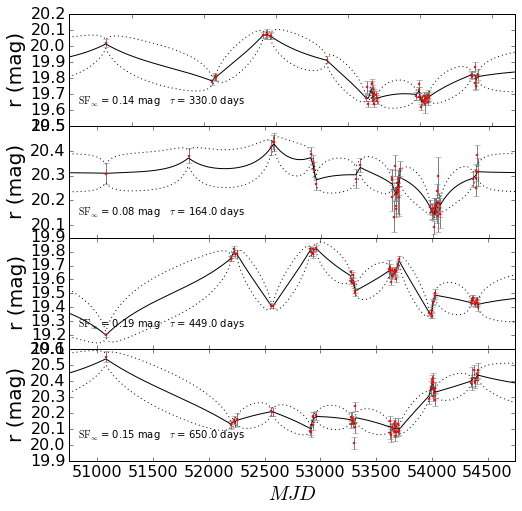

In [77]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import astroML.time_series as TM
from scipy import interpolate
import pyLCSIM

#------------------------fig1------------------------
a=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98')
np.savetxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r',np.c_[a[:,6],a[:,7],a[:,8]])
c = get_data(['/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r'])
cmod = Cont_Model(c)
cmod.do_mcmc()
aa0=cmod.hpd[1,:]
cc=cmod.do_pred(aa0,fpred='/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98.txt')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98.txt',skip_header=2)
obs=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r')

fig=plt.figure(figsize=(8,8))


ax1=plt.subplot(411)
plt.plot(data[:,0],data[:,1],'k')
plt.plot(data[:,0],data[:,1]+data[:,2],'k:')
plt.plot(data[:,0],data[:,1]-data[:,2],'k:')
plt.errorbar(obs[:,0], obs[:,1],yerr=obs[:,2],ecolor='grey', marker='o', mfc='r', mec='r',ms=2, ls='None', lw=1)
plt.xlabel(r"$MJD$")
plt.ylabel(r"r (mag)")
plt.xlim(min(data[:,0]), max(data[:,0]))
plt.text(0.02, 0.2, r'$\rm SF_{\infty}$ = '+np.str(round(np.exp(aa0[0]),2))+\
         r' mag   $\rm \tau$ = '+np.str(round(np.exp(aa0[1])))+' days',transform=ax1.transAxes )

#------------------------fig2------------------------
a=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/233')
np.savetxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/233_r',np.c_[a[:,6],a[:,7],a[:,8]])
c = get_data(['/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/233_r'])
cmod = Cont_Model(c)
cmod.do_mcmc()
aa0=cmod.hpd[1,:]
cc=cmod.do_pred(aa0,fpred='/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/233.txt')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/233.txt',skip_header=2)
obs=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/233_r')


ax2=plt.subplot(412)
plt.plot(data[:,0],data[:,1],'k')
plt.plot(data[:,0],data[:,1]+data[:,2],'k:')
plt.plot(data[:,0],data[:,1]-data[:,2],'k:')
plt.errorbar(obs[:,0], obs[:,1],yerr=obs[:,2],ecolor='grey', marker='o', mfc='r', mec='r',ms=2, ls='None', lw=1)
plt.xlabel(r"$MJD$")
plt.ylabel(r"r (mag)")
plt.xlim(min(data[:,0]), max(data[:,0]))
plt.text(0.02, 0.2, r'$\rm SF_{\infty}$ = '+np.str(round(np.exp(aa0[0]),2))+\
         r' mag   $\rm \tau$ = '+np.str(round(np.exp(aa0[1])))+' days',transform=ax2.transAxes )


#------------------------fig3------------------------
a=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/1018')
np.savetxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/1018_r',np.c_[a[:,6],a[:,7],a[:,8]])
c = get_data(["/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/1018_r"])
cmod = Cont_Model(c)
cmod.do_mcmc()
aa0=cmod.hpd[1,:]
cc=cmod.do_pred(aa0,fpred='/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/1018.txt')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/1018.txt',skip_header=2)
obs=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/1018_r')


ax3=plt.subplot(413)
plt.plot(data[:,0],data[:,1],'k')
plt.plot(data[:,0],data[:,1]+data[:,2],'k:')
plt.plot(data[:,0],data[:,1]-data[:,2],'k:')
plt.errorbar(obs[:,0], obs[:,1],yerr=obs[:,2],ecolor='grey', marker='o', mfc='r', mec='r',ms=2, ls='None', lw=1)
plt.xlabel(r"$MJD$")
plt.ylabel(r"r (mag)")
plt.xlim(min(data[:,0]), max(data[:,0]))
plt.text(0.02, 0.2, r'$\rm SF_{\infty}$ = '+np.str(round(np.exp(aa0[0]),2))+\
         r' mag   $\rm \tau$ = '+np.str(round(np.exp(aa0[1])))+' days',transform=ax3.transAxes )


#------------------------fig4------------------------
a=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/2953')
np.savetxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/2953_r',np.c_[a[:,6],a[:,7],a[:,8]])
c = get_data(['/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/2953_r'])
cmod = Cont_Model(c)
cmod.do_mcmc()
aa0=cmod.hpd[1,:]
cc=cmod.do_pred(aa0,fpred='/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/2953.txt')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/2953.txt',skip_header=2)
obs=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/2953_r')


ax4=plt.subplot(414)
plt.plot(data[:,0],data[:,1],'k')
plt.plot(data[:,0],data[:,1]+data[:,2],'k:')
plt.plot(data[:,0],data[:,1]-data[:,2],'k:')
plt.errorbar(obs[:,0], obs[:,1],yerr=obs[:,2],ecolor='grey', marker='o', mfc='r', mec='r',ms=2, ls='None', lw=1)
plt.xlabel(r"$MJD$")
plt.ylabel(r"r (mag)")
plt.xlim(min(data[:,0]), max(data[:,0]))
plt.text(0.02, 0.2, r'$\rm SF_{\infty}$ = '+np.str(round(np.exp(aa0[0]),2))+\
         r' mag   $\rm \tau$ = '+np.str(round(np.exp(aa0[1])))+' days',transform=ax4.transAxes )

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
#ax4.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)

#plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/example.eps')

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
HPD of sigma
low:    0.065 med    0.079 hig    0.100
HPD of tau
low:   66.729 med  109.165 hig  201.334
Observed *zydata*, Constrained Realization
save light curves to /Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98.txt
19.090440678
-----------
19.090440678
19.0622480591
start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
HPD of sigma
low:    0.067 med    0.081 hig    0.103
HPD of tau
low:   95.450 med  157.556 hig  263.458
[-2.508  5.06 ]
Observed *zydata*, Constrained Realization
save light curves to /Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98_r_sim.txt


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


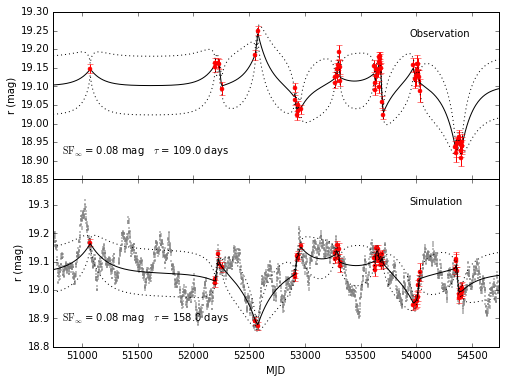

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from javelin.zylc import get_data
from javelin.lcmodel import Cont_Model
import astroML.time_series as TM
from scipy import interpolate
import pyLCSIM
from scipy.interpolate import interp1d

#------------------------fig1------------------------
a=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/2670')
np.savetxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r',np.c_[a[:,6],a[:,7],a[:,8]])
c = get_data(['/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r'])
cmod = Cont_Model(c)
cmod.do_mcmc()
aa0=cmod.hpd[1,:]
cc=cmod.do_pred(aa0,fpred='/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98.txt')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98.txt',skip_header=2)
obs=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r')

fig=plt.figure(figsize=(8,6))


ax1=plt.subplot(211)
plt.plot(data[:,0],data[:,1],'k')
plt.plot(data[:,0],data[:,1]+data[:,2],'k:')
plt.plot(data[:,0],data[:,1]-data[:,2],'k:')
plt.errorbar(obs[:,0], obs[:,1],yerr=obs[:,2],ecolor='r', marker='o', mfc='r', mec='r',ms=4, ls='None', lw=1)

print np.mean(obs[:,1])

plt.ylabel(r"r (mag)")
plt.xlim(min(data[:,0]), max(data[:,0]))
plt.text(0.02, 0.15, r'$\rm SF_{\infty}$ = '+np.str(round(np.exp(aa0[0]),2))+\
         r' mag   $\rm \tau$ = '+np.str(round(np.exp(aa0[1])))+' days',transform=ax1.transAxes )
plt.text(0.8, 0.85, 'Observation',transform=ax1.transAxes )

ax1.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)

#---------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++
ax2=plt.subplot(212)
mag_i=obs[:,1]
index_i=np.where((mag_i>0) &(mag_i<30))
mag_i=mag_i[index_i]
mu=np.mean(mag_i)
mag_i_err=obs[:,2]
mag_i_err=mag_i_err[index_i]
mjd_i=obs[index_i,0]
time=(np.round(mjd_i-mjd_i.min())).reshape(-1,)
idx=time.astype(int)
time_new=np.arange(np.round(data[:,0].min()),np.round(data[:,0].max()),1)

print '-----------'
print mu
X1=TM.generate_damped_RW(time_new, tau=np.exp(aa0[1]), z=0., xmean=mu, SFinf=np.exp(aa0[0]),random_state=3) #0.113
f = interp1d(time_new,X1 )
print np.mean(X1)
plt.plot(time_new,X1,'.',ms=2,color='grey')
plt.errorbar(obs[:,0],f(obs[:,0]),yerr=obs[:,2],ecolor='r', marker='o', mfc='r', mec='r',ms=4, ls='None', lw=1)
plt.xlim(min(data[:,0]), max(data[:,0]))
plt.xlabel(r'MJD')
plt.ylabel(r"r (mag)")
#plt.plot([50000,55000],[19.77,19.77],'k--')
#######-------fitting--------------
np.savetxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r_sim',np.c_[obs[:,0],f(obs[:,0]),obs[:,2]])
sim=get_data(['/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r_sim'])
cmod = Cont_Model(sim)
cmod.do_mcmc()
aa0=cmod.hpd[1,:]
print aa0
#plt.plot([50000,55000],[19.77-1.41*np.exp(cmod.hpd[1,0]),19.77-1.41*np.exp(cmod.hpd[1,0])],'k:')
#plt.plot([50000,55000],[19.77+1.41*np.exp(cmod.hpd[1,0]),19.77+1.41*np.exp(cmod.hpd[1,0])],'k:')
plt.text(0.02, 0.15, r'$\rm SF_{\infty}$ = '+np.str(round(np.exp(aa0[0]),2))+\
         r' mag   $\rm \tau$ = '+np.str(round(np.exp(aa0[1])))+' days',transform=ax2.transAxes )
plt.text(0.8, 0.85, 'Simulation',transform=ax2.transAxes )

#############
sim=cmod.do_pred(aa0,fpred='/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98_r_sim.txt')
data=np.genfromtxt('/Users/legolason/study/lightcurve/SF_test/para/javelin/fpred/98_r_sim.txt',skip_header=2)
#obs=np.genfromtxt('/Users/legolason/study/lightcurve/spear/javelin-0.32/examples/dat/98_r')
plt.plot(data[:,0],data[:,1],'k')
plt.plot(data[:,0],data[:,1]+data[:,2],'k:')
plt.plot(data[:,0],data[:,1]-data[:,2],'k:')

plt.ylim(18.8,19.39)
plt.savefig('/Users/legolason/study/lightcurve/SF_test/paper_figure/example3.eps')